# Test Training on Colab

## Set up

### install required packages

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install optuna

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 69.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 33.9 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-gkv1n0tz
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-gkv1n0tz
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 1f0fbe89d654232fdc949d7b947b938671657c31
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=1234822 sha256=0bb88ed16ef3a98eaab49848284f7d8ea113d19a70fcc9baf298b7f37a378dd5
  Stored in directory: /tmp/pip-ephem-wheel-cache-lx6t7

### Import and Var

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os

## Common Functions

In [4]:
import numpy as np
from sklearn.metrics import f1_score

def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t}, Best {metric} = {best_score}")

    return best_thresholds, best_scores

In [5]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred, label_cols):
    print(classification_report(y_test, y_pred, target_names=label_cols))
    mcm = multilabel_confusion_matrix(y_test, y_pred)

    n_labels = len(label_cols)
    _, axes = plt.subplots(1, n_labels, figsize=(5 * n_labels, 4))  # 5 units wide per plot

    for i, matrix in enumerate(mcm):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['No ' + label_cols[i], label_cols[i]])
        disp.plot(cmap=plt.cm.Blues, ax=axes[i], colorbar=False)
        axes[i].set_title(f'{label_cols[i]}')

    plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels, dropout=0.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_channels)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

In [ ]:
from torch_geometric.utils import from_networkx
import pandas as pd
import pickle

def load_data(mode='txn'):
    graph_feature = pd.read_csv(f'{mode}_graph_features.csv', index_col=0)
    graph_feature.index = graph_feature.index.str.lower()
    graphs = pickle.load(open('{mode}.pkl', 'rb'))
    y = pd.read_csv('groundtruth.csv', index_col=0)

    label_cols = y.columns.tolist()

    dataset = []
    for i, (address, graph_data) in enumerate(graphs.items()):
        feature = graph_feature.loc[address]
        data = from_networkx(graph_data)

        data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
        data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension
        dataset.append(data)

    return dataset, graph_feature.shape[1], label_cols


In [ ]:
def create_trained_model(in_channels, hidden_dim, out_channels, dropout, lr, epochs, train_loader):
    model = GCN(in_channels=in_channels, hidden=hidden_dim, out_channels=out_channels, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return model

def val_model(model, test_loader, thresholds=None):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch)
            prob = (torch.sigmoid(out)).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    if thresholds is None:
        thresholds, _ = tune_thresholds(y_true, y_pred)

    y_pred = (y_pred > thresholds).astype(int)

    return y_true, y_pred, thresholds


In [9]:
from torch_geometric.loader import DataLoader

def objective(trial, dataset, in_channels, out_channels):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)
    batch_size = trial.suggest_int("batch_size", 16, 256, log=True)
    epochs = trial.suggest_int("epochs", 5, 50)

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model = create_trained_model(in_channels, hidden_dim, out_channels, dropout, lr, epochs, train_loader)
    y_true, y_pred, _ = val_model(model, test_loader)

    return f1_score(y_true, y_pred, average='macro')


In [10]:
import torch
import json
import optuna
from functools import partial

def get_trained_gcn_model(mode='txn', n_trials=100, save_path=None):
    dataset, in_channel, label_cols = load_data(mode)
    study = optuna.create_study(direction="maximize")
    objective_partial = partial(objective, dataset=dataset, in_channels=in_channel, out_channels=len(label_cols))
    study.optimize(objective_partial, n_trials=n_trials)
    best_params = study.best_params

    print("Best Params:", study.best_params)
    print("Best Score:", study.best_value)

    best_model = create_trained_model(in_channel, best_params['hidden_dim'], len(label_cols), best_params['dropout'], best_params['lr'], best_params['epochs'], DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True))

    y_test, y_pred, thresholds = val_model(best_model, DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=False))

    weights = f1_score(y_test, y_pred, average=None)
    if save_path is not None:
        filename = f'{mode}_model.pth'
        torch.save(best_model.state_dict(), os.path.join(save_path, filename))
        print(f"Model saved to {filename}")

        filename = f'{mode}_best_params.json'
        with open(os.path.join(save_path, filename), 'w') as f:
            data = {
                **best_params,
                'in_channels':in_channel,
                'out_channels':len(label_cols),
                'thresholds': thresholds,
                'weights': weights.tolist()
            }
            json.dump(data, f, indent=4)
        print(f"Best parameters saved to {filename}")


    return best_model, thresholds

## Transaction

In [11]:
import torch
from torch_geometric.loader import DataLoader

model, thresholds = get_trained_gcn_model(mode='txn', save_path='.')

[I 2025-08-01 10:46:59,991] A new study created in memory with name: no-name-d923ef5f-1453-4087-a155-a3d63d6b9285


Epoch: 1/15, Loss: 92.6054
Epoch: 2/15, Loss: 51.4698
Epoch: 3/15, Loss: 17.7486
Epoch: 4/15, Loss: 2.7859
Epoch: 5/15, Loss: 4.6958
Epoch: 6/15, Loss: 5.6874
Epoch: 7/15, Loss: 6.0055
Epoch: 8/15, Loss: 8.6820
Epoch: 9/15, Loss: 8.4616
Epoch: 10/15, Loss: 7.0395
Epoch: 11/15, Loss: 7.5912
Epoch: 12/15, Loss: 7.3597
Epoch: 13/15, Loss: 6.4232
Epoch: 14/15, Loss: 6.0868
Epoch: 15/15, Loss: 6.0505
Label 0: Best threshold = 0.01, Best f1 = 0.4864864864864865
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:47:04,547] Trial 0 finished with value: 0.18685352018685353 and parameters: {'hidden_dim': 56, 'lr': 0.0031124800020860366, 'dropout': 0.7229846212596039, 'batch_size': 78, 'epochs': 15}. Best is trial 0 with value: 0.18685352018685353.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/49, Loss: 22.7551
Epoch: 2/49, Loss: 21.3654
Epoch: 3/49, Loss: 20.9906
Epoch: 4/49, Loss: 21.3483
Epoch: 5/49, Loss: 21.2191
Epoch: 6/49, Loss: 20.8124
Epoch: 7/49, Loss: 19.7510
Epoch: 8/49, Loss: 20.3906
Epoch: 9/49, Loss: 18.7765
Epoch: 10/49, Loss: 18.9436
Epoch: 11/49, Loss: 18.7221
Epoch: 12/49, Loss: 18.4846
Epoch: 13/49, Loss: 17.9128
Epoch: 14/49, Loss: 17.4555
Epoch: 15/49, Loss: 17.0363
Epoch: 16/49, Loss: 16.7984
Epoch: 17/49, Loss: 16.2360
Epoch: 18/49, Loss: 15.9712
Epoch: 19/49, Loss: 15.3780
Epoch: 20/49, Loss: 15.4675
Epoch: 21/49, Loss: 14.6255
Epoch: 22/49, Loss: 14.9366
Epoch: 23/49, Loss: 14.0763
Epoch: 24/49, Loss: 13.6927
Epoch: 25/49, Loss: 13.2215
Epoch: 26/49, Loss: 12.9726
Epoch: 27/49, Loss: 12.7435
Epoch: 28/49, Loss: 11.9499
Epoch: 29/49, Loss: 12.0995
Epoch: 30/49, Loss: 11.9447
Epoch: 31/49, Loss: 11.3998
Epoch: 32/49, Loss: 11.6360
Epoch: 33/49, Loss: 10.7567
Epoch: 34/49, Loss: 10.3974
Epoch: 35/4

[I 2025-08-01 10:47:43,999] Trial 1 finished with value: 0.17687074829931973 and parameters: {'hidden_dim': 202, 'lr': 1.5374714536765282e-05, 'dropout': 0.3562349368327127, 'batch_size': 45, 'epochs': 49}. Best is trial 0 with value: 0.18685352018685353.


Label 2: Best threshold = 0.01, Best f1 = 0.5306122448979592
Epoch: 1/23, Loss: 3.4433
Epoch: 2/23, Loss: 24.9265
Epoch: 3/23, Loss: 3.0302
Epoch: 4/23, Loss: 10.1918
Epoch: 5/23, Loss: 18.9989
Epoch: 6/23, Loss: 7.1341
Epoch: 7/23, Loss: 7.3404
Epoch: 8/23, Loss: 4.7338
Epoch: 9/23, Loss: 4.5952
Epoch: 10/23, Loss: 6.1012
Epoch: 11/23, Loss: 4.9088
Epoch: 12/23, Loss: 2.5467
Epoch: 13/23, Loss: 2.1509
Epoch: 14/23, Loss: 1.2376
Epoch: 15/23, Loss: 3.8384
Epoch: 16/23, Loss: 3.3414
Epoch: 17/23, Loss: 0.6931
Epoch: 18/23, Loss: 3.2470
Epoch: 19/23, Loss: 0.3744
Epoch: 20/23, Loss: 0.5864
Epoch: 21/23, Loss: 2.5723
Epoch: 22/23, Loss: 1.8374
Epoch: 23/23, Loss: 1.0900
Label 0: Best threshold = 0.01, Best f1 = 0.5161290322580645
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:47:59,737] Trial 2 finished with value: 0.17204301075268816 and parameters: {'hidden_dim': 146, 'lr': 0.001206683704147424, 'dropout': 0.7450730783288328, 'batch_size': 24, 'epochs': 23}. Best is trial 0 with value: 0.18685352018685353.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/15, Loss: 37.3162
Epoch: 2/15, Loss: 38.2568
Epoch: 3/15, Loss: 38.4224
Epoch: 4/15, Loss: 38.1757
Epoch: 5/15, Loss: 37.7286
Epoch: 6/15, Loss: 38.2616
Epoch: 7/15, Loss: 38.5250
Epoch: 8/15, Loss: 37.9991
Epoch: 9/15, Loss: 37.4001
Epoch: 10/15, Loss: 38.3266
Epoch: 11/15, Loss: 38.3201
Epoch: 12/15, Loss: 37.5311
Epoch: 13/15, Loss: 38.3141
Epoch: 14/15, Loss: 37.5005
Epoch: 15/15, Loss: 37.0499
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:48:08,001] Trial 3 finished with value: 0.17333333333333334 and parameters: {'hidden_dim': 122, 'lr': 1.3111558243945578e-06, 'dropout': 0.44794581001319145, 'batch_size': 57, 'epochs': 15}. Best is trial 0 with value: 0.18685352018685353.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/39, Loss: 5.5169
Epoch: 2/39, Loss: 57.5132
Epoch: 3/39, Loss: 33.2713
Epoch: 4/39, Loss: 30.8841
Epoch: 5/39, Loss: 23.8928
Epoch: 6/39, Loss: 15.6746
Epoch: 7/39, Loss: 7.6761
Epoch: 8/39, Loss: 8.6613
Epoch: 9/39, Loss: 11.5236
Epoch: 10/39, Loss: 9.9574
Epoch: 11/39, Loss: 9.0644
Epoch: 12/39, Loss: 4.5596
Epoch: 13/39, Loss: 1.9002
Epoch: 14/39, Loss: 3.8393
Epoch: 15/39, Loss: 4.9226
Epoch: 16/39, Loss: 5.2155
Epoch: 17/39, Loss: 5.0204
Epoch: 18/39, Loss: 4.4067
Epoch: 19/39, Loss: 3.5001
Epoch: 20/39, Loss: 2.4417
Epoch: 21/39, Loss: 1.3239
Epoch: 22/39, Loss: 0.6661
Epoch: 23/39, Loss: 2.5430
Epoch: 24/39, Loss: 2.2232
Epoch: 25/39, Loss: 1.6387
Epoch: 26/39, Loss: 1.3093
Epoch: 27/39, Loss: 1.1927
Epoch: 28/39, Loss: 1.5840
Epoch: 29/39, Loss: 1.7586
Epoch: 30/39, Loss: 1.6947
Epoch: 31/39, Loss: 1.4828
Epoch: 32/39, Loss: 1.1929
Epoch: 33/39, Loss: 0.7971
Epoch: 34/39, Loss: 0.6255
Epoch: 35/39, Loss: 0.9192
Epoch: 36/39

[I 2025-08-01 10:48:35,774] Trial 4 finished with value: 0.0 and parameters: {'hidden_dim': 152, 'lr': 0.004737636179259625, 'dropout': 0.13406225078250378, 'batch_size': 100, 'epochs': 39}. Best is trial 0 with value: 0.18685352018685353.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/20, Loss: 64.2597
Epoch: 2/20, Loss: 57.2875
Epoch: 3/20, Loss: 52.0710
Epoch: 4/20, Loss: 48.0148
Epoch: 5/20, Loss: 43.2792
Epoch: 6/20, Loss: 35.9202
Epoch: 7/20, Loss: 32.9170
Epoch: 8/20, Loss: 25.2489
Epoch: 9/20, Loss: 20.6488
Epoch: 10/20, Loss: 16.2560
Epoch: 11/20, Loss: 11.3717
Epoch: 12/20, Loss: 10.2464
Epoch: 13/20, Loss: 5.9510
Epoch: 14/20, Loss: 4.6055
Epoch: 15/20, Loss: 4.7108
Epoch: 16/20, Loss: 4.2494
Epoch: 17/20, Loss: 4.3918
Epoch: 18/20, Loss: 3.2318
Epoch: 19/20, Loss: 3.1721
Epoch: 20/20, Loss: 2.2568
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:48:40,784] Trial 5 finished with value: 0.03333333333333333 and parameters: {'hidden_dim': 60, 'lr': 0.0004002245801774639, 'dropout': 0.48362303538423124, 'batch_size': 112, 'epochs': 20}. Best is trial 0 with value: 0.18685352018685353.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/50, Loss: 5.1542
Epoch: 2/50, Loss: 6.6676
Epoch: 3/50, Loss: 6.8567
Epoch: 4/50, Loss: 5.6550
Epoch: 5/50, Loss: 7.5416
Epoch: 6/50, Loss: 5.5921
Epoch: 7/50, Loss: 6.4919
Epoch: 8/50, Loss: 9.6381
Epoch: 9/50, Loss: 12.3985
Epoch: 10/50, Loss: 7.0318
Epoch: 11/50, Loss: 5.6012
Epoch: 12/50, Loss: 5.9881
Epoch: 13/50, Loss: 5.0320
Epoch: 14/50, Loss: 9.8056
Epoch: 15/50, Loss: 9.5591
Epoch: 16/50, Loss: 5.2145
Epoch: 17/50, Loss: 9.2633
Epoch: 18/50, Loss: 7.1052
Epoch: 19/50, Loss: 9.1730
Epoch: 20/50, Loss: 6.5776
Epoch: 21/50, Loss: 3.0499
Epoch: 22/50, Loss: 6.6560
Epoch: 23/50, Loss: 9.6986
Epoch: 24/50, Loss: 8.6635
Epoch: 25/50, Loss: 8.9456
Epoch: 26/50, Loss: 2.7832
Epoch: 27/50, Loss: 7.9291
Epoch: 28/50, Loss: 8.5138
Epoch: 29/50, Loss: 9.2183
Epoch: 30/50, Loss: 1.6262
Epoch: 31/50, Loss: 0.9894
Epoch: 32/50, Loss: 6.6270
Epoch: 33/50, Loss: 6.5469
Epoch: 34/50, Loss: 7.5443
Epoch: 35/50, Loss: 8.3445
Epoch: 36/50, Los

[I 2025-08-01 10:49:14,841] Trial 6 finished with value: 0.10256410256410257 and parameters: {'hidden_dim': 187, 'lr': 1.569052103826437e-06, 'dropout': 0.5975967896337714, 'batch_size': 19, 'epochs': 50}. Best is trial 0 with value: 0.18685352018685353.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/18, Loss: 28.5173
Epoch: 2/18, Loss: 25.9039
Epoch: 3/18, Loss: 23.6976
Epoch: 4/18, Loss: 18.8433
Epoch: 5/18, Loss: 16.8029
Epoch: 6/18, Loss: 13.0160
Epoch: 7/18, Loss: 9.8679
Epoch: 8/18, Loss: 7.9407
Epoch: 9/18, Loss: 5.1604
Epoch: 10/18, Loss: 1.6871
Epoch: 11/18, Loss: 0.8914
Epoch: 12/18, Loss: 1.2424
Epoch: 13/18, Loss: 1.3241
Epoch: 14/18, Loss: 3.1295
Epoch: 15/18, Loss: 0.8222
Epoch: 16/18, Loss: 1.2346
Epoch: 17/18, Loss: 1.5527
Epoch: 18/18, Loss: 1.0333
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:49:26,432] Trial 7 finished with value: 0.0 and parameters: {'hidden_dim': 159, 'lr': 0.00016131190687747557, 'dropout': 0.7626088788229215, 'batch_size': 43, 'epochs': 18}. Best is trial 0 with value: 0.18685352018685353.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/12, Loss: 26.0465
Epoch: 2/12, Loss: 27.1179
Epoch: 3/12, Loss: 26.5711
Epoch: 4/12, Loss: 26.6496
Epoch: 5/12, Loss: 26.1189
Epoch: 6/12, Loss: 26.2196
Epoch: 7/12, Loss: 25.2280
Epoch: 8/12, Loss: 25.5629
Epoch: 9/12, Loss: 26.3224
Epoch: 10/12, Loss: 26.1027
Epoch: 11/12, Loss: 25.2526
Epoch: 12/12, Loss: 25.6020
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.01, Best f1 = 0.3076923076923077


[I 2025-08-01 10:49:41,313] Trial 8 finished with value: 0.24440807419530822 and parameters: {'hidden_dim': 94, 'lr': 1.2200112048569306e-05, 'dropout': 0.43114642154077915, 'batch_size': 199, 'epochs': 12}. Best is trial 8 with value: 0.24440807419530822.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/22, Loss: 5.8412
Epoch: 2/22, Loss: 27.3863
Epoch: 3/22, Loss: 11.8494
Epoch: 4/22, Loss: 16.5870
Epoch: 5/22, Loss: 23.4591
Epoch: 6/22, Loss: 23.9985
Epoch: 7/22, Loss: 20.3239
Epoch: 8/22, Loss: 14.4222
Epoch: 9/22, Loss: 7.3852
Epoch: 10/22, Loss: 2.8481
Epoch: 11/22, Loss: 10.8822
Epoch: 12/22, Loss: 8.4251
Epoch: 13/22, Loss: 2.3775
Epoch: 14/22, Loss: 4.2561
Epoch: 15/22, Loss: 6.4534
Epoch: 16/22, Loss: 7.0321
Epoch: 17/22, Loss: 6.7310
Epoch: 18/22, Loss: 5.6082
Epoch: 19/22, Loss: 3.9812
Epoch: 20/22, Loss: 2.3299
Epoch: 21/22, Loss: 2.6259
Epoch: 22/22, Loss: 1.1014
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:50:19,451] Trial 9 finished with value: 0.20512820512820515 and parameters: {'hidden_dim': 233, 'lr': 0.0034299819706630906, 'dropout': 0.6493868413117942, 'batch_size': 81, 'epochs': 22}. Best is trial 8 with value: 0.24440807419530822.


Label 2: Best threshold = 0.01, Best f1 = 0.6153846153846154
Epoch: 1/7, Loss: 23.3543
Epoch: 2/7, Loss: 23.3227
Epoch: 3/7, Loss: 23.0221
Epoch: 4/7, Loss: 22.4252
Epoch: 5/7, Loss: 23.1837
Epoch: 6/7, Loss: 23.3236
Epoch: 7/7, Loss: 22.2521
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:50:22,173] Trial 10 finished with value: 0.25666666666666665 and parameters: {'hidden_dim': 100, 'lr': 1.880931308561486e-05, 'dropout': 0.1958027979220101, 'batch_size': 214, 'epochs': 7}. Best is trial 10 with value: 0.25666666666666665.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/6, Loss: 16.6509
Epoch: 2/6, Loss: 16.6064
Epoch: 3/6, Loss: 16.4584
Epoch: 4/6, Loss: 16.4583
Epoch: 5/6, Loss: 16.3313
Epoch: 6/6, Loss: 16.3227
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:50:25,340] Trial 11 finished with value: 0.0 and parameters: {'hidden_dim': 99, 'lr': 1.7374757707892174e-05, 'dropout': 0.20449292626501625, 'batch_size': 256, 'epochs': 6}. Best is trial 10 with value: 0.25666666666666665.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/6, Loss: 6.8977
Epoch: 2/6, Loss: 6.8384
Epoch: 3/6, Loss: 6.7849
Epoch: 4/6, Loss: 6.7298
Epoch: 5/6, Loss: 6.6649
Epoch: 6/6, Loss: 6.6125
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:50:28,158] Trial 12 finished with value: 0.0 and parameters: {'hidden_dim': 99, 'lr': 1.555515729090846e-05, 'dropout': 0.002281113072535257, 'batch_size': 238, 'epochs': 6}. Best is trial 10 with value: 0.25666666666666665.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/31, Loss: 16.6501
Epoch: 2/31, Loss: 16.4985
Epoch: 3/31, Loss: 16.2102
Epoch: 4/31, Loss: 16.0066
Epoch: 5/31, Loss: 15.9403
Epoch: 6/31, Loss: 15.6787
Epoch: 7/31, Loss: 15.3680
Epoch: 8/31, Loss: 15.3651
Epoch: 9/31, Loss: 15.1206
Epoch: 10/31, Loss: 14.9650
Epoch: 11/31, Loss: 14.7822
Epoch: 12/31, Loss: 14.5121
Epoch: 13/31, Loss: 14.4217
Epoch: 14/31, Loss: 14.1300
Epoch: 15/31, Loss: 13.9442
Epoch: 16/31, Loss: 13.7901
Epoch: 17/31, Loss: 13.6501
Epoch: 18/31, Loss: 13.4349
Epoch: 19/31, Loss: 13.2639
Epoch: 20/31, Loss: 12.9991
Epoch: 21/31, Loss: 12.8207
Epoch: 22/31, Loss: 12.6169
Epoch: 23/31, Loss: 12.4245
Epoch: 24/31, Loss: 12.2630
Epoch: 25/31, Loss: 12.0086
Epoch: 26/31, Loss: 11.8861
Epoch: 27/31, Loss: 11.7344
Epoch: 28/31, Loss: 11.4370
Epoch: 29/31, Loss: 11.2505
Epoch: 30/31, Loss: 10.9889
Epoch: 31/31, Loss: 10.9541
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best 

[I 2025-08-01 10:50:37,153] Trial 13 finished with value: 0.0 and parameters: {'hidden_dim': 85, 'lr': 4.884997197568443e-05, 'dropout': 0.2819941425399216, 'batch_size': 163, 'epochs': 31}. Best is trial 10 with value: 0.25666666666666665.


Epoch: 1/10, Loss: 42.6260
Epoch: 2/10, Loss: 41.1091
Epoch: 3/10, Loss: 42.5850
Epoch: 4/10, Loss: 41.4552
Epoch: 5/10, Loss: 41.8877
Epoch: 6/10, Loss: 42.7063
Epoch: 7/10, Loss: 42.5064
Epoch: 8/10, Loss: 42.7106
Epoch: 9/10, Loss: 40.2629
Epoch: 10/10, Loss: 42.2984
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:50:39,249] Trial 14 finished with value: 0.17603200581923986 and parameters: {'hidden_dim': 45, 'lr': 3.6205415965494042e-06, 'dropout': 0.12267036705689409, 'batch_size': 170, 'epochs': 10}. Best is trial 10 with value: 0.25666666666666665.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/29, Loss: 24.9324
Epoch: 2/29, Loss: 24.5517
Epoch: 3/29, Loss: 25.0041
Epoch: 4/29, Loss: 23.9611
Epoch: 5/29, Loss: 24.6423
Epoch: 6/29, Loss: 24.8734
Epoch: 7/29, Loss: 24.6094
Epoch: 8/29, Loss: 24.1190
Epoch: 9/29, Loss: 24.4285
Epoch: 10/29, Loss: 24.1575
Epoch: 11/29, Loss: 23.7106
Epoch: 12/29, Loss: 23.5977
Epoch: 13/29, Loss: 24.0539
Epoch: 14/29, Loss: 23.8835
Epoch: 15/29, Loss: 23.9494
Epoch: 16/29, Loss: 24.0021
Epoch: 17/29, Loss: 23.7168
Epoch: 18/29, Loss: 23.2712
Epoch: 19/29, Loss: 23.4967
Epoch: 20/29, Loss: 23.0590
Epoch: 21/29, Loss: 22.9569
Epoch: 22/29, Loss: 23.0154
Epoch: 23/29, Loss: 23.3023
Epoch: 24/29, Loss: 23.1501
Epoch: 25/29, Loss: 22.8970
Epoch: 26/29, Loss: 23.2646
Epoch: 27/29, Loss: 23.5168
Epoch: 28/29, Loss: 23.3977
Epoch: 29/29, Loss: 22.1064
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:50:48,764] Trial 15 finished with value: 0.20085470085470084 and parameters: {'hidden_dim': 112, 'lr': 5.827227154491767e-06, 'dropout': 0.36640674233633486, 'batch_size': 146, 'epochs': 29}. Best is trial 10 with value: 0.25666666666666665.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/12, Loss: 54.7651
Epoch: 2/12, Loss: 52.8413
Epoch: 3/12, Loss: 50.5784
Epoch: 4/12, Loss: 51.6140
Epoch: 5/12, Loss: 47.9252
Epoch: 6/12, Loss: 46.2506
Epoch: 7/12, Loss: 45.4132
Epoch: 8/12, Loss: 42.6295
Epoch: 9/12, Loss: 40.5480
Epoch: 10/12, Loss: 40.4722
Epoch: 11/12, Loss: 37.2572
Epoch: 12/12, Loss: 36.0167
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:50:52,676] Trial 16 finished with value: 0.23926739926739926 and parameters: {'hidden_dim': 79, 'lr': 0.0001497429707381588, 'dropout': 0.5606523534545107, 'batch_size': 190, 'epochs': 12}. Best is trial 10 with value: 0.25666666666666665.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/9, Loss: 4.1593
Epoch: 2/9, Loss: 4.6869
Epoch: 3/9, Loss: 4.5748
Epoch: 4/9, Loss: 3.8596
Epoch: 5/9, Loss: 4.1921
Epoch: 6/9, Loss: 3.6618
Epoch: 7/9, Loss: 3.1653
Epoch: 8/9, Loss: 3.3861
Epoch: 9/9, Loss: 3.3671
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52


[I 2025-08-01 10:50:54,611] Trial 17 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 33, 'lr': 5.510624407766161e-05, 'dropout': 0.25618718039632554, 'batch_size': 129, 'epochs': 9}. Best is trial 10 with value: 0.25666666666666665.


Epoch: 1/5, Loss: 31.5488
Epoch: 2/5, Loss: 31.5098
Epoch: 3/5, Loss: 31.4642
Epoch: 4/5, Loss: 31.3326
Epoch: 5/5, Loss: 31.3893
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617


[I 2025-08-01 10:50:57,296] Trial 18 finished with value: 0.315177304964539 and parameters: {'hidden_dim': 128, 'lr': 5.30847751614049e-06, 'dropout': 0.011456139773771301, 'batch_size': 206, 'epochs': 5}. Best is trial 18 with value: 0.315177304964539.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/36, Loss: 0.7297
Epoch: 2/36, Loss: 1.4706
Epoch: 3/36, Loss: 6.3056
Epoch: 4/36, Loss: 10.0067
Epoch: 5/36, Loss: 8.5289
Epoch: 6/36, Loss: 1.2738
Epoch: 7/36, Loss: 6.1584
Epoch: 8/36, Loss: 0.8189
Epoch: 9/36, Loss: 3.2909
Epoch: 10/36, Loss: 4.5917
Epoch: 11/36, Loss: 4.2834
Epoch: 12/36, Loss: 5.7389
Epoch: 13/36, Loss: 7.0169
Epoch: 14/36, Loss: 1.3066
Epoch: 15/36, Loss: 0.7021
Epoch: 16/36, Loss: 9.5158
Epoch: 17/36, Loss: 2.0600
Epoch: 18/36, Loss: 2.8410
Epoch: 19/36, Loss: 2.6660
Epoch: 20/36, Loss: 4.4170
Epoch: 21/36, Loss: 4.5461
Epoch: 22/36, Loss: 6.5409
Epoch: 23/36, Loss: 0.5600
Epoch: 24/36, Loss: 6.2504
Epoch: 25/36, Loss: 2.9482
Epoch: 26/36, Loss: 4.1949
Epoch: 27/36, Loss: 2.7583
Epoch: 28/36, Loss: 1.8515
Epoch: 29/36, Loss: 2.9890
Epoch: 30/36, Loss: 3.2847
Epoch: 31/36, Loss: 0.5620
Epoch: 32/36, Loss: 3.8486
Epoch: 33/36, Loss: 0.8639
Epoch: 34/

[I 2025-08-01 10:51:12,184] Trial 19 finished with value: 0.35237028742067933 and parameters: {'hidden_dim': 134, 'lr': 4.513655874412192e-06, 'dropout': 0.04959605905863445, 'batch_size': 31, 'epochs': 36}. Best is trial 19 with value: 0.35237028742067933.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/37, Loss: 28.9290
Epoch: 2/37, Loss: 4.9714
Epoch: 3/37, Loss: 2.6012
Epoch: 4/37, Loss: 0.7477
Epoch: 5/37, Loss: 7.3859
Epoch: 6/37, Loss: 13.2856
Epoch: 7/37, Loss: 0.7635
Epoch: 8/37, Loss: 20.0346
Epoch: 9/37, Loss: 38.1408
Epoch: 10/37, Loss: 12.9417
Epoch: 11/37, Loss: 17.7833
Epoch: 12/37, Loss: 3.3292
Epoch: 13/37, Loss: 19.2797
Epoch: 14/37, Loss: 12.2855
Epoch: 15/37, Loss: 2.2617
Epoch: 16/37, Loss: 1.9718
Epoch: 17/37, Loss: 3.2810
Epoch: 18/37, Loss: 37.9132
Epoch: 19/37, Loss: 20.2618
Epoch: 20/37, Loss: 0.5882
Epoch: 21/37, Loss: 0.5149
Epoch: 22/37, Loss: 3.6915
Epoch: 23/37, Loss: 3.8520
Epoch: 24/37, Loss: 2.0053
Epoch: 25/37, Loss: 27.8489
Epoch: 26/37, Loss: 0.8099
Epoch: 27/37, Loss: 0.8173
Epoch: 28/37, Loss: 1.8471
Epoch: 29/37, Loss: 2.7798
Epoch: 30/37, Loss: 1.3456
Epoch: 31/37, Loss: 2.8181
Epoch: 32/37, Loss: 3.8241
Epoch: 33/37, Loss: 2.0232
Epoch: 34/37, Loss: 2.4837
Epoch: 35/37, Loss: 

[I 2025-08-01 10:51:34,245] Trial 20 finished with value: 0.1835106382978723 and parameters: {'hidden_dim': 178, 'lr': 2.941434740295747e-06, 'dropout': 0.02950887636297229, 'batch_size': 32, 'epochs': 37}. Best is trial 19 with value: 0.35237028742067933.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/37, Loss: 27.5304
Epoch: 2/37, Loss: 4.4708
Epoch: 3/37, Loss: 14.3770
Epoch: 4/37, Loss: 13.0939
Epoch: 5/37, Loss: 1.5206
Epoch: 6/37, Loss: 0.8570
Epoch: 7/37, Loss: 0.5709
Epoch: 8/37, Loss: 4.8050
Epoch: 9/37, Loss: 2.0785
Epoch: 10/37, Loss: 2.7372
Epoch: 11/37, Loss: 29.7354
Epoch: 12/37, Loss: 1.0090
Epoch: 13/37, Loss: 0.8112
Epoch: 14/37, Loss: 4.6210
Epoch: 15/37, Loss: 0.6736
Epoch: 16/37, Loss: 21.3641
Epoch: 17/37, Loss: 3.7840
Epoch: 18/37, Loss: 4.4368
Epoch: 19/37, Loss: 0.4891
Epoch: 20/37, Loss: 29.0146
Epoch: 21/37, Loss: 27.2429
Epoch: 22/37, Loss: 26.8555
Epoch: 23/37, Loss: 1.4041
Epoch: 24/37, Loss: 39.4621
Epoch: 25/37, Loss: 20.7650
Epoch: 26/37, Loss: 3.9416
Epoch: 27/37, Loss: 4.3790
Epoch: 28/37, Loss: 0.5643
Epoch: 29/37, Loss: 62.2346
Epoch: 30/37, Loss: 1.0477
Epoch: 31/37, Loss: 21.7009
Epoch: 32/37, Loss: 24.3568
Epoch: 33/37, Loss: 19.2678
Epoch: 34/37, Loss: 18.0888
Epoch: 35/37, Loss: 18.2538
Ep

[I 2025-08-01 10:52:14,651] Trial 21 finished with value: 0.18326118326118324 and parameters: {'hidden_dim': 130, 'lr': 5.935308654782404e-06, 'dropout': 0.10022396559745853, 'batch_size': 32, 'epochs': 37}. Best is trial 19 with value: 0.35237028742067933.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 26.0941
Epoch: 2/43, Loss: 25.6187
Epoch: 3/43, Loss: 25.1765
Epoch: 4/43, Loss: 24.7279
Epoch: 5/43, Loss: 24.7004
Epoch: 6/43, Loss: 23.5125
Epoch: 7/43, Loss: 23.0509
Epoch: 8/43, Loss: 22.4865
Epoch: 9/43, Loss: 22.4349
Epoch: 10/43, Loss: 21.6909
Epoch: 11/43, Loss: 20.9425
Epoch: 12/43, Loss: 20.3552
Epoch: 13/43, Loss: 20.3079
Epoch: 14/43, Loss: 19.6761
Epoch: 15/43, Loss: 19.0364
Epoch: 16/43, Loss: 18.7632
Epoch: 17/43, Loss: 18.2706
Epoch: 18/43, Loss: 17.8367
Epoch: 19/43, Loss: 17.5442
Epoch: 20/43, Loss: 16.9000
Epoch: 21/43, Loss: 16.4307
Epoch: 22/43, Loss: 15.9604
Epoch: 23/43, Loss: 15.6124
Epoch: 24/43, Loss: 14.8582
Epoch: 25/43, Loss: 14.4437
Epoch: 26/43, Loss: 13.8141
Epoch: 27/43, Loss: 13.6355
Epoch: 28/43, Loss: 13.0811
Epoch: 29/43, Loss: 12.7707
Epoch: 30/43, Loss: 12.0624
Epoch: 31/43, Loss: 11.4420
Epoch: 32/43, Loss: 11.3792
Epoch: 33/43, Loss: 10.8280
Epoch: 34/43, Loss: 10.5594
Epoch: 35/4

[I 2025-08-01 10:52:34,655] Trial 22 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 131, 'lr': 2.8076305238092276e-05, 'dropout': 0.07419008884255948, 'batch_size': 61, 'epochs': 43}. Best is trial 19 with value: 0.35237028742067933.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/33, Loss: 46.8553
Epoch: 2/33, Loss: 24.0849
Epoch: 3/33, Loss: 81.9721
Epoch: 4/33, Loss: 63.9889
Epoch: 5/33, Loss: 45.1331
Epoch: 6/33, Loss: 49.5367
Epoch: 7/33, Loss: 42.4412
Epoch: 8/33, Loss: 35.5677
Epoch: 9/33, Loss: 29.1805
Epoch: 10/33, Loss: 40.6419
Epoch: 11/33, Loss: 20.6950
Epoch: 12/33, Loss: 36.0756
Epoch: 13/33, Loss: 53.6000
Epoch: 14/33, Loss: 60.7341
Epoch: 15/33, Loss: 50.1997
Epoch: 16/33, Loss: 53.4910
Epoch: 17/33, Loss: 51.4254
Epoch: 18/33, Loss: 42.4026
Epoch: 19/33, Loss: 43.9406
Epoch: 20/33, Loss: 23.6753
Epoch: 21/33, Loss: 45.6866
Epoch: 22/33, Loss: 39.4139
Epoch: 23/33, Loss: 26.7647
Epoch: 24/33, Loss: 46.5811
Epoch: 25/33, Loss: 37.4668
Epoch: 26/33, Loss: 42.1584
Epoch: 27/33, Loss: 25.7699
Epoch: 28/33, Loss: 29.5105
Epoch: 29/33, Loss: 25.9633
Epoch: 30/33, Loss: 35.5609
Epoch: 31/33, Loss: 25.0855
Epoch: 32/33, Loss: 36.3609
Epoch: 33/33, Loss: 26.9259
Label 0: Best threshold = 0.0, Best f1 

[I 2025-08-01 10:52:50,957] Trial 23 finished with value: 0.33369582348305754 and parameters: {'hidden_dim': 167, 'lr': 8.211409677071001e-06, 'dropout': 0.1910785057000516, 'batch_size': 19, 'epochs': 33}. Best is trial 19 with value: 0.35237028742067933.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/32, Loss: 14.5663
Epoch: 2/32, Loss: 19.3794
Epoch: 3/32, Loss: 31.8843
Epoch: 4/32, Loss: 22.4217
Epoch: 5/32, Loss: 3.2569
Epoch: 6/32, Loss: 29.1943
Epoch: 7/32, Loss: 24.6580
Epoch: 8/32, Loss: 26.0283
Epoch: 9/32, Loss: 19.8727
Epoch: 10/32, Loss: 10.1266
Epoch: 11/32, Loss: 23.8306
Epoch: 12/32, Loss: 21.2029
Epoch: 13/32, Loss: 22.9945
Epoch: 14/32, Loss: 22.3577
Epoch: 15/32, Loss: 14.3126
Epoch: 16/32, Loss: 24.6006
Epoch: 17/32, Loss: 23.2740
Epoch: 18/32, Loss: 14.8587
Epoch: 19/32, Loss: 17.3443
Epoch: 20/32, Loss: 15.6078
Epoch: 21/32, Loss: 6.8896
Epoch: 22/32, Loss: 14.2835
Epoch: 23/32, Loss: 16.5508
Epoch: 24/32, Loss: 20.0920
Epoch: 25/32, Loss: 13.0867
Epoch: 26/32, Loss: 15.8213
Epoch: 27/32, Loss: 16.6481
Epoch: 28/32, Loss: 17.2959
Epoch: 29/32, Loss: 23.7698
Epoch: 30/32, Loss: 14.1849
Epoch: 31/32, Loss: 13.4053
Epoch: 32/32, Loss: 8.8681
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold 

[I 2025-08-01 10:53:05,866] Trial 24 finished with value: 0.3741880341880342 and parameters: {'hidden_dim': 169, 'lr': 5.254933689444274e-06, 'dropout': 0.16980901234132428, 'batch_size': 19, 'epochs': 32}. Best is trial 24 with value: 0.3741880341880342.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/32, Loss: 2.7779
Epoch: 2/32, Loss: 0.6581
Epoch: 3/32, Loss: 1.7170
Epoch: 4/32, Loss: 12.8037
Epoch: 5/32, Loss: 13.6834
Epoch: 6/32, Loss: 0.2506
Epoch: 7/32, Loss: 34.1666
Epoch: 8/32, Loss: 0.9194
Epoch: 9/32, Loss: 1.7424
Epoch: 10/32, Loss: 6.5631
Epoch: 11/32, Loss: 33.3700
Epoch: 12/32, Loss: 1.9372
Epoch: 13/32, Loss: 32.8380
Epoch: 14/32, Loss: 1.6142
Epoch: 15/32, Loss: 0.5078
Epoch: 16/32, Loss: 1.6675
Epoch: 17/32, Loss: 0.3937
Epoch: 18/32, Loss: 0.3417
Epoch: 19/32, Loss: 10.2098
Epoch: 20/32, Loss: 0.8098
Epoch: 21/32, Loss: 0.3780
Epoch: 22/32, Loss: 1.5718
Epoch: 23/32, Loss: 11.3457
Epoch: 24/32, Loss: 33.1401
Epoch: 25/32, Loss: 34.6072
Epoch: 26/32, Loss: 9.4532
Epoch: 27/32, Loss: 2.7243
Epoch: 28/32, Loss: 1.0697
Epoch: 29/32, Loss: 32.1260
Epoch: 30/32, Loss: 1.3447
Epoch: 31/32, Loss: 0.4232
Epoch: 32/32, Loss: 2.1086
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0,

[I 2025-08-01 10:53:40,551] Trial 25 finished with value: 0.0 and parameters: {'hidden_dim': 215, 'lr': 2.1156344816328706e-06, 'dropout': 0.18976243971710524, 'batch_size': 16, 'epochs': 32}. Best is trial 24 with value: 0.3741880341880342.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/25, Loss: 2.9675
Epoch: 2/25, Loss: 1.8338
Epoch: 3/25, Loss: 11.7810
Epoch: 4/25, Loss: 7.3266
Epoch: 5/25, Loss: 9.9472
Epoch: 6/25, Loss: 0.8885
Epoch: 7/25, Loss: 3.3883
Epoch: 8/25, Loss: 7.3396
Epoch: 9/25, Loss: 4.0886
Epoch: 10/25, Loss: 0.8166
Epoch: 11/25, Loss: 2.9251
Epoch: 12/25, Loss: 9.6634
Epoch: 13/25, Loss: 2.9981
Epoch: 14/25, Loss: 4.5514
Epoch: 15/25, Loss: 4.2841
Epoch: 16/25, Loss: 9.1174
Epoch: 17/25, Loss: 2.1590
Epoch: 18/25, Loss: 4.9419
Epoch: 19/25, Loss: 1.9225
Epoch: 20/25, Loss: 4.1233
Epoch: 21/25, Loss: 2.0151
Epoch: 22/25, Loss: 10.6548
Epoch: 23/25, Loss: 11.2914
Epoch: 24/25, Loss: 12.4508
Epoch: 25/25, Loss: 8.5782
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:54:18,437] Trial 26 finished with value: 0.0 and parameters: {'hidden_dim': 165, 'lr': 1.032185076783742e-06, 'dropout': 0.28258681794664503, 'batch_size': 24, 'epochs': 25}. Best is trial 24 with value: 0.3741880341880342.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/42, Loss: 11.6409
Epoch: 2/42, Loss: 4.0156
Epoch: 3/42, Loss: 5.8301
Epoch: 4/42, Loss: 20.2066
Epoch: 5/42, Loss: 28.5448
Epoch: 6/42, Loss: 4.2524
Epoch: 7/42, Loss: 27.2334
Epoch: 8/42, Loss: 23.8705
Epoch: 9/42, Loss: 28.2021
Epoch: 10/42, Loss: 10.7003
Epoch: 11/42, Loss: 26.0891
Epoch: 12/42, Loss: 41.7819
Epoch: 13/42, Loss: 11.3460
Epoch: 14/42, Loss: 20.0782
Epoch: 15/42, Loss: 1.3238
Epoch: 16/42, Loss: 21.6594
Epoch: 17/42, Loss: 9.8999
Epoch: 18/42, Loss: 22.9386
Epoch: 19/42, Loss: 9.3964
Epoch: 20/42, Loss: 18.2967
Epoch: 21/42, Loss: 18.2529
Epoch: 22/42, Loss: 29.4388
Epoch: 23/42, Loss: 32.1316
Epoch: 24/42, Loss: 6.1174
Epoch: 25/42, Loss: 5.6466
Epoch: 26/42, Loss: 5.1682
Epoch: 27/42, Loss: 1.0277
Epoch: 28/42, Loss: 3.9808
Epoch: 29/42, Loss: 20.3260
Epoch: 30/42, Loss: 17.3576
Epoch: 31/42, Loss: 15.4811
Epoch: 32/42, Loss: 14.9573
Epoch: 33/42, Loss: 4.0132
Epoch: 34/42, Loss: 14.2811
Epoch: 35/42, Loss: 25.

[I 2025-08-01 10:54:42,913] Trial 27 finished with value: 0.0 and parameters: {'hidden_dim': 172, 'lr': 1.0116473151648791e-05, 'dropout': 0.08036178935822927, 'batch_size': 23, 'epochs': 42}. Best is trial 24 with value: 0.3741880341880342.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/34, Loss: 27.1167
Epoch: 2/34, Loss: 5.9407
Epoch: 3/34, Loss: 3.0388
Epoch: 4/34, Loss: 36.1821
Epoch: 5/34, Loss: 3.5830
Epoch: 6/34, Loss: 1.0795
Epoch: 7/34, Loss: 4.0919
Epoch: 8/34, Loss: 1.2269
Epoch: 9/34, Loss: 2.6597
Epoch: 10/34, Loss: 0.7191
Epoch: 11/34, Loss: 3.1043
Epoch: 12/34, Loss: 2.9115
Epoch: 13/34, Loss: 0.7382
Epoch: 14/34, Loss: 2.5272
Epoch: 15/34, Loss: 0.5062
Epoch: 16/34, Loss: 0.9557
Epoch: 17/34, Loss: 0.7240
Epoch: 18/34, Loss: 1.0396
Epoch: 19/34, Loss: 0.8045
Epoch: 20/34, Loss: 0.7008
Epoch: 21/34, Loss: 10.6881
Epoch: 22/34, Loss: 2.1241
Epoch: 23/34, Loss: 0.7166
Epoch: 24/34, Loss: 0.3363
Epoch: 25/34, Loss: 0.2785
Epoch: 26/34, Loss: 6.7775
Epoch: 27/34, Loss: 0.5487
Epoch: 28/34, Loss: 0.7101
Epoch: 29/34, Loss: 0.5380
Epoch: 30/34, Loss: 0.4508
Epoch: 31/34, Loss: 0.4993
Epoch: 32/34, Loss: 0.6961
Epoch: 33/34, Loss: 0.5767
Epoch: 34/34, Loss: 0.6576
Label 0: Best threshold = 0.01, Best f1 = 

[I 2025-08-01 10:55:04,260] Trial 28 finished with value: 0.4120082815734989 and parameters: {'hidden_dim': 194, 'lr': 3.610839144008281e-05, 'dropout': 0.16200687109631745, 'batch_size': 16, 'epochs': 34}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.01, Best f1 = 0.5217391304347826
Epoch: 1/35, Loss: 2.6743
Epoch: 2/35, Loss: 3.3041
Epoch: 3/35, Loss: 2.6688
Epoch: 4/35, Loss: 1.1677
Epoch: 5/35, Loss: 0.8905
Epoch: 6/35, Loss: 0.6238
Epoch: 7/35, Loss: 0.6914
Epoch: 8/35, Loss: 0.6077
Epoch: 9/35, Loss: 3.3940
Epoch: 10/35, Loss: 0.3175
Epoch: 11/35, Loss: 0.6267
Epoch: 12/35, Loss: 0.4472
Epoch: 13/35, Loss: 6.9781
Epoch: 14/35, Loss: 2.1026
Epoch: 15/35, Loss: 11.4568
Epoch: 16/35, Loss: 2.2322
Epoch: 17/35, Loss: 9.4550
Epoch: 18/35, Loss: 0.3462
Epoch: 19/35, Loss: 0.5539
Epoch: 20/35, Loss: 3.1871
Epoch: 21/35, Loss: 0.4241
Epoch: 22/35, Loss: 0.4330
Epoch: 23/35, Loss: 0.8410
Epoch: 24/35, Loss: 0.6069
Epoch: 25/35, Loss: 7.8347
Epoch: 26/35, Loss: 0.5335
Epoch: 27/35, Loss: 0.5619
Epoch: 28/35, Loss: 0.6603
Epoch: 29/35, Loss: 2.6492
Epoch: 30/35, Loss: 1.5371
Epoch: 31/35, Loss: 0.4150
Epoch: 32/35, Loss: 0.4583
Epoch: 33/35, Loss: 0.6294
Epoch: 34/35, Loss: 0.9276
Epoch: 35/35, Loss: 0.4777
La

[I 2025-08-01 10:56:15,457] Trial 29 finished with value: 0.031746031746031744 and parameters: {'hidden_dim': 246, 'lr': 3.993772643330706e-05, 'dropout': 0.31785937822221444, 'batch_size': 33, 'epochs': 35}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/27, Loss: 46.1161
Epoch: 2/27, Loss: 5.1360
Epoch: 3/27, Loss: 1.6860
Epoch: 4/27, Loss: 1.4107
Epoch: 5/27, Loss: 0.9614
Epoch: 6/27, Loss: 2.0139
Epoch: 7/27, Loss: 1.0691
Epoch: 8/27, Loss: 20.9282
Epoch: 9/27, Loss: 1.7107
Epoch: 10/27, Loss: 0.8841
Epoch: 11/27, Loss: 1.2707
Epoch: 12/27, Loss: 0.5278
Epoch: 13/27, Loss: 0.8249
Epoch: 14/27, Loss: 0.8722
Epoch: 15/27, Loss: 0.9296
Epoch: 16/27, Loss: 1.6813
Epoch: 17/27, Loss: 0.8840
Epoch: 18/27, Loss: 2.0327
Epoch: 19/27, Loss: 0.4747
Epoch: 20/27, Loss: 0.5157
Epoch: 21/27, Loss: 0.3984
Epoch: 22/27, Loss: 2.4539
Epoch: 23/27, Loss: 0.5875
Epoch: 24/27, Loss: 0.4306
Epoch: 25/27, Loss: 0.5350
Epoch: 26/27, Loss: 1.1130
Epoch: 27/27, Loss: 0.5906
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:56:31,582] Trial 30 finished with value: 0.028985507246376812 and parameters: {'hidden_dim': 199, 'lr': 8.3416533069234e-05, 'dropout': 0.15288708211881558, 'batch_size': 16, 'epochs': 27}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/34, Loss: 6.9533
Epoch: 2/34, Loss: 10.3958
Epoch: 3/34, Loss: 8.7220
Epoch: 4/34, Loss: 5.8117
Epoch: 5/34, Loss: 9.7698
Epoch: 6/34, Loss: 3.0926
Epoch: 7/34, Loss: 8.6234
Epoch: 8/34, Loss: 3.1982
Epoch: 9/34, Loss: 7.2558
Epoch: 10/34, Loss: 7.2167
Epoch: 11/34, Loss: 2.1305
Epoch: 12/34, Loss: 1.1796
Epoch: 13/34, Loss: 5.4885
Epoch: 14/34, Loss: 1.6909
Epoch: 15/34, Loss: 0.9398
Epoch: 16/34, Loss: 1.5563
Epoch: 17/34, Loss: 1.3913
Epoch: 18/34, Loss: 1.1596
Epoch: 19/34, Loss: 0.5691
Epoch: 20/34, Loss: 1.1768
Epoch: 21/34, Loss: 1.5376
Epoch: 22/34, Loss: 0.7973
Epoch: 23/34, Loss: 4.5291
Epoch: 24/34, Loss: 1.5075
Epoch: 25/34, Loss: 1.2812
Epoch: 26/34, Loss: 4.2910
Epoch: 27/34, Loss: 4.2263
Epoch: 28/34, Loss: 1.2585
Epoch: 29/34, Loss: 0.6765
Epoch: 30/34, Loss: 0.5919
Epoch: 31/34, Loss: 4.1067
Epoch: 32/34, Loss: 1.0292
Epoch: 33/34, Loss: 0.6802
Epoch: 34/34, Loss: 1.0429
Label 0: Best threshold = 0.0, Best f1 = 0.4

[I 2025-08-01 10:56:50,404] Trial 31 finished with value: 0.041666666666666664 and parameters: {'hidden_dim': 193, 'lr': 7.370715492247386e-06, 'dropout': 0.23005889874927582, 'batch_size': 20, 'epochs': 34}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 49.5985
Epoch: 2/45, Loss: 50.8692
Epoch: 3/45, Loss: 12.0392
Epoch: 4/45, Loss: 5.9492
Epoch: 5/45, Loss: 15.3958
Epoch: 6/45, Loss: 25.1221
Epoch: 7/45, Loss: 42.7075
Epoch: 8/45, Loss: 4.6847
Epoch: 9/45, Loss: 86.5229
Epoch: 10/45, Loss: 47.9009
Epoch: 11/45, Loss: 12.5428
Epoch: 12/45, Loss: 91.4256
Epoch: 13/45, Loss: 17.7702
Epoch: 14/45, Loss: 17.9315
Epoch: 15/45, Loss: 11.1366
Epoch: 16/45, Loss: 48.1763
Epoch: 17/45, Loss: 12.7589
Epoch: 18/45, Loss: 20.1280
Epoch: 19/45, Loss: 12.8608
Epoch: 20/45, Loss: 44.5059
Epoch: 21/45, Loss: 43.3895
Epoch: 22/45, Loss: 36.2922
Epoch: 23/45, Loss: 7.9117
Epoch: 24/45, Loss: 13.7502
Epoch: 25/45, Loss: 44.2030
Epoch: 26/45, Loss: 70.3135
Epoch: 27/45, Loss: 47.8540
Epoch: 28/45, Loss: 46.4065
Epoch: 29/45, Loss: 36.8615
Epoch: 30/45, Loss: 46.4122
Epoch: 31/45, Loss: 42.2519
Epoch: 32/45, Loss: 3.1805
Epoch: 33/45, Loss: 4.9240
Epoch: 34/45, Loss: 78.4841
Epoch: 35/45, Lo

[I 2025-08-01 10:57:25,547] Trial 32 finished with value: 0.19185185185185186 and parameters: {'hidden_dim': 217, 'lr': 3.2706067584495706e-06, 'dropout': 0.16054348072603986, 'batch_size': 27, 'epochs': 45}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/29, Loss: 21.8239
Epoch: 2/29, Loss: 10.4043
Epoch: 3/29, Loss: 19.5159
Epoch: 4/29, Loss: 19.9320
Epoch: 5/29, Loss: 13.7729
Epoch: 6/29, Loss: 8.0193
Epoch: 7/29, Loss: 5.4705
Epoch: 8/29, Loss: 9.0320
Epoch: 9/29, Loss: 3.4048
Epoch: 10/29, Loss: 2.4066
Epoch: 11/29, Loss: 4.4293
Epoch: 12/29, Loss: 0.4724
Epoch: 13/29, Loss: 0.7291
Epoch: 14/29, Loss: 0.7745
Epoch: 15/29, Loss: 0.9412
Epoch: 16/29, Loss: 0.8886
Epoch: 17/29, Loss: 0.4065
Epoch: 18/29, Loss: 0.7089
Epoch: 19/29, Loss: 0.4223
Epoch: 20/29, Loss: 0.3949
Epoch: 21/29, Loss: 0.4847
Epoch: 22/29, Loss: 0.7256
Epoch: 23/29, Loss: 0.5803
Epoch: 24/29, Loss: 0.4395
Epoch: 25/29, Loss: 0.4345
Epoch: 26/29, Loss: 0.4429
Epoch: 27/29, Loss: 0.3480
Epoch: 28/29, Loss: 0.3936
Epoch: 29/29, Loss: 0.4657
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 10:57:38,725] Trial 33 finished with value: 0.0 and parameters: {'hidden_dim': 144, 'lr': 0.008367548180918291, 'dropout': 0.058830158054752835, 'batch_size': 19, 'epochs': 29}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 5.5452
Epoch: 2/40, Loss: 5.3085
Epoch: 3/40, Loss: 5.0923
Epoch: 4/40, Loss: 4.9224
Epoch: 5/40, Loss: 4.6332
Epoch: 6/40, Loss: 4.5353
Epoch: 7/40, Loss: 4.1780
Epoch: 8/40, Loss: 4.0618
Epoch: 9/40, Loss: 3.9298
Epoch: 10/40, Loss: 3.6367
Epoch: 11/40, Loss: 3.5230
Epoch: 12/40, Loss: 3.1421
Epoch: 13/40, Loss: 3.5428
Epoch: 14/40, Loss: 3.1356
Epoch: 15/40, Loss: 3.2919
Epoch: 16/40, Loss: 4.0170
Epoch: 17/40, Loss: 3.1642
Epoch: 18/40, Loss: 3.5750
Epoch: 19/40, Loss: 3.1132
Epoch: 20/40, Loss: 3.1339
Epoch: 21/40, Loss: 3.3050
Epoch: 22/40, Loss: 2.7378
Epoch: 23/40, Loss: 2.7054
Epoch: 24/40, Loss: 2.7041
Epoch: 25/40, Loss: 2.5462
Epoch: 26/40, Loss: 2.9762
Epoch: 27/40, Loss: 2.6699
Epoch: 28/40, Loss: 2.6829
Epoch: 29/40, Loss: 2.4666
Epoch: 30/40, Loss: 2.7634
Epoch: 31/40, Loss: 2.2912
Epoch: 32/40, Loss: 2.5256
Epoch: 33/40, Loss: 2.0983
Epoch: 34/40, Loss: 2.2135
Epoch: 35/40, Loss: 2.0248
Epoch: 36/40, Loss

[I 2025-08-01 10:58:17,604] Trial 34 finished with value: 0.12121212121212122 and parameters: {'hidden_dim': 175, 'lr': 2.8774866686696683e-05, 'dropout': 0.31563633795418883, 'batch_size': 38, 'epochs': 40}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/33, Loss: 10.3118
Epoch: 2/33, Loss: 16.6210
Epoch: 3/33, Loss: 8.1527
Epoch: 4/33, Loss: 21.7249
Epoch: 5/33, Loss: 28.7720
Epoch: 6/33, Loss: 23.5390
Epoch: 7/33, Loss: 8.0119
Epoch: 8/33, Loss: 1.8363
Epoch: 9/33, Loss: 13.2173
Epoch: 10/33, Loss: 2.0062
Epoch: 11/33, Loss: 15.6997
Epoch: 12/33, Loss: 3.1909
Epoch: 13/33, Loss: 14.5226
Epoch: 14/33, Loss: 8.2002
Epoch: 15/33, Loss: 6.8252
Epoch: 16/33, Loss: 29.5324
Epoch: 17/33, Loss: 11.4298
Epoch: 18/33, Loss: 1.0312
Epoch: 19/33, Loss: 8.8730
Epoch: 20/33, Loss: 17.9524
Epoch: 21/33, Loss: 22.9616
Epoch: 22/33, Loss: 16.3920
Epoch: 23/33, Loss: 11.4342
Epoch: 24/33, Loss: 6.5661
Epoch: 25/33, Loss: 15.8291
Epoch: 26/33, Loss: 15.6258
Epoch: 27/33, Loss: 16.5144
Epoch: 28/33, Loss: 6.6685
Epoch: 29/33, Loss: 14.0029
Epoch: 30/33, Loss: 9.8914
Epoch: 31/33, Loss: 0.7318
Epoch: 32/33, Loss: 12.6229
Epoch: 33/33, Loss: 8.6969
Label 0: Best threshold = 0.0, Best f1 = 0.4255319148

[I 2025-08-01 10:58:42,022] Trial 35 finished with value: 0.1702127659574468 and parameters: {'hidden_dim': 211, 'lr': 9.285300592051948e-06, 'dropout': 0.11315082249436553, 'batch_size': 21, 'epochs': 33}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/47, Loss: 11.7552
Epoch: 2/47, Loss: 3.9946
Epoch: 3/47, Loss: 1.2656
Epoch: 4/47, Loss: 0.8013
Epoch: 5/47, Loss: 3.0469
Epoch: 6/47, Loss: 2.5832
Epoch: 7/47, Loss: 3.6341
Epoch: 8/47, Loss: 0.4679
Epoch: 9/47, Loss: 2.5540
Epoch: 10/47, Loss: 0.4991
Epoch: 11/47, Loss: 3.9507
Epoch: 12/47, Loss: 0.4420
Epoch: 13/47, Loss: 0.3857
Epoch: 14/47, Loss: 2.1715
Epoch: 15/47, Loss: 2.8890
Epoch: 16/47, Loss: 1.4200
Epoch: 17/47, Loss: 2.9807
Epoch: 18/47, Loss: 1.9134
Epoch: 19/47, Loss: 1.4729
Epoch: 20/47, Loss: 0.5771
Epoch: 21/47, Loss: 0.4220
Epoch: 22/47, Loss: 1.0323
Epoch: 23/47, Loss: 0.6980
Epoch: 24/47, Loss: 0.8723
Epoch: 25/47, Loss: 1.8334
Epoch: 26/47, Loss: 0.4482
Epoch: 27/47, Loss: 0.4801
Epoch: 28/47, Loss: 0.6583
Epoch: 29/47, Loss: 0.5289
Epoch: 30/47, Loss: 0.3499
Epoch: 31/47, Loss: 1.4644
Epoch: 32/47, Loss: 1.7764
Epoch: 33/47, Loss: 0.7819
Epoch: 34/47, Loss: 0.4617
Epoch: 35/47, Loss: 1.0016
Epoch: 36/47, Los

[I 2025-08-01 10:59:29,617] Trial 36 finished with value: 0.0 and parameters: {'hidden_dim': 184, 'lr': 0.0005524030623555116, 'dropout': 0.05327396222244707, 'batch_size': 28, 'epochs': 47}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/37, Loss: 0.6827
Epoch: 2/37, Loss: 4.3627
Epoch: 3/37, Loss: 0.7601
Epoch: 4/37, Loss: 0.1402
Epoch: 5/37, Loss: 25.8478
Epoch: 6/37, Loss: 0.7869
Epoch: 7/37, Loss: 0.8152
Epoch: 8/37, Loss: 14.2377
Epoch: 9/37, Loss: 0.7725
Epoch: 10/37, Loss: 18.4902
Epoch: 11/37, Loss: 0.8042
Epoch: 12/37, Loss: 0.7451
Epoch: 13/37, Loss: 0.5280
Epoch: 14/37, Loss: 22.6368
Epoch: 15/37, Loss: 0.7902
Epoch: 16/37, Loss: 4.1896
Epoch: 17/37, Loss: 5.4853
Epoch: 18/37, Loss: 5.2218
Epoch: 19/37, Loss: 0.7346
Epoch: 20/37, Loss: 3.2529
Epoch: 21/37, Loss: 0.7639
Epoch: 22/37, Loss: 3.1386
Epoch: 23/37, Loss: 0.7879
Epoch: 24/37, Loss: 4.4789
Epoch: 25/37, Loss: 0.8051
Epoch: 26/37, Loss: 14.6598
Epoch: 27/37, Loss: 21.0963
Epoch: 28/37, Loss: 10.9227
Epoch: 29/37, Loss: 34.3314
Epoch: 30/37, Loss: 1.0727
Epoch: 31/37, Loss: 0.5447
Epoch: 32/37, Loss: 18.1998
Epoch: 33/37, Loss: 3.4068
Epoch: 34/37, Loss: 0.7458
Epoch: 35/37, Loss: 1.1340
Epoch: 36

[I 2025-08-01 10:59:44,976] Trial 37 finished with value: 0.32774140752864156 and parameters: {'hidden_dim': 142, 'lr': 2.1910272638543888e-06, 'dropout': 0.15639832135746567, 'batch_size': 17, 'epochs': 37}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 15.4004
Epoch: 2/40, Loss: 15.1376
Epoch: 3/40, Loss: 14.9439
Epoch: 4/40, Loss: 15.0818
Epoch: 5/40, Loss: 14.7059
Epoch: 6/40, Loss: 14.7461
Epoch: 7/40, Loss: 14.5233
Epoch: 8/40, Loss: 14.0765
Epoch: 9/40, Loss: 14.6313
Epoch: 10/40, Loss: 14.3837
Epoch: 11/40, Loss: 14.8916
Epoch: 12/40, Loss: 13.6720
Epoch: 13/40, Loss: 14.0439
Epoch: 14/40, Loss: 14.6953
Epoch: 15/40, Loss: 13.7663
Epoch: 16/40, Loss: 14.0081
Epoch: 17/40, Loss: 13.9920
Epoch: 18/40, Loss: 13.8595
Epoch: 19/40, Loss: 13.5492
Epoch: 20/40, Loss: 13.2169
Epoch: 21/40, Loss: 13.0119
Epoch: 22/40, Loss: 13.8817
Epoch: 23/40, Loss: 13.4576
Epoch: 24/40, Loss: 13.4967
Epoch: 25/40, Loss: 13.3600
Epoch: 26/40, Loss: 12.3902
Epoch: 27/40, Loss: 12.5629
Epoch: 28/40, Loss: 12.6473
Epoch: 29/40, Loss: 12.6751
Epoch: 30/40, Loss: 12.6655
Epoch: 31/40, Loss: 12.2522
Epoch: 32/40, Loss: 12.2718
Epoch: 33/40, Loss: 12.4915
Epoch: 34/40, Loss: 11.7876
Epoch: 35/4

[I 2025-08-01 11:00:08,758] Trial 38 finished with value: 0.34936533915257323 and parameters: {'hidden_dim': 161, 'lr': 4.608995440122272e-06, 'dropout': 0.2290717828707693, 'batch_size': 49, 'epochs': 40}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 19.1150
Epoch: 2/40, Loss: 20.0302
Epoch: 3/40, Loss: 19.2966
Epoch: 4/40, Loss: 19.1463
Epoch: 5/40, Loss: 19.4083
Epoch: 6/40, Loss: 19.3152
Epoch: 7/40, Loss: 19.4370
Epoch: 8/40, Loss: 19.2751
Epoch: 9/40, Loss: 18.8496
Epoch: 10/40, Loss: 18.8817
Epoch: 11/40, Loss: 19.2278
Epoch: 12/40, Loss: 19.1271
Epoch: 13/40, Loss: 18.6492
Epoch: 14/40, Loss: 18.5844
Epoch: 15/40, Loss: 18.5621
Epoch: 16/40, Loss: 18.7000
Epoch: 17/40, Loss: 18.5721
Epoch: 18/40, Loss: 18.2865
Epoch: 19/40, Loss: 18.5542
Epoch: 20/40, Loss: 18.2082
Epoch: 21/40, Loss: 18.5362
Epoch: 22/40, Loss: 18.2855
Epoch: 23/40, Loss: 17.9519
Epoch: 24/40, Loss: 17.9934
Epoch: 25/40, Loss: 17.8934
Epoch: 26/40, Loss: 17.4731
Epoch: 27/40, Loss: 17.6672
Epoch: 28/40, Loss: 17.8389
Epoch: 29/40, Loss: 17.8472
Epoch: 30/40, Loss: 17.5658
Epoch: 31/40, Loss: 17.3089
Epoch: 32/40, Loss: 17.5559
Epoch: 33/40, Loss: 16.9303
Epoch: 34/40, Loss: 17.5442
Epoch: 35/4

[I 2025-08-01 11:00:33,359] Trial 39 finished with value: 0.04882154882154882 and parameters: {'hidden_dim': 157, 'lr': 4.641507303833941e-06, 'dropout': 0.2418500104014074, 'batch_size': 51, 'epochs': 40}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 7.9036
Epoch: 2/43, Loss: 7.9511
Epoch: 3/43, Loss: 7.8005
Epoch: 4/43, Loss: 7.8158
Epoch: 5/43, Loss: 7.7707
Epoch: 6/43, Loss: 7.7186
Epoch: 7/43, Loss: 7.7968
Epoch: 8/43, Loss: 7.8579
Epoch: 9/43, Loss: 7.7987
Epoch: 10/43, Loss: 7.8207
Epoch: 11/43, Loss: 7.8009
Epoch: 12/43, Loss: 7.8833
Epoch: 13/43, Loss: 7.7990
Epoch: 14/43, Loss: 7.7476
Epoch: 15/43, Loss: 7.7502
Epoch: 16/43, Loss: 7.7717
Epoch: 17/43, Loss: 7.7900
Epoch: 18/43, Loss: 7.6887
Epoch: 19/43, Loss: 7.7292
Epoch: 20/43, Loss: 7.7477
Epoch: 21/43, Loss: 7.7911
Epoch: 22/43, Loss: 7.6944
Epoch: 23/43, Loss: 7.6154
Epoch: 24/43, Loss: 7.8337
Epoch: 25/43, Loss: 7.6686
Epoch: 26/43, Loss: 7.6886
Epoch: 27/43, Loss: 7.6205
Epoch: 28/43, Loss: 7.5770
Epoch: 29/43, Loss: 7.6366
Epoch: 30/43, Loss: 7.5825
Epoch: 31/43, Loss: 7.6250
Epoch: 32/43, Loss: 7.6408
Epoch: 33/43, Loss: 7.5650
Epoch: 34/43, Loss: 7.7538
Epoch: 35/43, Loss: 7.5911
Epoch: 36/43, Loss

[I 2025-08-01 11:00:51,534] Trial 40 finished with value: 0.08333333333333333 and parameters: {'hidden_dim': 114, 'lr': 1.6494594790956534e-06, 'dropout': 0.39210945737408376, 'batch_size': 77, 'epochs': 43}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/36, Loss: 62.5514
Epoch: 2/36, Loss: 61.9621
Epoch: 3/36, Loss: 61.4608
Epoch: 4/36, Loss: 61.0513
Epoch: 5/36, Loss: 59.5203
Epoch: 6/36, Loss: 59.4629
Epoch: 7/36, Loss: 59.0176
Epoch: 8/36, Loss: 58.6895
Epoch: 9/36, Loss: 58.2729
Epoch: 10/36, Loss: 58.2884
Epoch: 11/36, Loss: 57.0213
Epoch: 12/36, Loss: 56.1915
Epoch: 13/36, Loss: 55.5972
Epoch: 14/36, Loss: 55.7375
Epoch: 15/36, Loss: 54.8583
Epoch: 16/36, Loss: 54.0832
Epoch: 17/36, Loss: 53.2804
Epoch: 18/36, Loss: 53.2197
Epoch: 19/36, Loss: 51.8980
Epoch: 20/36, Loss: 51.4600
Epoch: 21/36, Loss: 51.8153
Epoch: 22/36, Loss: 51.3203
Epoch: 23/36, Loss: 50.9018
Epoch: 24/36, Loss: 49.8327
Epoch: 25/36, Loss: 49.1230
Epoch: 26/36, Loss: 48.8319
Epoch: 27/36, Loss: 47.9003
Epoch: 28/36, Loss: 47.2502
Epoch: 29/36, Loss: 47.0474
Epoch: 30/36, Loss: 46.5136
Epoch: 31/36, Loss: 46.0760
Epoch: 32/36, Loss: 45.7821
Epoch: 33/36, Loss: 44.9507
Epoch: 34/36, Loss: 44.3366
Epoch: 35/3

[I 2025-08-01 11:01:13,499] Trial 41 finished with value: 0.3408547008547009 and parameters: {'hidden_dim': 168, 'lr': 2.4229690058966302e-05, 'dropout': 0.19866197948507047, 'batch_size': 45, 'epochs': 36}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/38, Loss: 6.9157
Epoch: 2/38, Loss: 6.4763
Epoch: 3/38, Loss: 6.3547
Epoch: 4/38, Loss: 5.7289
Epoch: 5/38, Loss: 5.4192
Epoch: 6/38, Loss: 5.4060
Epoch: 7/38, Loss: 5.1625
Epoch: 8/38, Loss: 4.9071
Epoch: 9/38, Loss: 4.9690
Epoch: 10/38, Loss: 4.7308
Epoch: 11/38, Loss: 4.7579
Epoch: 12/38, Loss: 4.4958
Epoch: 13/38, Loss: 4.4050
Epoch: 14/38, Loss: 4.3888
Epoch: 15/38, Loss: 4.3788
Epoch: 16/38, Loss: 4.3178
Epoch: 17/38, Loss: 4.2942
Epoch: 18/38, Loss: 4.1281
Epoch: 19/38, Loss: 3.7771
Epoch: 20/38, Loss: 3.9438
Epoch: 21/38, Loss: 3.7621
Epoch: 22/38, Loss: 3.7176
Epoch: 23/38, Loss: 3.5121
Epoch: 24/38, Loss: 3.5881
Epoch: 25/38, Loss: 3.6501
Epoch: 26/38, Loss: 3.8202
Epoch: 27/38, Loss: 3.6613
Epoch: 28/38, Loss: 3.7067
Epoch: 29/38, Loss: 3.2326
Epoch: 30/38, Loss: 3.3876
Epoch: 31/38, Loss: 3.1861
Epoch: 32/38, Loss: 3.6413
Epoch: 33/38, Loss: 3.0854
Epoch: 34/38, Loss: 3.1948
Epoch: 35/38, Loss: 3.3341
Epoch: 36/38, Loss

[I 2025-08-01 11:01:33,571] Trial 42 finished with value: 0.09803921568627451 and parameters: {'hidden_dim': 155, 'lr': 2.2926743375861475e-05, 'dropout': 0.1251154018380038, 'batch_size': 48, 'epochs': 38}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/35, Loss: 6.2040
Epoch: 2/35, Loss: 4.0684
Epoch: 3/35, Loss: 2.6602
Epoch: 4/35, Loss: 2.9615
Epoch: 5/35, Loss: 2.7742
Epoch: 6/35, Loss: 1.7745
Epoch: 7/35, Loss: 1.3451
Epoch: 8/35, Loss: 1.4066
Epoch: 9/35, Loss: 2.2197
Epoch: 10/35, Loss: 2.3342
Epoch: 11/35, Loss: 1.9974
Epoch: 12/35, Loss: 1.6537
Epoch: 13/35, Loss: 1.2222
Epoch: 14/35, Loss: 1.1689
Epoch: 15/35, Loss: 1.3389
Epoch: 16/35, Loss: 1.4598
Epoch: 17/35, Loss: 1.3790
Epoch: 18/35, Loss: 1.3387
Epoch: 19/35, Loss: 1.2557
Epoch: 20/35, Loss: 0.9538
Epoch: 21/35, Loss: 1.1695
Epoch: 22/35, Loss: 1.6689
Epoch: 23/35, Loss: 0.7089
Epoch: 24/35, Loss: 0.9647
Epoch: 25/35, Loss: 0.9645
Epoch: 26/35, Loss: 0.7436
Epoch: 27/35, Loss: 0.7081
Epoch: 28/35, Loss: 0.7051
Epoch: 29/35, Loss: 0.7462
Epoch: 30/35, Loss: 0.6039
Epoch: 31/35, Loss: 1.4062
Epoch: 32/35, Loss: 0.6802
Epoch: 33/35, Loss: 0.6769
Epoch: 34/35, Loss: 0.7048
Epoch: 35/35, Loss: 0.6925
Label 0: Best thre

[I 2025-08-01 11:01:58,152] Trial 43 finished with value: 0.030303030303030304 and parameters: {'hidden_dim': 138, 'lr': 0.00012688338185114705, 'dropout': 0.31991720920367583, 'batch_size': 42, 'epochs': 35}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/30, Loss: 19.6308
Epoch: 2/30, Loss: 14.7495
Epoch: 3/30, Loss: 11.0440
Epoch: 4/30, Loss: 6.4663
Epoch: 5/30, Loss: 3.9653
Epoch: 6/30, Loss: 1.8216
Epoch: 7/30, Loss: 2.0122
Epoch: 8/30, Loss: 1.8538
Epoch: 9/30, Loss: 2.4941
Epoch: 10/30, Loss: 2.7896
Epoch: 11/30, Loss: 3.1442
Epoch: 12/30, Loss: 3.4382
Epoch: 13/30, Loss: 3.4944
Epoch: 14/30, Loss: 3.3287
Epoch: 15/30, Loss: 3.1362
Epoch: 16/30, Loss: 2.8350
Epoch: 17/30, Loss: 2.8729
Epoch: 18/30, Loss: 3.4585
Epoch: 19/30, Loss: 3.2441
Epoch: 20/30, Loss: 2.6302
Epoch: 21/30, Loss: 2.5058
Epoch: 22/30, Loss: 2.6493
Epoch: 23/30, Loss: 2.6569
Epoch: 24/30, Loss: 2.5534
Epoch: 25/30, Loss: 2.3591
Epoch: 26/30, Loss: 2.0584
Epoch: 27/30, Loss: 1.7505
Epoch: 28/30, Loss: 1.5686
Epoch: 29/30, Loss: 1.4872
Epoch: 30/30, Loss: 1.2056
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:02:28,647] Trial 44 finished with value: 0.0 and parameters: {'hidden_dim': 188, 'lr': 0.00022968760163385242, 'dropout': 0.21736389751333013, 'batch_size': 69, 'epochs': 30}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/27, Loss: 34.1350
Epoch: 2/27, Loss: 32.9385
Epoch: 3/27, Loss: 31.9414
Epoch: 4/27, Loss: 30.0778
Epoch: 5/27, Loss: 29.2535
Epoch: 6/27, Loss: 28.0685
Epoch: 7/27, Loss: 26.8321
Epoch: 8/27, Loss: 25.7921
Epoch: 9/27, Loss: 24.3348
Epoch: 10/27, Loss: 23.1949
Epoch: 11/27, Loss: 22.0061
Epoch: 12/27, Loss: 20.7861
Epoch: 13/27, Loss: 19.7839
Epoch: 14/27, Loss: 18.2613
Epoch: 15/27, Loss: 16.9903
Epoch: 16/27, Loss: 16.3494
Epoch: 17/27, Loss: 14.9331
Epoch: 18/27, Loss: 13.4916
Epoch: 19/27, Loss: 12.5274
Epoch: 20/27, Loss: 11.2938
Epoch: 21/27, Loss: 10.3046
Epoch: 22/27, Loss: 9.1260
Epoch: 23/27, Loss: 7.8182
Epoch: 24/27, Loss: 6.3887
Epoch: 25/27, Loss: 5.6836
Epoch: 26/27, Loss: 4.3150
Epoch: 27/27, Loss: 3.2571
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:02:47,769] Trial 45 finished with value: 0.057971014492753624 and parameters: {'hidden_dim': 150, 'lr': 7.489154929342877e-05, 'dropout': 0.165736471249067, 'batch_size': 52, 'epochs': 27}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/41, Loss: 15.0423
Epoch: 2/41, Loss: 13.8498
Epoch: 3/41, Loss: 13.1811
Epoch: 4/41, Loss: 12.6641
Epoch: 5/41, Loss: 12.1906
Epoch: 6/41, Loss: 11.4024
Epoch: 7/41, Loss: 11.6040
Epoch: 8/41, Loss: 11.3640
Epoch: 9/41, Loss: 10.4643
Epoch: 10/41, Loss: 9.6359
Epoch: 11/41, Loss: 9.9270
Epoch: 12/41, Loss: 8.8039
Epoch: 13/41, Loss: 8.7541
Epoch: 14/41, Loss: 8.2828
Epoch: 15/41, Loss: 7.5195
Epoch: 16/41, Loss: 7.0514
Epoch: 17/41, Loss: 7.1093
Epoch: 18/41, Loss: 6.4241
Epoch: 19/41, Loss: 5.8387
Epoch: 20/41, Loss: 5.3478
Epoch: 21/41, Loss: 4.6619
Epoch: 22/41, Loss: 4.7406
Epoch: 23/41, Loss: 3.7440
Epoch: 24/41, Loss: 3.2662
Epoch: 25/41, Loss: 3.6421
Epoch: 26/41, Loss: 2.6707
Epoch: 27/41, Loss: 2.2738
Epoch: 28/41, Loss: 1.7944
Epoch: 29/41, Loss: 1.1723
Epoch: 30/41, Loss: 0.7667
Epoch: 31/41, Loss: 0.5983
Epoch: 32/41, Loss: 1.2226
Epoch: 33/41, Loss: 0.9866
Epoch: 34/41, Loss: 1.3246
Epoch: 35/41, Loss: 1.4485
Epoch: 36

[I 2025-08-01 11:03:49,029] Trial 46 finished with value: 0.16161616161616163 and parameters: {'hidden_dim': 227, 'lr': 3.513070653001587e-05, 'dropout': 0.2635784098178502, 'batch_size': 38, 'epochs': 41}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 7.7022
Epoch: 2/45, Loss: 21.8682
Epoch: 3/45, Loss: 5.6411
Epoch: 4/45, Loss: 10.6422
Epoch: 5/45, Loss: 10.9050
Epoch: 6/45, Loss: 10.1237
Epoch: 7/45, Loss: 0.9299
Epoch: 8/45, Loss: 2.9876
Epoch: 9/45, Loss: 3.1617
Epoch: 10/45, Loss: 7.5270
Epoch: 11/45, Loss: 3.4375
Epoch: 12/45, Loss: 28.4541
Epoch: 13/45, Loss: 8.7491
Epoch: 14/45, Loss: 1.3946
Epoch: 15/45, Loss: 7.6890
Epoch: 16/45, Loss: 40.6135
Epoch: 17/45, Loss: 22.6417
Epoch: 18/45, Loss: 10.9886
Epoch: 19/45, Loss: 1.4403
Epoch: 20/45, Loss: 35.2212
Epoch: 21/45, Loss: 2.0816
Epoch: 22/45, Loss: 8.7488
Epoch: 23/45, Loss: 6.4911
Epoch: 24/45, Loss: 1.3696
Epoch: 25/45, Loss: 2.3163
Epoch: 26/45, Loss: 4.4396
Epoch: 27/45, Loss: 16.2260
Epoch: 28/45, Loss: 2.7004
Epoch: 29/45, Loss: 4.0803
Epoch: 30/45, Loss: 1.6970
Epoch: 31/45, Loss: 13.3213
Epoch: 32/45, Loss: 1.9423
Epoch: 33/45, Loss: 10.7484
Epoch: 34/45, Loss: 5.8369
Epoch: 35/45, Loss: 21.4705
Epoch

[I 2025-08-01 11:04:11,731] Trial 47 finished with value: 0.0 and parameters: {'hidden_dim': 164, 'lr': 1.3299277694275546e-05, 'dropout': 0.5164699213072613, 'batch_size': 27, 'epochs': 45}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/24, Loss: 36.3931
Epoch: 2/24, Loss: 9.1881
Epoch: 3/24, Loss: 6.4696
Epoch: 4/24, Loss: 10.7708
Epoch: 5/24, Loss: 12.0493
Epoch: 6/24, Loss: 11.5645
Epoch: 7/24, Loss: 9.7073
Epoch: 8/24, Loss: 6.9193
Epoch: 9/24, Loss: 4.3680
Epoch: 10/24, Loss: 4.3947
Epoch: 11/24, Loss: 1.6724
Epoch: 12/24, Loss: 1.0845
Epoch: 13/24, Loss: 5.3355
Epoch: 14/24, Loss: 6.2752
Epoch: 15/24, Loss: 0.8779
Epoch: 16/24, Loss: 2.3759
Epoch: 17/24, Loss: 3.3868
Epoch: 18/24, Loss: 3.4984
Epoch: 19/24, Loss: 3.0925
Epoch: 20/24, Loss: 2.3931
Epoch: 21/24, Loss: 1.9428
Epoch: 22/24, Loss: 2.0402
Epoch: 23/24, Loss: 1.7802
Epoch: 24/24, Loss: 1.6638
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617


[I 2025-08-01 11:04:41,125] Trial 48 finished with value: 0.0 and parameters: {'hidden_dim': 205, 'lr': 0.0013598088204881526, 'dropout': 0.699923949575552, 'batch_size': 38, 'epochs': 24}. Best is trial 28 with value: 0.4120082815734989.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/35, Loss: 4.7952
Epoch: 2/35, Loss: 4.6382
Epoch: 3/35, Loss: 4.5295
Epoch: 4/35, Loss: 4.3985
Epoch: 5/35, Loss: 4.2613
Epoch: 6/35, Loss: 4.1524
Epoch: 7/35, Loss: 4.0477
Epoch: 8/35, Loss: 3.8935
Epoch: 9/35, Loss: 3.7863
Epoch: 10/35, Loss: 3.6047
Epoch: 11/35, Loss: 3.5393
Epoch: 12/35, Loss: 3.3948
Epoch: 13/35, Loss: 3.2411
Epoch: 14/35, Loss: 3.1531
Epoch: 15/35, Loss: 3.0368
Epoch: 16/35, Loss: 2.9151
Epoch: 17/35, Loss: 2.8167
Epoch: 18/35, Loss: 2.6986
Epoch: 19/35, Loss: 2.5859
Epoch: 20/35, Loss: 2.5046
Epoch: 21/35, Loss: 2.3686
Epoch: 22/35, Loss: 2.2557
Epoch: 23/35, Loss: 2.1258
Epoch: 24/35, Loss: 2.0449
Epoch: 25/35, Loss: 1.9321
Epoch: 26/35, Loss: 1.8210
Epoch: 27/35, Loss: 1.8123
Epoch: 28/35, Loss: 1.6151
Epoch: 29/35, Loss: 1.5343
Epoch: 30/35, Loss: 1.3998
Epoch: 31/35, Loss: 1.2903
Epoch: 32/35, Loss: 1.3141
Epoch: 33/35, Loss: 1.1697
Epoch: 34/3

[I 2025-08-01 11:05:09,583] Trial 49 finished with value: 0.17687074829931973 and parameters: {'hidden_dim': 193, 'lr': 1.837591691974485e-05, 'dropout': 0.1001229387301108, 'batch_size': 96, 'epochs': 35}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.01, Best f1 = 0.5306122448979592
Epoch: 1/31, Loss: 0.8629
Epoch: 2/31, Loss: 6.0627
Epoch: 3/31, Loss: 10.9004
Epoch: 4/31, Loss: 1.3121
Epoch: 5/31, Loss: 1.3875
Epoch: 6/31, Loss: 6.2885
Epoch: 7/31, Loss: 2.6109
Epoch: 8/31, Loss: 5.1596
Epoch: 9/31, Loss: 5.7610
Epoch: 10/31, Loss: 10.1277
Epoch: 11/31, Loss: 1.4506
Epoch: 12/31, Loss: 4.7902
Epoch: 13/31, Loss: 5.5399
Epoch: 14/31, Loss: 11.0216
Epoch: 15/31, Loss: 3.3305
Epoch: 16/31, Loss: 7.6062
Epoch: 17/31, Loss: 5.3706
Epoch: 18/31, Loss: 5.0097
Epoch: 19/31, Loss: 5.0160
Epoch: 20/31, Loss: 4.4805
Epoch: 21/31, Loss: 2.1342
Epoch: 22/31, Loss: 8.9792
Epoch: 23/31, Loss: 9.8430
Epoch: 24/31, Loss: 4.8175
Epoch: 25/31, Loss: 3.8518
Epoch: 26/31, Loss: 1.9904
Epoch: 27/31, Loss: 2.1462
Epoch: 28/31, Loss: 2.0351
Epoch: 29/31, Loss: 1.9455
Epoch: 30/31, Loss: 2.0831
Epoch: 31/31, Loss: 0.5405
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.102564

[I 2025-08-01 11:06:08,628] Trial 50 finished with value: 0.06349206349206349 and parameters: {'hidden_dim': 181, 'lr': 4.199961660412302e-06, 'dropout': 0.051661069210692245, 'batch_size': 23, 'epochs': 31}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/33, Loss: 102.3590
Epoch: 2/33, Loss: 114.5518
Epoch: 3/33, Loss: 6.4535
Epoch: 4/33, Loss: 5.5770
Epoch: 5/33, Loss: 26.9400
Epoch: 6/33, Loss: 1.8867
Epoch: 7/33, Loss: 15.5033
Epoch: 8/33, Loss: 19.8411
Epoch: 9/33, Loss: 13.6509
Epoch: 10/33, Loss: 0.7278
Epoch: 11/33, Loss: 21.0400
Epoch: 12/33, Loss: 1.9939
Epoch: 13/33, Loss: 2.5411
Epoch: 14/33, Loss: 1.8531
Epoch: 15/33, Loss: 23.6554
Epoch: 16/33, Loss: 18.2219
Epoch: 17/33, Loss: 158.6385
Epoch: 18/33, Loss: 87.8096
Epoch: 19/33, Loss: 49.4398
Epoch: 20/33, Loss: 11.8951
Epoch: 21/33, Loss: 11.4081
Epoch: 22/33, Loss: 234.4182
Epoch: 23/33, Loss: 89.5395
Epoch: 24/33, Loss: 2.0846
Epoch: 25/33, Loss: 56.6769
Epoch: 26/33, Loss: 73.2916
Epoch: 27/33, Loss: 80.0423
Epoch: 28/33, Loss: 19.5004
Epoch: 29/33, Loss: 3.1049
Epoch: 30/33, Loss: 9.9356
Epoch: 31/33, Loss: 10.2364
Epoch: 32/33, Loss: 1.5854
Epoch: 33/33, Loss: 91.6375
Label 0: Best threshold = 0.0, Best f1 = 0.425

[I 2025-08-01 11:06:25,194] Trial 51 finished with value: 0.16036249014972417 and parameters: {'hidden_dim': 164, 'lr': 7.527390883364962e-06, 'dropout': 0.1981101358700089, 'batch_size': 17, 'epochs': 33}. Best is trial 28 with value: 0.4120082815734989.


Epoch: 1/39, Loss: 8.7894
Epoch: 2/39, Loss: 8.7266
Epoch: 3/39, Loss: 8.5280
Epoch: 4/39, Loss: 8.5752
Epoch: 5/39, Loss: 8.3234
Epoch: 6/39, Loss: 8.1906
Epoch: 7/39, Loss: 8.1510
Epoch: 8/39, Loss: 8.0787
Epoch: 9/39, Loss: 7.9412
Epoch: 10/39, Loss: 8.0293
Epoch: 11/39, Loss: 7.7646
Epoch: 12/39, Loss: 7.7356
Epoch: 13/39, Loss: 7.5699
Epoch: 14/39, Loss: 7.5068
Epoch: 15/39, Loss: 7.3340
Epoch: 16/39, Loss: 7.3766
Epoch: 17/39, Loss: 7.2352
Epoch: 18/39, Loss: 7.1731
Epoch: 19/39, Loss: 7.3898
Epoch: 20/39, Loss: 6.8849
Epoch: 21/39, Loss: 6.7663
Epoch: 22/39, Loss: 6.7120
Epoch: 23/39, Loss: 6.5845
Epoch: 24/39, Loss: 6.8983
Epoch: 25/39, Loss: 6.3925
Epoch: 26/39, Loss: 6.2639
Epoch: 27/39, Loss: 6.2998
Epoch: 28/39, Loss: 6.5735
Epoch: 29/39, Loss: 6.0129
Epoch: 30/39, Loss: 6.5703
Epoch: 31/39, Loss: 5.9117
Epoch: 32/39, Loss: 5.9098
Epoch: 33/39, Loss: 6.2248
Epoch: 34/39, Loss: 5.8927
Epoch: 35/39, Loss: 5.8258
Epoch: 36/39, Loss: 5.3834
Epoch: 37/39, Loss: 5.4623
Epoch: 38/

[I 2025-08-01 11:06:54,076] Trial 52 finished with value: 0.1328671328671329 and parameters: {'hidden_dim': 170, 'lr': 1.2042025489241447e-05, 'dropout': 0.198257378169576, 'batch_size': 56, 'epochs': 39}. Best is trial 28 with value: 0.4120082815734989.


Epoch: 1/36, Loss: 61.1962
Epoch: 2/36, Loss: 27.1980
Epoch: 3/36, Loss: 21.6900
Epoch: 4/36, Loss: 34.8755
Epoch: 5/36, Loss: 25.7570
Epoch: 6/36, Loss: 50.3953
Epoch: 7/36, Loss: 15.6287
Epoch: 8/36, Loss: 32.6499
Epoch: 9/36, Loss: 38.0518
Epoch: 10/36, Loss: 30.7489
Epoch: 11/36, Loss: 64.1060
Epoch: 12/36, Loss: 10.1812
Epoch: 13/36, Loss: 29.4560
Epoch: 14/36, Loss: 72.4185
Epoch: 15/36, Loss: 36.2845
Epoch: 16/36, Loss: 60.2876
Epoch: 17/36, Loss: 17.6523
Epoch: 18/36, Loss: 20.5579
Epoch: 19/36, Loss: 18.0748
Epoch: 20/36, Loss: 11.2837
Epoch: 21/36, Loss: 59.8053
Epoch: 22/36, Loss: 14.2825
Epoch: 23/36, Loss: 58.3657
Epoch: 24/36, Loss: 32.6899
Epoch: 25/36, Loss: 64.5760
Epoch: 26/36, Loss: 7.6608
Epoch: 27/36, Loss: 60.7883
Epoch: 28/36, Loss: 54.5364
Epoch: 29/36, Loss: 35.0623
Epoch: 30/36, Loss: 35.7353
Epoch: 31/36, Loss: 9.5484
Epoch: 32/36, Loss: 52.9974
Epoch: 33/36, Loss: 32.7817
Epoch: 34/36, Loss: 61.4256
Epoch: 35/36, Loss: 39.6816
Epoch: 36/36, Loss: 41.6965
Lab

[I 2025-08-01 11:07:06,284] Trial 53 finished with value: 0.19185185185185186 and parameters: {'hidden_dim': 119, 'lr': 2.608694548229383e-06, 'dropout': 0.1387978457131853, 'batch_size': 21, 'epochs': 36}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/33, Loss: 147.3237
Epoch: 2/33, Loss: 5.6247
Epoch: 3/33, Loss: 191.2465
Epoch: 4/33, Loss: 0.1476
Epoch: 5/33, Loss: 0.6904
Epoch: 6/33, Loss: 162.1691
Epoch: 7/33, Loss: 0.1528
Epoch: 8/33, Loss: 0.6972
Epoch: 9/33, Loss: 0.6854
Epoch: 10/33, Loss: 0.2451
Epoch: 11/33, Loss: 0.6853
Epoch: 12/33, Loss: 22.5646
Epoch: 13/33, Loss: 0.2634
Epoch: 14/33, Loss: 0.1712
Epoch: 15/33, Loss: 0.6989
Epoch: 16/33, Loss: 0.7938
Epoch: 17/33, Loss: 131.7592
Epoch: 18/33, Loss: 0.6912
Epoch: 19/33, Loss: 0.7030
Epoch: 20/33, Loss: 0.2232
Epoch: 21/33, Loss: 0.6974
Epoch: 22/33, Loss: 0.2968
Epoch: 23/33, Loss: 0.8113
Epoch: 24/33, Loss: 0.6956
Epoch: 25/33, Loss: 0.6818
Epoch: 26/33, Loss: 0.2394
Epoch: 27/33, Loss: 0.3399
Epoch: 28/33, Loss: 0.2542
Epoch: 29/33, Loss: 0.2164
Epoch: 30/33, Loss: 0.6932
Epoch: 31/33, Loss: 0.6867
Epoch: 32/33, Loss: 160.5133
Epoch: 33/33, Loss: 120.5386
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617


[I 2025-08-01 11:07:20,418] Trial 54 finished with value: 0.29945945945945945 and parameters: {'hidden_dim': 151, 'lr': 7.713733539947434e-06, 'dropout': 0.1736316925805019, 'batch_size': 18, 'epochs': 33}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/29, Loss: 2.0248
Epoch: 2/29, Loss: 0.8432
Epoch: 3/29, Loss: 0.6382
Epoch: 4/29, Loss: 0.6673
Epoch: 5/29, Loss: 0.6174
Epoch: 6/29, Loss: 2.0776
Epoch: 7/29, Loss: 1.8868
Epoch: 8/29, Loss: 1.5097
Epoch: 9/29, Loss: 1.1521
Epoch: 10/29, Loss: 0.5536
Epoch: 11/29, Loss: 0.6270
Epoch: 12/29, Loss: 0.5659
Epoch: 13/29, Loss: 0.4906
Epoch: 14/29, Loss: 0.6128
Epoch: 15/29, Loss: 0.8403
Epoch: 16/29, Loss: 0.9757
Epoch: 17/29, Loss: 0.7813
Epoch: 18/29, Loss: 0.6047
Epoch: 19/29, Loss: 0.5329
Epoch: 20/29, Loss: 0.5743
Epoch: 21/29, Loss: 0.4598
Epoch: 22/29, Loss: 0.6707
Epoch: 23/29, Loss: 0.7882
Epoch: 24/29, Loss: 0.5514
Epoch: 25/29, Loss: 0.4442
Epoch: 26/29, Loss: 0.5463
Epoch: 27/29, Loss: 0.4553
Epoch: 28/29, Loss: 0.5727
Epoch: 29/29, Loss: 0.6128
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:07:40,558] Trial 55 finished with value: 0.1372549019607843 and parameters: {'hidden_dim': 200, 'lr': 5.424773161050866e-05, 'dropout': 0.28409529483458934, 'batch_size': 29, 'epochs': 29}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/38, Loss: 26.0670
Epoch: 2/38, Loss: 25.6832
Epoch: 3/38, Loss: 25.1483
Epoch: 4/38, Loss: 24.8074
Epoch: 5/38, Loss: 24.2034
Epoch: 6/38, Loss: 23.6632
Epoch: 7/38, Loss: 23.1688
Epoch: 8/38, Loss: 22.5005
Epoch: 9/38, Loss: 22.1848
Epoch: 10/38, Loss: 21.6959
Epoch: 11/38, Loss: 21.0713
Epoch: 12/38, Loss: 20.5937
Epoch: 13/38, Loss: 20.1159
Epoch: 14/38, Loss: 19.5869
Epoch: 15/38, Loss: 18.8314
Epoch: 16/38, Loss: 18.5479
Epoch: 17/38, Loss: 17.9490
Epoch: 18/38, Loss: 17.4873
Epoch: 19/38, Loss: 16.8389
Epoch: 20/38, Loss: 16.5313
Epoch: 21/38, Loss: 16.2616
Epoch: 22/38, Loss: 15.8568
Epoch: 23/38, Loss: 15.0567
Epoch: 24/38, Loss: 14.5742
Epoch: 25/38, Loss: 14.1587
Epoch: 26/38, Loss: 13.5536
Epoch: 27/38, Loss: 13.1834
Epoch: 28/38, Loss: 12.5046
Epoch: 29/38, Loss: 12.3211
Epoch: 30/38, Loss: 11.6910
Epoch: 31/38, Loss: 11.0657
Epoch: 32/38, Loss: 10.7350
Epoch: 33/38, Loss: 10.4004
Epoch: 34/38, Loss: 9.8693
Epoch: 35/38

[I 2025-08-01 11:07:58,412] Trial 56 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 141, 'lr': 2.2301296024033125e-05, 'dropout': 0.026573477877341184, 'batch_size': 44, 'epochs': 38}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/32, Loss: 0.5917
Epoch: 2/32, Loss: 0.5209
Epoch: 3/32, Loss: 12.9559
Epoch: 4/32, Loss: 17.9609
Epoch: 5/32, Loss: 0.4180
Epoch: 6/32, Loss: 17.5774
Epoch: 7/32, Loss: 3.6993
Epoch: 8/32, Loss: 3.7745
Epoch: 9/32, Loss: 40.8325
Epoch: 10/32, Loss: 0.5867
Epoch: 11/32, Loss: 0.7035
Epoch: 12/32, Loss: 38.5439
Epoch: 13/32, Loss: 87.1197
Epoch: 14/32, Loss: 0.7958
Epoch: 15/32, Loss: 0.8913
Epoch: 16/32, Loss: 12.7667
Epoch: 17/32, Loss: 0.8582
Epoch: 18/32, Loss: 5.9368
Epoch: 19/32, Loss: 18.0382
Epoch: 20/32, Loss: 0.4585
Epoch: 21/32, Loss: 98.2019
Epoch: 22/32, Loss: 41.4179
Epoch: 23/32, Loss: 0.9269
Epoch: 24/32, Loss: 0.7536
Epoch: 25/32, Loss: 0.2754
Epoch: 26/32, Loss: 0.7528
Epoch: 27/32, Loss: 11.7813
Epoch: 28/32, Loss: 3.7799
Epoch: 29/32, Loss: 0.5093
Epoch: 30/32, Loss: 0.4068
Epoch: 31/32, Loss: 0.4496
Epoch: 32/32, Loss: 0.5983
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best 

[I 2025-08-01 11:08:19,207] Trial 57 finished with value: 0.17333333333333334 and parameters: {'hidden_dim': 174, 'lr': 1.4712197233795168e-06, 'dropout': 0.3502578952764236, 'batch_size': 35, 'epochs': 32}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/26, Loss: 20.6217
Epoch: 2/26, Loss: 20.7308
Epoch: 3/26, Loss: 20.5459
Epoch: 4/26, Loss: 20.2678
Epoch: 5/26, Loss: 20.2602
Epoch: 6/26, Loss: 20.4453
Epoch: 7/26, Loss: 20.2228
Epoch: 8/26, Loss: 19.5430
Epoch: 9/26, Loss: 19.9666
Epoch: 10/26, Loss: 20.0776
Epoch: 11/26, Loss: 19.8986
Epoch: 12/26, Loss: 19.6908
Epoch: 13/26, Loss: 19.9081
Epoch: 14/26, Loss: 19.1988
Epoch: 15/26, Loss: 18.7971
Epoch: 16/26, Loss: 19.0155
Epoch: 17/26, Loss: 19.1350
Epoch: 18/26, Loss: 19.0146
Epoch: 19/26, Loss: 18.9976
Epoch: 20/26, Loss: 18.5896
Epoch: 21/26, Loss: 17.8143
Epoch: 22/26, Loss: 18.6801
Epoch: 23/26, Loss: 18.1825
Epoch: 24/26, Loss: 18.3654
Epoch: 25/26, Loss: 17.5618
Epoch: 26/26, Loss: 17.9926
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:08:33,572] Trial 58 finished with value: 0.20752136752136752 and parameters: {'hidden_dim': 159, 'lr': 5.666468343658091e-06, 'dropout': 0.22842411976552768, 'batch_size': 66, 'epochs': 26}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/36, Loss: 3.9766
Epoch: 2/36, Loss: 12.4012
Epoch: 3/36, Loss: 1.3644
Epoch: 4/36, Loss: 4.9117
Epoch: 5/36, Loss: 10.9389
Epoch: 6/36, Loss: 3.8929
Epoch: 7/36, Loss: 1.0620
Epoch: 8/36, Loss: 11.6205
Epoch: 9/36, Loss: 9.3063
Epoch: 10/36, Loss: 2.0538
Epoch: 11/36, Loss: 2.9666
Epoch: 12/36, Loss: 9.9643
Epoch: 13/36, Loss: 9.4010
Epoch: 14/36, Loss: 0.7493
Epoch: 15/36, Loss: 2.0097
Epoch: 16/36, Loss: 2.2221
Epoch: 17/36, Loss: 9.7572
Epoch: 18/36, Loss: 10.0765
Epoch: 19/36, Loss: 1.3593
Epoch: 20/36, Loss: 1.7985
Epoch: 21/36, Loss: 1.8306
Epoch: 22/36, Loss: 0.9601
Epoch: 23/36, Loss: 1.9406
Epoch: 24/36, Loss: 1.1901
Epoch: 25/36, Loss: 8.1169
Epoch: 26/36, Loss: 1.3817
Epoch: 27/36, Loss: 1.2055
Epoch: 28/36, Loss: 9.3697
Epoch: 29/36, Loss: 0.7537
Epoch: 30/36, Loss: 1.9388
Epoch: 31/36, Loss: 1.8554
Epoch: 32/36, Loss: 7.9063
Epoch: 33/36, Loss: 2.8818
Epoch: 34/36, Loss: 0.9557
Epoch: 35/36, Loss: 7.9566
Epoch: 36/36, 

[I 2025-08-01 11:08:46,059] Trial 59 finished with value: 0.1898148148148148 and parameters: {'hidden_dim': 132, 'lr': 1.492175282972202e-05, 'dropout': 0.09390713321980336, 'batch_size': 24, 'epochs': 36}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/20, Loss: 22.7436
Epoch: 2/20, Loss: 10.9409
Epoch: 3/20, Loss: 38.9541
Epoch: 4/20, Loss: 36.1020
Epoch: 5/20, Loss: 27.5489
Epoch: 6/20, Loss: 19.8845
Epoch: 7/20, Loss: 30.1543
Epoch: 8/20, Loss: 52.2190
Epoch: 9/20, Loss: 37.0675
Epoch: 10/20, Loss: 29.2961
Epoch: 11/20, Loss: 48.4242
Epoch: 12/20, Loss: 23.3415
Epoch: 13/20, Loss: 2.9655
Epoch: 14/20, Loss: 37.8203
Epoch: 15/20, Loss: 20.0590
Epoch: 16/20, Loss: 38.0467
Epoch: 17/20, Loss: 27.8195
Epoch: 18/20, Loss: 23.9388
Epoch: 19/20, Loss: 33.6158
Epoch: 20/20, Loss: 27.4237
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:08:57,644] Trial 60 finished with value: 0.22364672364672367 and parameters: {'hidden_dim': 189, 'lr': 3.6787237111418477e-06, 'dropout': 0.12958053932537789, 'batch_size': 25, 'epochs': 20}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.01, Best f1 = 0.6153846153846154
Epoch: 1/37, Loss: 0.6479
Epoch: 2/37, Loss: 0.6435
Epoch: 3/37, Loss: 34.4263
Epoch: 4/37, Loss: 0.7205
Epoch: 5/37, Loss: 33.9343
Epoch: 6/37, Loss: 21.9796
Epoch: 7/37, Loss: 2.8373
Epoch: 8/37, Loss: 0.6649
Epoch: 9/37, Loss: 21.0686
Epoch: 10/37, Loss: 3.3369
Epoch: 11/37, Loss: 1.4348
Epoch: 12/37, Loss: 17.6871
Epoch: 13/37, Loss: 20.1278
Epoch: 14/37, Loss: 4.3428
Epoch: 15/37, Loss: 0.7541
Epoch: 16/37, Loss: 3.2741
Epoch: 17/37, Loss: 0.6144
Epoch: 18/37, Loss: 0.6490
Epoch: 19/37, Loss: 0.6776
Epoch: 20/37, Loss: 0.5859
Epoch: 21/37, Loss: 0.6340
Epoch: 22/37, Loss: 270.9436
Epoch: 23/37, Loss: 0.6481
Epoch: 24/37, Loss: 0.6131
Epoch: 25/37, Loss: 17.4194
Epoch: 26/37, Loss: 1.5197
Epoch: 27/37, Loss: 0.6391
Epoch: 28/37, Loss: 13.0593
Epoch: 29/37, Loss: 76.9368
Epoch: 30/37, Loss: 0.6691
Epoch: 31/37, Loss: 3.5979
Epoch: 32/37, Loss: 0.6590
Epoch: 33/37, Loss: 4.2614
Epoch: 34/37, Loss: 32.0018
Epoch: 35/37, Loss

[I 2025-08-01 11:09:12,062] Trial 61 finished with value: 0.14184397163120568 and parameters: {'hidden_dim': 146, 'lr': 2.6793278942249644e-06, 'dropout': 0.1798457155163961, 'batch_size': 18, 'epochs': 37}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/39, Loss: 0.4495
Epoch: 2/39, Loss: 12.0448
Epoch: 3/39, Loss: 0.3275
Epoch: 4/39, Loss: 5.5366
Epoch: 5/39, Loss: 0.4428
Epoch: 6/39, Loss: 0.8593
Epoch: 7/39, Loss: 0.9785
Epoch: 8/39, Loss: 0.6233
Epoch: 9/39, Loss: 0.4526
Epoch: 10/39, Loss: 19.7295
Epoch: 11/39, Loss: 28.0918
Epoch: 12/39, Loss: 0.5558
Epoch: 13/39, Loss: 4.2047
Epoch: 14/39, Loss: 0.7179
Epoch: 15/39, Loss: 19.3306
Epoch: 16/39, Loss: 0.8641
Epoch: 17/39, Loss: 4.1345
Epoch: 18/39, Loss: 0.6889
Epoch: 19/39, Loss: 1.8355
Epoch: 20/39, Loss: 16.7911
Epoch: 21/39, Loss: 16.9569
Epoch: 22/39, Loss: 4.7485
Epoch: 23/39, Loss: 17.1272
Epoch: 24/39, Loss: 20.3316
Epoch: 25/39, Loss: 1.0816
Epoch: 26/39, Loss: 3.9077
Epoch: 27/39, Loss: 11.2692
Epoch: 28/39, Loss: 16.1519
Epoch: 29/39, Loss: 22.7599
Epoch: 30/39, Loss: 0.7871
Epoch: 31/39, Loss: 11.0104
Epoch: 32/39, Loss: 11.6055
Epoch: 33/39, Loss: 0.4239
Epoch: 34/39, Loss: 0.9020
Epoch: 35/39, Loss: 1.4173
Epoch

[I 2025-08-01 11:09:26,897] Trial 62 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 136, 'lr': 1.0125328813659746e-06, 'dropout': 0.14719417445415842, 'batch_size': 16, 'epochs': 39}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/31, Loss: 27.7217
Epoch: 2/31, Loss: 33.6135
Epoch: 3/31, Loss: 20.0559
Epoch: 4/31, Loss: 17.7024
Epoch: 5/31, Loss: 12.3006
Epoch: 6/31, Loss: 32.5635
Epoch: 7/31, Loss: 41.5553
Epoch: 8/31, Loss: 32.5528
Epoch: 9/31, Loss: 26.1656
Epoch: 10/31, Loss: 39.6336
Epoch: 11/31, Loss: 11.8095
Epoch: 12/31, Loss: 36.1001
Epoch: 13/31, Loss: 17.7602
Epoch: 14/31, Loss: 23.9743
Epoch: 15/31, Loss: 31.2524
Epoch: 16/31, Loss: 30.1886
Epoch: 17/31, Loss: 10.6052
Epoch: 18/31, Loss: 27.8663
Epoch: 19/31, Loss: 32.6819
Epoch: 20/31, Loss: 18.1810
Epoch: 21/31, Loss: 34.0748
Epoch: 22/31, Loss: 25.1113
Epoch: 23/31, Loss: 30.8315
Epoch: 24/31, Loss: 25.6381
Epoch: 25/31, Loss: 19.2568
Epoch: 26/31, Loss: 21.8642
Epoch: 27/31, Loss: 26.2746
Epoch: 28/31, Loss: 14.4965
Epoch: 29/31, Loss: 25.3668
Epoch: 30/31, Loss: 23.0555
Epoch: 31/31, Loss: 17.7498
Label 0: Best threshold = 0.01, Best f1 = 0.46511627906976744


[I 2025-08-01 11:09:37,575] Trial 63 finished with value: 0.18922679387795668 and parameters: {'hidden_dim': 123, 'lr': 2.2588178201799925e-06, 'dropout': 0.2567820560102866, 'batch_size': 20, 'epochs': 31}. Best is trial 28 with value: 0.4120082815734989.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/35, Loss: 67.5764
Epoch: 2/35, Loss: 50.6837
Epoch: 3/35, Loss: 59.8435
Epoch: 4/35, Loss: 36.5743
Epoch: 5/35, Loss: 61.1039
Epoch: 6/35, Loss: 57.6814
Epoch: 7/35, Loss: 55.1473
Epoch: 8/35, Loss: 64.9055
Epoch: 9/35, Loss: 96.0198
Epoch: 10/35, Loss: 51.2151
Epoch: 11/35, Loss: 81.7593
Epoch: 12/35, Loss: 64.0179
Epoch: 13/35, Loss: 68.8152
Epoch: 14/35, Loss: 92.5087
Epoch: 15/35, Loss: 20.2946
Epoch: 16/35, Loss: 49.2983
Epoch: 17/35, Loss: 20.3787
Epoch: 18/35, Loss: 31.9430
Epoch: 19/35, Loss: 100.0562
Epoch: 20/35, Loss: 76.0531
Epoch: 21/35, Loss: 53.7943
Epoch: 22/35, Loss: 72.4444
Epoch: 23/35, Loss: 84.1137
Epoch: 24/35, Loss: 57.4119
Epoch: 25/35, Loss: 33.2987
Epoch: 26/35, Loss: 74.4948
Epoch: 27/35, Loss: 75.7766
Epoch: 28/35, Loss: 79.0700
Epoch: 29/35, Loss: 44.8637
Epoch: 30/35, Loss: 57.3554
Epoch: 31/35, Loss: 71.9122
Epoch: 32/35, Loss: 30.7785
Epoch

[I 2025-08-01 11:09:53,292] Trial 64 finished with value: 0.3908313908313909 and parameters: {'hidden_dim': 161, 'lr': 1.7453998642368279e-06, 'dropout': 0.21271942580178496, 'batch_size': 22, 'epochs': 35}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.01, Best f1 = 0.6153846153846154
Epoch: 1/34, Loss: 5.2114
Epoch: 2/34, Loss: 5.6323
Epoch: 3/34, Loss: 4.0001
Epoch: 4/34, Loss: 4.8572
Epoch: 5/34, Loss: 4.1498
Epoch: 6/34, Loss: 4.2843
Epoch: 7/34, Loss: 2.2211
Epoch: 8/34, Loss: 2.4337
Epoch: 9/34, Loss: 3.0802
Epoch: 10/34, Loss: 2.0961
Epoch: 11/34, Loss: 1.9036
Epoch: 12/34, Loss: 2.1356
Epoch: 13/34, Loss: 1.1133
Epoch: 14/34, Loss: 2.2075
Epoch: 15/34, Loss: 1.3718
Epoch: 16/34, Loss: 1.7544
Epoch: 17/34, Loss: 1.9707
Epoch: 18/34, Loss: 2.9188
Epoch: 19/34, Loss: 1.1136
Epoch: 20/34, Loss: 0.4633
Epoch: 21/34, Loss: 1.7444
Epoch: 22/34, Loss: 0.6139
Epoch: 23/34, Loss: 0.8013
Epoch: 24/34, Loss: 0.6890
Epoch: 25/34, Loss: 1.2659
Epoch: 26/34, Loss: 1.4153
Epoch: 27/34, Loss: 0.5381
Epoch: 28/34, Loss: 0.6848
Epoch: 29/34, Loss: 0.7398
Epoch: 30/34, Loss: 0.4476
Epoch: 31/34, Loss: 1.2927
Epoch: 32/34, Loss: 2.0528
Epoch: 33/34, Loss: 0.7143
Epoch: 34/34, Loss: 1.7231
Label 0: Best threshold = 0.0,

[I 2025-08-01 11:10:10,043] Trial 65 finished with value: 0.17333333333333334 and parameters: {'hidden_dim': 170, 'lr': 9.169689402039145e-06, 'dropout': 0.28792809295109395, 'batch_size': 22, 'epochs': 34}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/41, Loss: 35.4568
Epoch: 2/41, Loss: 12.4121
Epoch: 3/41, Loss: 7.0358
Epoch: 4/41, Loss: 1.3517
Epoch: 5/41, Loss: 11.1259
Epoch: 6/41, Loss: 5.9406
Epoch: 7/41, Loss: 1.6965
Epoch: 8/41, Loss: 1.6668
Epoch: 9/41, Loss: 1.0449
Epoch: 10/41, Loss: 7.4303
Epoch: 11/41, Loss: 6.7418
Epoch: 12/41, Loss: 5.8398
Epoch: 13/41, Loss: 2.0394
Epoch: 14/41, Loss: 8.8665
Epoch: 15/41, Loss: 2.1254
Epoch: 16/41, Loss: 1.2651
Epoch: 17/41, Loss: 0.4553
Epoch: 18/41, Loss: 0.5625
Epoch: 19/41, Loss: 38.4550
Epoch: 20/41, Loss: 1.6756
Epoch: 21/41, Loss: 0.3552
Epoch: 22/41, Loss: 0.7558
Epoch: 23/41, Loss: 1.2747
Epoch: 24/41, Loss: 12.4607
Epoch: 25/41, Loss: 9.6955
Epoch: 26/41, Loss: 6.0956
Epoch: 27/41, Loss: 15.6653
Epoch: 28/41, Loss: 1.5499
Epoch: 29/41, Loss: 13.4682
Epoch: 30/41, Loss: 1.5478
Epoch: 31/41, Loss: 28.8913
Epoch: 32/41, Loss: 0.8764
Epoch: 33/41, Loss: 29.1808
Epoch: 34/41, Loss: 1.5532
Epoch: 35/41, Loss: 6.5561
Epoch: 36

[I 2025-08-01 11:10:41,614] Trial 66 finished with value: 0.0 and parameters: {'hidden_dim': 180, 'lr': 1.8509199286491714e-06, 'dropout': 0.4353003849967533, 'batch_size': 31, 'epochs': 41}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/28, Loss: 24.8014
Epoch: 2/28, Loss: 7.4004
Epoch: 3/28, Loss: 14.6266
Epoch: 4/28, Loss: 11.2787
Epoch: 5/28, Loss: 26.6479
Epoch: 6/28, Loss: 25.2444
Epoch: 7/28, Loss: 16.9797
Epoch: 8/28, Loss: 28.6517
Epoch: 9/28, Loss: 13.6749
Epoch: 10/28, Loss: 14.2354
Epoch: 11/28, Loss: 15.0147
Epoch: 12/28, Loss: 27.5342
Epoch: 13/28, Loss: 9.0098
Epoch: 14/28, Loss: 27.0850
Epoch: 15/28, Loss: 12.1316
Epoch: 16/28, Loss: 5.5452
Epoch: 17/28, Loss: 4.7469
Epoch: 18/28, Loss: 16.9236
Epoch: 19/28, Loss: 13.5634
Epoch: 20/28, Loss: 5.3487
Epoch: 21/28, Loss: 12.7186
Epoch: 22/28, Loss: 19.6623
Epoch: 23/28, Loss: 17.8936
Epoch: 24/28, Loss: 2.3463
Epoch: 25/28, Loss: 29.2519
Epoch: 26/28, Loss: 18.3215
Epoch: 27/28, Loss: 17.5929
Epoch: 28/28, Loss: 7.3104
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:10:53,349] Trial 67 finished with value: 0.3157570151094666 and parameters: {'hidden_dim': 160, 'lr': 4.755693634271449e-06, 'dropout': 0.22654728680306802, 'batch_size': 26, 'epochs': 28}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.01, Best f1 = 0.5217391304347826
Epoch: 1/34, Loss: 63.5010
Epoch: 2/34, Loss: 54.2142
Epoch: 3/34, Loss: 79.9742
Epoch: 4/34, Loss: 57.6518
Epoch: 5/34, Loss: 39.1247
Epoch: 6/34, Loss: 89.9269
Epoch: 7/34, Loss: 58.3332
Epoch: 8/34, Loss: 65.3292
Epoch: 9/34, Loss: 84.9955
Epoch: 10/34, Loss: 28.8497
Epoch: 11/34, Loss: 93.7582
Epoch: 12/34, Loss: 21.4798
Epoch: 13/34, Loss: 48.4929
Epoch: 14/34, Loss: 59.1806
Epoch: 15/34, Loss: 27.4170
Epoch: 16/34, Loss: 14.7180
Epoch: 17/34, Loss: 55.8291
Epoch: 18/34, Loss: 28.3300
Epoch: 19/34, Loss: 46.5163
Epoch: 20/34, Loss: 45.6070
Epoch: 21/34, Loss: 49.1845
Epoch: 22/34, Loss: 55.3053
Epoch: 23/34, Loss: 57.9009
Epoch: 24/34, Loss: 57.3368
Epoch: 25/34, Loss: 40.6121
Epoch: 26/34, Loss: 36.1658
Epoch: 27/34, Loss: 17.5277
Epoch: 28/34, Loss: 48.3563
Epoch: 29/34, Loss: 52.2015
Epoch: 30/34, Loss: 70.8950
Epoch: 31/34, Loss: 27.5368
Epoch: 32/34, Loss: 49.1013
Epoch: 33/34, Loss: 84.7965
Epoch: 34/34, Loss: 46.7

[I 2025-08-01 11:11:03,689] Trial 68 finished with value: 0.2758974358974359 and parameters: {'hidden_dim': 108, 'lr': 3.6442780510027496e-06, 'dropout': 0.21024215328017648, 'batch_size': 19, 'epochs': 34}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/30, Loss: 62.3441
Epoch: 2/30, Loss: 7.9150
Epoch: 3/30, Loss: 76.0081
Epoch: 4/30, Loss: 3.8380
Epoch: 5/30, Loss: 27.0669
Epoch: 6/30, Loss: 60.1155
Epoch: 7/30, Loss: 22.5302
Epoch: 8/30, Loss: 6.3881
Epoch: 9/30, Loss: 87.1597
Epoch: 10/30, Loss: 13.5464
Epoch: 11/30, Loss: 106.1869
Epoch: 12/30, Loss: 44.6177
Epoch: 13/30, Loss: 52.9765
Epoch: 14/30, Loss: 92.0305
Epoch: 15/30, Loss: 33.6730
Epoch: 16/30, Loss: 6.4378
Epoch: 17/30, Loss: 6.7058
Epoch: 18/30, Loss: 44.5310
Epoch: 19/30, Loss: 56.2114
Epoch: 20/30, Loss: 6.2989
Epoch: 21/30, Loss: 5.4556
Epoch: 22/30, Loss: 60.7503
Epoch: 23/30, Loss: 60.5139
Epoch: 24/30, Loss: 30.2377
Epoch: 25/30, Loss: 62.8740
Epoch: 26/30, Loss: 33.4866
Epoch: 27/30, Loss: 12.9337
Epoch: 28/30, Loss: 30.8527
Epoch: 29/30, Loss: 63.0454
Epoch: 30/30, Loss: 57.4146
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:11:19,131] Trial 69 finished with value: 0.24471434997750785 and parameters: {'hidden_dim': 169, 'lr': 6.132215488418761e-06, 'dropout': 0.08459998250940456, 'batch_size': 30, 'epochs': 30}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/36, Loss: 40.5070
Epoch: 2/36, Loss: 43.2375
Epoch: 3/36, Loss: 4.6160
Epoch: 4/36, Loss: 21.0513
Epoch: 5/36, Loss: 24.8316
Epoch: 6/36, Loss: 23.2608
Epoch: 7/36, Loss: 2.3402
Epoch: 8/36, Loss: 21.3014
Epoch: 9/36, Loss: 22.9626
Epoch: 10/36, Loss: 36.0695
Epoch: 11/36, Loss: 18.3441
Epoch: 12/36, Loss: 38.2168
Epoch: 13/36, Loss: 16.4009
Epoch: 14/36, Loss: 16.2446
Epoch: 15/36, Loss: 16.3144
Epoch: 16/36, Loss: 2.8206
Epoch: 17/36, Loss: 33.6300
Epoch: 18/36, Loss: 35.4649
Epoch: 19/36, Loss: 0.7864
Epoch: 20/36, Loss: 20.1964
Epoch: 21/36, Loss: 17.7276
Epoch: 22/36, Loss: 2.4836
Epoch: 23/36, Loss: 18.6877
Epoch: 24/36, Loss: 17.0628
Epoch: 25/36, Loss: 1.0375
Epoch: 26/36, Loss: 1.3253
Epoch: 27/36, Loss: 34.5280
Epoch: 28/36, Loss: 31.6188
Epoch: 29/36, Loss: 2.6599
Epoch: 30/36, Loss: 31.9722
Epoch: 31/36, Loss: 17.0098
Epoch: 32/36, Loss: 18.1733
Epoch: 33/36, Loss: 14.4139
Epoch: 34/36, Loss: 33.0215
Epoch

[I 2025-08-01 11:11:40,315] Trial 70 finished with value: 0.0 and parameters: {'hidden_dim': 149, 'lr': 1.1198396427048989e-05, 'dropout': 0.001115830149312963, 'batch_size': 21, 'epochs': 36}. Best is trial 28 with value: 0.4120082815734989.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/38, Loss: 18.6476
Epoch: 2/38, Loss: 0.4287
Epoch: 3/38, Loss: 0.4118
Epoch: 4/38, Loss: 0.3880
Epoch: 5/38, Loss: 7.6252
Epoch: 6/38, Loss: 0.9565
Epoch: 7/38, Loss: 24.8704
Epoch: 8/38, Loss: 42.7664
Epoch: 9/38, Loss: 0.2393
Epoch: 10/38, Loss: 49.1771
Epoch: 11/38, Loss: 0.2671
Epoch: 12/38, Loss: 0.8641
Epoch: 13/38, Loss: 16.6854
Epoch: 14/38, Loss: 1.3123
Epoch: 15/38, Loss: 16.9382
Epoch: 16/38, Loss: 0.7081
Epoch: 17/38, Loss: 35.3171
Epoch: 18/38, Loss: 0.9515
Epoch: 19/38, Loss: 1.1872
Epoch: 20/38, Loss: 1.1614
Epoch: 21/38, Loss: 17.2463
Epoch: 22/38, Loss: 0.8973
Epoch: 23/38, Loss: 18.9298
Epoch: 24/38, Loss: 0.5471
Epoch: 25/38, Loss: 7.3911
Epoch: 26/38, Loss: 35.1273
Epoch: 27/38, Loss: 0.6343
Epoch: 28/38, Loss: 36.0571
Epoch: 29/38, Loss: 40.7185
Epoch: 30/38, Loss: 1.4506
Epoch: 31/38, Loss: 1.4439
Epoch: 32/38, Loss: 1.5058
Epoch: 33/38, Loss: 1.2930

[I 2025-08-01 11:11:57,101] Trial 71 finished with value: 0.0 and parameters: {'hidden_dim': 143, 'lr': 2.0162830846841423e-06, 'dropout': 0.17223038550720401, 'batch_size': 17, 'epochs': 38}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/32, Loss: 0.6139
Epoch: 2/32, Loss: 1.6045
Epoch: 3/32, Loss: 7.2252
Epoch: 4/32, Loss: 9.0712
Epoch: 5/32, Loss: 1.2430
Epoch: 6/32, Loss: 111.8014
Epoch: 7/32, Loss: 1.2738
Epoch: 8/32, Loss: 0.6013
Epoch: 9/32, Loss: 0.8725
Epoch: 10/32, Loss: 23.4307
Epoch: 11/32, Loss: 0.6744
Epoch: 12/32, Loss: 0.7107
Epoch: 13/32, Loss: 1.4946
Epoch: 14/32, Loss: 1.3243
Epoch: 15/32, Loss: 0.6234
Epoch: 16/32, Loss: 0.9526
Epoch: 17/32, Loss: 0.6085
Epoch: 18/32, Loss: 0.6471
Epoch: 19/32, Loss: 0.3432
Epoch: 20/32, Loss: 0.3551
Epoch: 21/32, Loss: 0.6020
Epoch: 22/32, Loss: 3.1432
Epoch: 23/32, Loss: 22.8401
Epoch: 24/32, Loss: 1.2317
Epoch: 25/32, Loss: 1.2587
Epoch: 26/32, Loss: 2.1362
Epoch: 27/32, Loss: 3.0132
Epoch: 28/32, Loss: 0.6040
Epoch: 29/32, Loss: 2.2618
Epoch: 30/32, Loss: 0.6689
Epoch: 31/32, Loss: 4.0858
Epoch: 32/32, Loss: 0.6122
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best 

[I 2025-08-01 11:12:11,958] Trial 72 finished with value: 0.0 and parameters: {'hidden_dim': 153, 'lr': 1.464803168958806e-06, 'dropout': 0.14816140108518236, 'batch_size': 18, 'epochs': 32}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/44, Loss: 0.5918
Epoch: 2/44, Loss: 32.6624
Epoch: 3/44, Loss: 31.4964
Epoch: 4/44, Loss: 29.9939
Epoch: 5/44, Loss: 13.8745
Epoch: 6/44, Loss: 5.9060
Epoch: 7/44, Loss: 54.9423
Epoch: 8/44, Loss: 0.7377
Epoch: 9/44, Loss: 22.6637
Epoch: 10/44, Loss: 23.5582
Epoch: 11/44, Loss: 1.2817
Epoch: 12/44, Loss: 34.7578
Epoch: 13/44, Loss: 0.7012
Epoch: 14/44, Loss: 0.6240
Epoch: 15/44, Loss: 0.6991
Epoch: 16/44, Loss: 3.9720
Epoch: 17/44, Loss: 28.0202
Epoch: 18/44, Loss: 5.2153
Epoch: 19/44, Loss: 2.2952
Epoch: 20/44, Loss: 32.5228
Epoch: 21/44, Loss: 25.0904
Epoch: 22/44, Loss: 4.1307
Epoch: 23/44, Loss: 20.1355
Epoch: 24/44, Loss: 27.6315
Epoch: 25/44, Loss: 3.5923
Epoch: 26/44, Loss: 9.4107
Epoch: 27/44, Loss: 3.7191
Epoch: 28/44, Loss: 0.7386
Epoch: 29/44, Loss: 4.8064
Epoch: 30/44, Loss: 45.3064
Epoch: 31/44, Loss: 1.2357
Epoch: 32/44, Loss: 3.5813
Epoch: 33/44, Loss: 3.5741
Epoch: 34/44, Loss: 3.6388
Epoch: 35/44, Loss: 24.6109
Epo

[I 2025-08-01 11:12:31,914] Trial 73 finished with value: 0.17333333333333334 and parameters: {'hidden_dim': 161, 'lr': 2.999853244311011e-06, 'dropout': 0.12298347789166082, 'batch_size': 16, 'epochs': 44}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 58.8793
Epoch: 2/40, Loss: 33.5540
Epoch: 3/40, Loss: 21.3525
Epoch: 4/40, Loss: 41.5349
Epoch: 5/40, Loss: 7.1236
Epoch: 6/40, Loss: 44.1653
Epoch: 7/40, Loss: 20.3170
Epoch: 8/40, Loss: 39.0464
Epoch: 9/40, Loss: 12.1028
Epoch: 10/40, Loss: 19.9849
Epoch: 11/40, Loss: 21.3725
Epoch: 12/40, Loss: 37.7028
Epoch: 13/40, Loss: 46.2665
Epoch: 14/40, Loss: 34.4127
Epoch: 15/40, Loss: 25.0612
Epoch: 16/40, Loss: 28.6082
Epoch: 17/40, Loss: 38.1605
Epoch: 18/40, Loss: 26.2128
Epoch: 19/40, Loss: 34.2323
Epoch: 20/40, Loss: 7.0941
Epoch: 21/40, Loss: 22.4607
Epoch: 22/40, Loss: 54.9415
Epoch: 23/40, Loss: 43.1981
Epoch: 24/40, Loss: 48.2333
Epoch: 25/40, Loss: 22.4081
Epoch: 26/40, Loss: 21.5875
Epoch: 27/40, Loss: 30.8653
Epoch: 28/40, Loss: 6.0603
Epoch: 29/40, Loss: 44.6620
Epoch: 30/40, Loss: 50.1152
Epoch: 31/40, Loss: 40.1348
Epoch: 32/40, Loss: 25.7596
Epoch: 33/40, Loss: 26.2777
Epoch: 34/40, Loss: 24.5471
Epoch: 35/40, 

[I 2025-08-01 11:12:47,044] Trial 74 finished with value: 0.3462447717766867 and parameters: {'hidden_dim': 125, 'lr': 6.378113417416518e-06, 'dropout': 0.25179222504299636, 'batch_size': 20, 'epochs': 40}. Best is trial 28 with value: 0.4120082815734989.


Epoch: 1/41, Loss: 97.3226
Epoch: 2/41, Loss: 92.9155
Epoch: 3/41, Loss: 132.0629
Epoch: 4/41, Loss: 64.2379
Epoch: 5/41, Loss: 70.6464
Epoch: 6/41, Loss: 19.6725
Epoch: 7/41, Loss: 107.2158
Epoch: 8/41, Loss: 61.5627
Epoch: 9/41, Loss: 58.1622
Epoch: 10/41, Loss: 39.2707
Epoch: 11/41, Loss: 35.1181
Epoch: 12/41, Loss: 62.2067
Epoch: 13/41, Loss: 77.6360
Epoch: 14/41, Loss: 64.2867
Epoch: 15/41, Loss: 44.2852
Epoch: 16/41, Loss: 71.5655
Epoch: 17/41, Loss: 40.4310
Epoch: 18/41, Loss: 108.5733
Epoch: 19/41, Loss: 62.1570
Epoch: 20/41, Loss: 58.3646
Epoch: 21/41, Loss: 60.5118
Epoch: 22/41, Loss: 47.7818
Epoch: 23/41, Loss: 34.4544
Epoch: 24/41, Loss: 38.4830
Epoch: 25/41, Loss: 54.9017
Epoch: 26/41, Loss: 35.9863
Epoch: 27/41, Loss: 48.6566
Epoch: 28/41, Loss: 59.1961
Epoch: 29/41, Loss: 33.9395
Epoch: 30/41, Loss: 41.4415
Epoch: 31/41, Loss: 77.4336
Epoch: 32/41, Loss: 60.6860
Epoch: 33/41, Loss: 20.6155
Epoch: 34/41, Loss: 39.5475
Epoch: 35/41, Loss: 58.0812
Epoch: 36/41, Loss: 29.677

[I 2025-08-01 11:12:58,003] Trial 75 finished with value: 0.17603200581923986 and parameters: {'hidden_dim': 85, 'lr': 3.22884215016901e-05, 'dropout': 0.25493912944896, 'batch_size': 22, 'epochs': 41}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/35, Loss: 36.7783
Epoch: 2/35, Loss: 32.6041
Epoch: 3/35, Loss: 31.8474
Epoch: 4/35, Loss: 23.5954
Epoch: 5/35, Loss: 46.1802
Epoch: 6/35, Loss: 63.8942
Epoch: 7/35, Loss: 36.2812
Epoch: 8/35, Loss: 40.8802
Epoch: 9/35, Loss: 48.5592
Epoch: 10/35, Loss: 48.2619
Epoch: 11/35, Loss: 14.5956
Epoch: 12/35, Loss: 23.1376
Epoch: 13/35, Loss: 29.9174
Epoch: 14/35, Loss: 22.3786
Epoch: 15/35, Loss: 26.3585
Epoch: 16/35, Loss: 39.2730
Epoch: 17/35, Loss: 20.6180
Epoch: 18/35, Loss: 31.9064
Epoch: 19/35, Loss: 10.8639
Epoch: 20/35, Loss: 43.5391
Epoch: 21/35, Loss: 30.1101
Epoch: 22/35, Loss: 27.0509
Epoch: 23/35, Loss: 18.6450
Epoch: 24/35, Loss: 25.6610
Epoch: 25/35, Loss: 36.2609
Epoch: 26/35, Loss: 48.9788
Epoch: 27/35, Loss: 29.5446
Epoch: 28/35, Loss: 36.7282
Epoch: 29/35, Loss: 39.5405
Epoch: 30/35, Loss: 40.2135
Epoch: 31/35, Loss: 30.8952
Epoch: 32/35, Loss: 29.7209
Epoch: 33/35, Loss: 48.3420
Epoch: 34/35, Loss: 28.8604
Epoch: 35/3

[I 2025-08-01 11:13:12,586] Trial 76 finished with value: 0.034188034188034185 and parameters: {'hidden_dim': 126, 'lr': 7.050955730548717e-06, 'dropout': 0.35289569440885477, 'batch_size': 19, 'epochs': 35}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/49, Loss: 59.6884
Epoch: 2/49, Loss: 59.7256
Epoch: 3/49, Loss: 58.7267
Epoch: 4/49, Loss: 58.1456
Epoch: 5/49, Loss: 57.7306
Epoch: 6/49, Loss: 57.5369
Epoch: 7/49, Loss: 57.7727
Epoch: 8/49, Loss: 57.8653
Epoch: 9/49, Loss: 56.9544
Epoch: 10/49, Loss: 55.5393
Epoch: 11/49, Loss: 55.9582
Epoch: 12/49, Loss: 56.3637
Epoch: 13/49, Loss: 55.3628
Epoch: 14/49, Loss: 55.3363
Epoch: 15/49, Loss: 55.1864
Epoch: 16/49, Loss: 54.2052
Epoch: 17/49, Loss: 55.0491
Epoch: 18/49, Loss: 53.7372
Epoch: 19/49, Loss: 53.7274
Epoch: 20/49, Loss: 52.2465
Epoch: 21/49, Loss: 53.8924
Epoch: 22/49, Loss: 51.3254
Epoch: 23/49, Loss: 51.7205
Epoch: 24/49, Loss: 51.8954
Epoch: 25/49, Loss: 51.8991
Epoch: 26/49, Loss: 50.9955
Epoch: 27/49, Loss: 51.0706
Epoch: 28/49, Loss: 49.9740
Epoch: 29/49, Loss: 49.5764
Epoch: 30/49, Loss: 48.7251
Epoch: 31/49, Loss: 49.1954
Epoch: 32/49, Loss: 49.1623
Epoch: 33/49, Loss: 49.0320
Epoch: 34/49, Loss: 47.9821
Epoch: 35/4

[I 2025-08-01 11:13:28,074] Trial 77 finished with value: 0.20507936507936508 and parameters: {'hidden_dim': 107, 'lr': 2.1886512892002547e-05, 'dropout': 0.3088742900439732, 'batch_size': 42, 'epochs': 49}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 1.0816
Epoch: 2/40, Loss: 54.9629
Epoch: 3/40, Loss: 1.0637
Epoch: 4/40, Loss: 196.9060
Epoch: 5/40, Loss: 166.4196
Epoch: 6/40, Loss: 0.6885
Epoch: 7/40, Loss: 1.4289
Epoch: 8/40, Loss: 0.6949
Epoch: 9/40, Loss: 190.8481
Epoch: 10/40, Loss: 0.7327
Epoch: 11/40, Loss: 10.8417
Epoch: 12/40, Loss: 18.5973
Epoch: 13/40, Loss: 1.3536
Epoch: 14/40, Loss: 0.4911
Epoch: 15/40, Loss: 158.6080
Epoch: 16/40, Loss: 158.7951
Epoch: 17/40, Loss: 0.7190
Epoch: 18/40, Loss: 1.1056
Epoch: 19/40, Loss: 184.4965
Epoch: 20/40, Loss: 0.8313
Epoch: 21/40, Loss: 53.8169
Epoch: 22/40, Loss: 0.8175
Epoch: 23/40, Loss: 0.6911
Epoch: 24/40, Loss: 9.6450
Epoch: 25/40, Loss: 12.4618
Epoch: 26/40, Loss: 72.5706
Epoch: 27/40, Loss: 142.5316
Epoch: 28/40, Loss: 1.2454
Epoch: 29/40, Loss: 23.3316
Epoch: 30/40, Loss: 11.7052
Epoch: 31/40, Loss: 3.4867
Epoch: 32/40, Loss: 69.4225
Epoch: 33/40, Loss: 171.1501
Epoch: 34/40, Loss: 0.0140
Epoch: 35/40, Loss: 

[I 2025-08-01 11:13:44,598] Trial 78 finished with value: 0.3066666666666667 and parameters: {'hidden_dim': 136, 'lr': 9.174214276214106e-06, 'dropout': 0.1877655794928301, 'batch_size': 35, 'epochs': 40}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/42, Loss: 24.3858
Epoch: 2/42, Loss: 24.5826
Epoch: 3/42, Loss: 23.8566
Epoch: 4/42, Loss: 24.2477
Epoch: 5/42, Loss: 24.2565
Epoch: 6/42, Loss: 23.9461
Epoch: 7/42, Loss: 23.6190
Epoch: 8/42, Loss: 23.7321
Epoch: 9/42, Loss: 23.6087
Epoch: 10/42, Loss: 23.8134
Epoch: 11/42, Loss: 23.6835
Epoch: 12/42, Loss: 23.5205
Epoch: 13/42, Loss: 23.4761
Epoch: 14/42, Loss: 23.5097
Epoch: 15/42, Loss: 22.8016
Epoch: 16/42, Loss: 23.1577
Epoch: 17/42, Loss: 22.4985
Epoch: 18/42, Loss: 23.1106
Epoch: 19/42, Loss: 22.8773
Epoch: 20/42, Loss: 23.1406
Epoch: 21/42, Loss: 22.3120
Epoch: 22/42, Loss: 22.8660
Epoch: 23/42, Loss: 22.3686
Epoch: 24/42, Loss: 22.3473
Epoch: 25/42, Loss: 22.3262
Epoch: 26/42, Loss: 22.0347
Epoch: 27/42, Loss: 22.3425
Epoch: 28/42, Loss: 21.8399
Epoch: 29/42, Loss: 21.8104
Epoch: 30/42, Loss: 22.0166
Epoch: 31/42, Loss: 21.5784
Epoch: 32/42, Loss: 21.9750
Epoch: 33/42, Loss: 21.6395
Epoch: 34/42, Loss: 21.2455
Epoch: 35/4

[I 2025-08-01 11:14:40,072] Trial 79 finished with value: 0.06085470085470085 and parameters: {'hidden_dim': 194, 'lr': 4.341406209539844e-06, 'dropout': 0.24832551784194482, 'batch_size': 48, 'epochs': 42}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/39, Loss: 4.0848
Epoch: 2/39, Loss: 3.8935
Epoch: 3/39, Loss: 3.7701
Epoch: 4/39, Loss: 3.5207
Epoch: 5/39, Loss: 3.1320
Epoch: 6/39, Loss: 2.9743
Epoch: 7/39, Loss: 2.9097
Epoch: 8/39, Loss: 2.4617
Epoch: 9/39, Loss: 2.3156
Epoch: 10/39, Loss: 2.2220
Epoch: 11/39, Loss: 1.9758
Epoch: 12/39, Loss: 1.5518
Epoch: 13/39, Loss: 1.3836
Epoch: 14/39, Loss: 1.4140
Epoch: 15/39, Loss: 1.1252
Epoch: 16/39, Loss: 0.8758
Epoch: 17/39, Loss: 1.3053
Epoch: 18/39, Loss: 1.1637
Epoch: 19/39, Loss: 1.3877
Epoch: 20/39, Loss: 1.4511
Epoch: 21/39, Loss: 1.2763
Epoch: 22/39, Loss: 1.3479
Epoch: 23/39, Loss: 0.9754
Epoch: 24/39, Loss: 0.8841
Epoch: 25/39, Loss: 0.9565
Epoch: 26/39, Loss: 0.7952
Epoch: 27/39, Loss: 1.4701
Epoch: 28/39, Loss: 1.1139
Epoch: 29/39, Loss: 1.3227
Epoch: 30/39, Loss: 0.7926
Epoch: 31/39, Loss: 1.0200
Epoch: 32/39, Loss: 1.1597
Epoch: 33/39, Loss: 0.6474
Epoch: 34/39, Loss: 0.9122
Epoch: 35/39, Loss: 0.9368
Epoch: 36/39, Loss

[I 2025-08-01 11:15:09,193] Trial 80 finished with value: 0.14184397163120568 and parameters: {'hidden_dim': 176, 'lr': 4.4965662132486265e-05, 'dropout': 0.21161723836735596, 'batch_size': 60, 'epochs': 39}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/37, Loss: 0.6732
Epoch: 2/37, Loss: 0.2994
Epoch: 3/37, Loss: 1.1548
Epoch: 4/37, Loss: 1.0132
Epoch: 5/37, Loss: 1.3952
Epoch: 6/37, Loss: 19.4719
Epoch: 7/37, Loss: 19.6136
Epoch: 8/37, Loss: 0.2264
Epoch: 9/37, Loss: 0.5917
Epoch: 10/37, Loss: 0.7778
Epoch: 11/37, Loss: 1.0856
Epoch: 12/37, Loss: 1.3837
Epoch: 13/37, Loss: 19.1352
Epoch: 14/37, Loss: 0.4051
Epoch: 15/37, Loss: 0.5570
Epoch: 16/37, Loss: 0.8480
Epoch: 17/37, Loss: 0.4867
Epoch: 18/37, Loss: 1.1065
Epoch: 19/37, Loss: 0.4454
Epoch: 20/37, Loss: 18.9610
Epoch: 21/37, Loss: 18.4257
Epoch: 22/37, Loss: 14.6951
Epoch: 23/37, Loss: 14.7686
Epoch: 24/37, Loss: 1.0016
Epoch: 25/37, Loss: 4.5782
Epoch: 26/37, Loss: 0.7502
Epoch: 27/37, Loss: 0.2249
Epoch: 28/37, Loss: 0.7923
Epoch: 29/37, Loss: 16.7551
Epoch: 30/37, Loss: 0.7616
Epoch: 31/37, Loss: 0.6834
Epoch: 32/37, Loss: 18.7954
Epoch: 33/37, Loss: 14.0318
Epoch: 34/37, Loss: 5.4262
Epoch: 35/37, Loss: 1.6501
Epoch: 3

[I 2025-08-01 11:15:24,020] Trial 81 finished with value: 0.0 and parameters: {'hidden_dim': 120, 'lr': 1.2831370366686683e-06, 'dropout': 0.15896491404892948, 'batch_size': 17, 'epochs': 37}. Best is trial 28 with value: 0.4120082815734989.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/34, Loss: 55.9778
Epoch: 2/34, Loss: 75.3396
Epoch: 3/34, Loss: 33.4748
Epoch: 4/34, Loss: 45.0370
Epoch: 5/34, Loss: 36.4796
Epoch: 6/34, Loss: 72.1786
Epoch: 7/34, Loss: 35.1914
Epoch: 8/34, Loss: 6.9150
Epoch: 9/34, Loss: 23.9137
Epoch: 10/34, Loss: 33.3834
Epoch: 11/34, Loss: 17.1874
Epoch: 12/34, Loss: 21.2023
Epoch: 13/34, Loss: 29.7339
Epoch: 14/34, Loss: 20.9606
Epoch: 15/34, Loss: 11.1056
Epoch: 16/34, Loss: 7.2091
Epoch: 17/34, Loss: 14.6703
Epoch: 18/34, Loss: 13.3493
Epoch: 19/34, Loss: 4.7552
Epoch: 20/34, Loss: 4.8343
Epoch: 21/34, Loss: 3.1963
Epoch: 22/34, Loss: 0.9124
Epoch: 23/34, Loss: 0.7611
Epoch: 24/34, Loss: 0.6401
Epoch: 25/34, Loss: 1.1607
Epoch: 26/34, Loss: 1.1507
Epoch: 27/34, Loss: 0.7601
Epoch: 28/34, Loss: 1.1728
Epoch: 29/34, Loss: 0.7879
Epoch: 30/34, Loss: 0.7920
Epoch: 31/34, Loss: 0.9818
Epoch: 32/34, Loss: 1.1102
Epoch: 33/34, Loss: 1.3994
Epoch: 34/34, Loss: 0.5526
Label 0: Best threshold = 0.0

[I 2025-08-01 11:15:41,872] Trial 82 finished with value: 0.49411185020941123 and parameters: {'hidden_dim': 155, 'lr': 6.689685926216163e-05, 'dropout': 0.23729703220909204, 'batch_size': 20, 'epochs': 34}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.01, Best f1 = 0.5853658536585366
Epoch: 1/32, Loss: 3.0514
Epoch: 2/32, Loss: 2.4108
Epoch: 3/32, Loss: 0.7342
Epoch: 4/32, Loss: 2.3872
Epoch: 5/32, Loss: 1.7805
Epoch: 6/32, Loss: 0.6787
Epoch: 7/32, Loss: 0.8323
Epoch: 8/32, Loss: 2.3009
Epoch: 9/32, Loss: 1.7114
Epoch: 10/32, Loss: 1.8167
Epoch: 11/32, Loss: 0.7801
Epoch: 12/32, Loss: 1.6487
Epoch: 13/32, Loss: 0.6178
Epoch: 14/32, Loss: 0.7156
Epoch: 15/32, Loss: 0.8819
Epoch: 16/32, Loss: 0.6483
Epoch: 17/32, Loss: 0.5727
Epoch: 18/32, Loss: 0.5795
Epoch: 19/32, Loss: 0.5495
Epoch: 20/32, Loss: 0.6347
Epoch: 21/32, Loss: 0.5769
Epoch: 22/32, Loss: 0.5497
Epoch: 23/32, Loss: 0.7446
Epoch: 24/32, Loss: 0.6080
Epoch: 25/32, Loss: 0.7222
Epoch: 26/32, Loss: 0.6299
Epoch: 27/32, Loss: 0.5202
Epoch: 28/32, Loss: 0.8296
Epoch: 29/32, Loss: 1.0647
Epoch: 30/32, Loss: 0.6472
Epoch: 31/32, Loss: 0.5864
Epoch: 32/32, Loss: 0.6669
Label 0: Best threshold = 0.01, Best f1 = 0.47368421052631576
Label 1: Best threshol

[I 2025-08-01 11:16:01,778] Trial 83 finished with value: 0.15789473684210525 and parameters: {'hidden_dim': 167, 'lr': 9.628265084341028e-05, 'dropout': 0.26908647016797616, 'batch_size': 20, 'epochs': 32}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/34, Loss: 7.2542
Epoch: 2/34, Loss: 2.6467
Epoch: 3/34, Loss: 0.6494
Epoch: 4/34, Loss: 0.5264
Epoch: 5/34, Loss: 1.1638
Epoch: 6/34, Loss: 1.1882
Epoch: 7/34, Loss: 1.1763
Epoch: 8/34, Loss: 0.9546
Epoch: 9/34, Loss: 1.9811
Epoch: 10/34, Loss: 1.0966
Epoch: 11/34, Loss: 0.8327
Epoch: 12/34, Loss: 2.7539
Epoch: 13/34, Loss: 3.0406
Epoch: 14/34, Loss: 0.8522
Epoch: 15/34, Loss: 1.3227
Epoch: 16/34, Loss: 0.9733
Epoch: 17/34, Loss: 0.5058
Epoch: 18/34, Loss: 1.1644
Epoch: 19/34, Loss: 0.5975
Epoch: 20/34, Loss: 2.6374
Epoch: 21/34, Loss: 0.8890
Epoch: 22/34, Loss: 0.4693
Epoch: 23/34, Loss: 3.0130
Epoch: 24/34, Loss: 0.9532
Epoch: 25/34, Loss: 1.5870
Epoch: 26/34, Loss: 2.4961
Epoch: 27/34, Loss: 0.9179
Epoch: 28/34, Loss: 0.7503
Epoch: 29/34, Loss: 0.4954
Epoch: 30/34, Loss: 0.7652
Epoch: 31/34, Loss: 0.6816
Epoch: 32/34, Loss: 2.7386
Epoch: 33/34, Loss: 0.8181
Epoch: 34/34, Loss: 0.6066
Label 0: Best threshold = 0.0, Best f1 = 0.42

[I 2025-08-01 11:16:25,774] Trial 84 finished with value: 0.027777777777777776 and parameters: {'hidden_dim': 184, 'lr': 6.191468446828349e-05, 'dropout': 0.29878352191409707, 'batch_size': 25, 'epochs': 34}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/36, Loss: 3.5168
Epoch: 2/36, Loss: 10.9059
Epoch: 3/36, Loss: 10.7993
Epoch: 4/36, Loss: 16.0046
Epoch: 5/36, Loss: 7.1009
Epoch: 6/36, Loss: 0.9451
Epoch: 7/36, Loss: 0.9289
Epoch: 8/36, Loss: 3.6424
Epoch: 9/36, Loss: 1.2001
Epoch: 10/36, Loss: 0.8439
Epoch: 11/36, Loss: 0.6837
Epoch: 12/36, Loss: 3.9855
Epoch: 13/36, Loss: 1.2440
Epoch: 14/36, Loss: 0.7430
Epoch: 15/36, Loss: 1.1661
Epoch: 16/36, Loss: 1.7498
Epoch: 17/36, Loss: 0.6757
Epoch: 18/36, Loss: 1.3259
Epoch: 19/36, Loss: 1.1709
Epoch: 20/36, Loss: 0.9991
Epoch: 21/36, Loss: 1.8005
Epoch: 22/36, Loss: 0.7284
Epoch: 23/36, Loss: 0.7075
Epoch: 24/36, Loss: 1.2176
Epoch: 25/36, Loss: 0.6101
Epoch: 26/36, Loss: 0.5360
Epoch: 27/36, Loss: 0.7702
Epoch: 28/36, Loss: 0.5318
Epoch: 29/36, Loss: 0.5694
Epoch: 30/36, Loss: 0.5808
Epoch: 31/36, Loss: 0.5567
Epoch: 32/36, Loss: 1.5269
Epoch: 33/36, Loss: 0.9946
Epoch: 34/36, Loss: 0.7463
Epoch: 35/36, Loss: 0.5619
Epoch: 36/36, L

[I 2025-08-01 11:16:55,033] Trial 85 finished with value: 0.21052631578947367 and parameters: {'hidden_dim': 208, 'lr': 0.00011761673931160623, 'dropout': 0.23050750868001182, 'batch_size': 23, 'epochs': 36}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/33, Loss: 21.1704
Epoch: 2/33, Loss: 24.8908
Epoch: 3/33, Loss: 11.2108
Epoch: 4/33, Loss: 8.0038
Epoch: 5/33, Loss: 8.3599
Epoch: 6/33, Loss: 11.1148
Epoch: 7/33, Loss: 2.3324
Epoch: 8/33, Loss: 2.9250
Epoch: 9/33, Loss: 0.6677
Epoch: 10/33, Loss: 1.5770
Epoch: 11/33, Loss: 2.6105
Epoch: 12/33, Loss: 3.1846
Epoch: 13/33, Loss: 3.2318
Epoch: 14/33, Loss: 4.1310
Epoch: 15/33, Loss: 2.0669
Epoch: 16/33, Loss: 1.6261
Epoch: 17/33, Loss: 2.0694
Epoch: 18/33, Loss: 0.4516
Epoch: 19/33, Loss: 0.7630
Epoch: 20/33, Loss: 1.2069
Epoch: 21/33, Loss: 1.1778
Epoch: 22/33, Loss: 1.0580
Epoch: 23/33, Loss: 0.5843
Epoch: 24/33, Loss: 0.9646
Epoch: 25/33, Loss: 0.6708
Epoch: 26/33, Loss: 0.9870
Epoch: 27/33, Loss: 0.9671
Epoch: 28/33, Loss: 0.6508
Epoch: 29/33, Loss: 1.0207
Epoch: 30/33, Loss: 1.1467
Epoch: 31/33, Loss: 1.6699
Epoch: 32/33, Loss: 0.6740
Epoch: 33/33, Loss: 0.5785
Label 0: Best threshold = 0.0, Best f1 = 0.42553191489

[I 2025-08-01 11:17:17,658] Trial 86 finished with value: 0.265450861195542 and parameters: {'hidden_dim': 149, 'lr': 0.00019378668461984022, 'dropout': 0.39061274301489857, 'batch_size': 21, 'epochs': 33}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/30, Loss: 20.5219
Epoch: 2/30, Loss: 130.0963
Epoch: 3/30, Loss: 152.1097
Epoch: 4/30, Loss: 244.1407
Epoch: 5/30, Loss: 78.9892
Epoch: 6/30, Loss: 77.3623
Epoch: 7/30, Loss: 6.8744
Epoch: 8/30, Loss: 2.7001
Epoch: 9/30, Loss: 120.0471
Epoch: 10/30, Loss: 4.6274
Epoch: 11/30, Loss: 108.7638
Epoch: 12/30, Loss: 124.1805
Epoch: 13/30, Loss: 136.7662
Epoch: 14/30, Loss: 53.0285
Epoch: 15/30, Loss: 119.0837
Epoch: 16/30, Loss: 56.8880
Epoch: 17/30, Loss: 107.5979
Epoch: 18/30, Loss: 26.1858
Epoch: 19/30, Loss: 103.8558
Epoch: 20/30, Loss: 111.8140
Epoch: 21/30, Loss: 135.9404
Epoch: 22/30, Loss: 230.2462
Epoch: 23/30, Loss: 60.7801
Epoch: 24/30, Loss: 128.4378
Epoch: 25/30, Loss: 41.9442
Epoch: 26/30, Loss: 92.6231
Epoch: 27/30, Loss: 64.1532
Epoch: 28/30, Loss: 94.5581
Epoch: 29/30, Loss: 82.2726
Epoch: 30/30, Loss: 95.8886
Label 0: Best threshold = 0.01, Best f1 = 0.47368421052631576
Label 1: Best threshold = 0.0, Best f1 = 0.1025641

[I 2025-08-01 11:17:35,069] Trial 87 finished with value: 0.19208277103013946 and parameters: {'hidden_dim': 157, 'lr': 1.6182627730283364e-05, 'dropout': 0.7954897617921726, 'batch_size': 28, 'epochs': 30}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/46, Loss: 0.6682
Epoch: 2/46, Loss: 0.6564
Epoch: 3/46, Loss: 0.2471
Epoch: 4/46, Loss: 0.8382
Epoch: 5/46, Loss: 0.6454
Epoch: 6/46, Loss: 0.7021
Epoch: 7/46, Loss: 0.9192
Epoch: 8/46, Loss: 0.7319
Epoch: 9/46, Loss: 0.5448
Epoch: 10/46, Loss: 0.8227
Epoch: 11/46, Loss: 0.6636
Epoch: 12/46, Loss: 0.6357
Epoch: 13/46, Loss: 2.8801
Epoch: 14/46, Loss: 0.5820
Epoch: 15/46, Loss: 0.6699
Epoch: 16/46, Loss: 0.8661
Epoch: 17/46, Loss: 0.6448
Epoch: 18/46, Loss: 0.6261
Epoch: 19/46, Loss: 0.5050
Epoch: 20/46, Loss: 0.5190
Epoch: 21/46, Loss: 0.2089
Epoch: 22/46, Loss: 0.7217
Epoch: 23/46, Loss: 1.5421
Epoch: 24/46, Loss: 0.5332
Epoch: 25/46, Loss: 0.7105
Epoch: 26/46, Loss: 0.6523
Epoch: 27/46, Loss: 0.5638
Epoch: 28/46, Loss: 0.4685
Epoch: 29/46, Loss: 0.6597
Epoch: 30/46, Loss: 0.2755
Epoch: 31/46, Loss: 0.6974
Epoch: 32/46, Loss: 0.4418
Epoch: 33/46, Loss: 0.7537
Epoch: 34/46, Loss: 11.5753
Epoch: 35/46, Loss: 8.2289
Epoch: 36/46, Los

[I 2025-08-01 11:18:09,572] Trial 88 finished with value: 0.17094017094017092 and parameters: {'hidden_dim': 220, 'lr': 2.6057338402731975e-05, 'dropout': 0.33285736710550684, 'batch_size': 18, 'epochs': 46}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/38, Loss: 54.0687
Epoch: 2/38, Loss: 57.5257
Epoch: 3/38, Loss: 28.1061
Epoch: 4/38, Loss: 37.0502
Epoch: 5/38, Loss: 8.2267
Epoch: 6/38, Loss: 71.3035
Epoch: 7/38, Loss: 6.8035
Epoch: 8/38, Loss: 25.6569
Epoch: 9/38, Loss: 1.1258
Epoch: 10/38, Loss: 3.2994
Epoch: 11/38, Loss: 17.8016
Epoch: 12/38, Loss: 38.9126
Epoch: 13/38, Loss: 0.6169
Epoch: 14/38, Loss: 1.0661
Epoch: 15/38, Loss: 2.4426
Epoch: 16/38, Loss: 4.5534
Epoch: 17/38, Loss: 0.8445
Epoch: 18/38, Loss: 2.5282
Epoch: 19/38, Loss: 3.8619
Epoch: 20/38, Loss: 0.4449
Epoch: 21/38, Loss: 1.2182
Epoch: 22/38, Loss: 0.5996
Epoch: 23/38, Loss: 6.3504
Epoch: 24/38, Loss: 0.6342
Epoch: 25/38, Loss: 20.7276
Epoch: 26/38, Loss: 0.6332
Epoch: 27/38, Loss: 0.8794
Epoch: 28/38, Loss: 1.2055
Epoch: 29/38, Loss: 1.1307
Epoch: 30/38, Loss: 0.7657
Epoch: 31/38, Loss: 0.8930
Epoch: 32/38, Loss: 0.7089
Epoch: 33/38, Loss: 7.0606
Epoch: 34/38, Loss: 15.8579
Epoch: 35/38, Loss: 0.8425
Epoch: 3

[I 2025-08-01 11:18:38,464] Trial 89 finished with value: 0.0 and parameters: {'hidden_dim': 164, 'lr': 4.103794209855392e-05, 'dropout': 0.06457644542191754, 'batch_size': 34, 'epochs': 38}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/35, Loss: 7.1788
Epoch: 2/35, Loss: 6.9984
Epoch: 3/35, Loss: 3.5073
Epoch: 4/35, Loss: 3.7837
Epoch: 5/35, Loss: 2.9731
Epoch: 6/35, Loss: 1.6453
Epoch: 7/35, Loss: 3.5769
Epoch: 8/35, Loss: 2.1356
Epoch: 9/35, Loss: 2.7320
Epoch: 10/35, Loss: 2.9271
Epoch: 11/35, Loss: 2.7826
Epoch: 12/35, Loss: 0.4532
Epoch: 13/35, Loss: 0.5342
Epoch: 14/35, Loss: 0.6933
Epoch: 15/35, Loss: 0.3973
Epoch: 16/35, Loss: 0.5042
Epoch: 17/35, Loss: 2.4162
Epoch: 18/35, Loss: 0.5982
Epoch: 19/35, Loss: 0.4942
Epoch: 20/35, Loss: 0.7238
Epoch: 21/35, Loss: 0.4670
Epoch: 22/35, Loss: 1.2880
Epoch: 23/35, Loss: 0.4999
Epoch: 24/35, Loss: 2.5750
Epoch: 25/35, Loss: 0.6605
Epoch: 26/35, Loss: 1.9960
Epoch: 27/35, Loss: 0.5601
Epoch: 28/35, Loss: 2.0270
Epoch: 29/35, Loss: 0.6324
Epoch: 30/35, Loss: 2.3402
Epoch: 31/35, Loss: 0.4953
Epoch: 32/35, Loss: 0.5834
Epoch: 33/35, Loss: 0.5787
Epoch: 34/35, Loss: 1.2811
Epoch: 35/35, Loss: 0.4966
Label 0: Best thre

[I 2025-08-01 11:18:56,529] Trial 90 finished with value: 0.0 and parameters: {'hidden_dim': 133, 'lr': 7.784179300696618e-05, 'dropout': 0.10433455088243808, 'batch_size': 22, 'epochs': 35}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/37, Loss: 12.2179
Epoch: 2/37, Loss: 16.3165
Epoch: 3/37, Loss: 1.7210
Epoch: 4/37, Loss: 0.6468
Epoch: 5/37, Loss: 3.7047
Epoch: 6/37, Loss: 2.1722
Epoch: 7/37, Loss: 24.8608
Epoch: 8/37, Loss: 1.4181
Epoch: 9/37, Loss: 14.4779
Epoch: 10/37, Loss: 1.9721
Epoch: 11/37, Loss: 1.2675
Epoch: 12/37, Loss: 25.1216
Epoch: 13/37, Loss: 23.6393
Epoch: 14/37, Loss: 0.6257
Epoch: 15/37, Loss: 7.4066
Epoch: 16/37, Loss: 13.1236
Epoch: 17/37, Loss: 12.3596
Epoch: 18/37, Loss: 4.5843
Epoch: 19/37, Loss: 11.9818
Epoch: 20/37, Loss: 15.6219
Epoch: 21/37, Loss: 20.9380
Epoch: 22/37, Loss: 6.5690
Epoch: 23/37, Loss: 9.0443
Epoch: 24/37, Loss: 1.7350
Epoch: 25/37, Loss: 1.0560
Epoch: 26/37, Loss: 7.0214
Epoch: 27/37, Loss: 9.1143
Epoch: 28/37, Loss: 1.1292
Epoch: 29/37, Loss: 4.7451
Epoch: 30/37, Loss: 6.5629
Epoch: 31/37, Loss: 4.4471
Epoch: 32/37, Loss: 8.5512
Epoch: 33/37, Loss: 1.0762
Epoch: 34/37, Loss: 5.5906
Epoch: 35/37, Loss: 8.3713
Epoch: 

[I 2025-08-01 11:19:12,562] Trial 91 finished with value: 0.0 and parameters: {'hidden_dim': 141, 'lr': 2.476079857081452e-06, 'dropout': 0.1925568563622986, 'batch_size': 17, 'epochs': 37}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 6.8451
Epoch: 2/40, Loss: 15.9425
Epoch: 3/40, Loss: 18.1362
Epoch: 4/40, Loss: 7.9813
Epoch: 5/40, Loss: 19.2601
Epoch: 6/40, Loss: 9.2296
Epoch: 7/40, Loss: 1.8497
Epoch: 8/40, Loss: 9.1045
Epoch: 9/40, Loss: 11.9870
Epoch: 10/40, Loss: 8.3685
Epoch: 11/40, Loss: 18.4790
Epoch: 12/40, Loss: 14.5783
Epoch: 13/40, Loss: 17.1953
Epoch: 14/40, Loss: 11.6415
Epoch: 15/40, Loss: 10.1021
Epoch: 16/40, Loss: 4.7907
Epoch: 17/40, Loss: 11.7491
Epoch: 18/40, Loss: 11.6967
Epoch: 19/40, Loss: 21.2004
Epoch: 20/40, Loss: 14.3052
Epoch: 21/40, Loss: 14.9477
Epoch: 22/40, Loss: 10.6760
Epoch: 23/40, Loss: 15.7649
Epoch: 24/40, Loss: 11.8281
Epoch: 25/40, Loss: 2.1853
Epoch: 26/40, Loss: 4.8815
Epoch: 27/40, Loss: 8.0417
Epoch: 28/40, Loss: 2.7218
Epoch: 29/40, Loss: 11.2523
Epoch: 30/40, Loss: 4.9587
Epoch: 31/40, Loss: 17.4224
Epoch: 32/40, Loss: 9.2314
Epoch: 33/40, Loss: 15.6295
Epoch: 34/40, Loss: 9.9019
Epoch: 35/40, Loss: 10.46

[I 2025-08-01 11:19:32,481] Trial 92 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 154, 'lr': 5.05714269876455e-06, 'dropout': 0.21437865810077428, 'batch_size': 19, 'epochs': 40}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/36, Loss: 1.0024
Epoch: 2/36, Loss: 2.5206
Epoch: 3/36, Loss: 2.4115
Epoch: 4/36, Loss: 1.0091
Epoch: 5/36, Loss: 16.8343
Epoch: 6/36, Loss: 19.1703
Epoch: 7/36, Loss: 15.3470
Epoch: 8/36, Loss: 7.2275
Epoch: 9/36, Loss: 11.3417
Epoch: 10/36, Loss: 8.6712
Epoch: 11/36, Loss: 19.2963
Epoch: 12/36, Loss: 19.3915
Epoch: 13/36, Loss: 7.2649
Epoch: 14/36, Loss: 2.1704
Epoch: 15/36, Loss: 0.7931
Epoch: 16/36, Loss: 11.4955
Epoch: 17/36, Loss: 0.5426
Epoch: 18/36, Loss: 3.3618
Epoch: 19/36, Loss: 0.5212
Epoch: 20/36, Loss: 4.0669
Epoch: 21/36, Loss: 0.6734
Epoch: 22/36, Loss: 9.2900
Epoch: 23/36, Loss: 5.6598
Epoch: 24/36, Loss: 3.0825
Epoch: 25/36, Loss: 0.6267
Epoch: 26/36, Loss: 1.7338
Epoch: 27/36, Loss: 1.7027
Epoch: 28/36, Loss: 4.5354
Epoch: 29/36, Loss: 0.5552
Epoch: 30/36, Loss: 1.5631
Epoch: 31/36, Loss: 16.5005
Epoch: 32/36, Loss: 1.7222
Epoch: 33/36, Loss: 9.3020
Epoch: 34/36, Loss: 7.0587
Epoch: 35/36, Loss: 2.7282
Epoch: 36/

[I 2025-08-01 11:19:54,582] Trial 93 finished with value: 0.3157570151094666 and parameters: {'hidden_dim': 179, 'lr': 3.4484500626436303e-06, 'dropout': 0.17589883785670166, 'batch_size': 16, 'epochs': 36}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.01, Best f1 = 0.5217391304347826
Epoch: 1/33, Loss: 12.2966
Epoch: 2/33, Loss: 11.9605
Epoch: 3/33, Loss: 11.6908
Epoch: 4/33, Loss: 11.3548
Epoch: 5/33, Loss: 11.1453
Epoch: 6/33, Loss: 11.0250
Epoch: 7/33, Loss: 10.7372
Epoch: 8/33, Loss: 10.7069
Epoch: 9/33, Loss: 10.2854
Epoch: 10/33, Loss: 10.3154
Epoch: 11/33, Loss: 10.0054
Epoch: 12/33, Loss: 9.7427
Epoch: 13/33, Loss: 9.4644
Epoch: 14/33, Loss: 9.5214
Epoch: 15/33, Loss: 9.0405
Epoch: 16/33, Loss: 8.9445
Epoch: 17/33, Loss: 8.7732
Epoch: 18/33, Loss: 8.6060
Epoch: 19/33, Loss: 8.1143
Epoch: 20/33, Loss: 8.1525
Epoch: 21/33, Loss: 8.0524
Epoch: 22/33, Loss: 7.6458
Epoch: 23/33, Loss: 7.5297
Epoch: 24/33, Loss: 7.2709
Epoch: 25/33, Loss: 7.0193
Epoch: 26/33, Loss: 7.0074
Epoch: 27/33, Loss: 6.7833
Epoch: 28/33, Loss: 6.6144
Epoch: 29/33, Loss: 6.3553
Epoch: 30/33, Loss: 6.1554
Epoch: 31/33, Loss: 5.8568
Epoch: 32/33, Loss: 6.0141
Epoch: 33/33, Loss: 5.5842
Label 0: Best threshold = 0.0, Best f1 = 0.425

[I 2025-08-01 11:20:41,861] Trial 94 finished with value: 0.2592635434740698 and parameters: {'hidden_dim': 250, 'lr': 6.369781316933568e-06, 'dropout': 0.037811771357047344, 'batch_size': 55, 'epochs': 33}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.01, Best f1 = 0.6153846153846154
Epoch: 1/42, Loss: 18.4387
Epoch: 2/42, Loss: 21.3001
Epoch: 3/42, Loss: 11.6600
Epoch: 4/42, Loss: 13.6940
Epoch: 5/42, Loss: 32.4269
Epoch: 6/42, Loss: 27.9207
Epoch: 7/42, Loss: 30.6403
Epoch: 8/42, Loss: 4.0476
Epoch: 9/42, Loss: 18.6366
Epoch: 10/42, Loss: 16.3759
Epoch: 11/42, Loss: 2.8826
Epoch: 12/42, Loss: 12.5098
Epoch: 13/42, Loss: 5.2525
Epoch: 14/42, Loss: 6.7812
Epoch: 15/42, Loss: 7.2747
Epoch: 16/42, Loss: 14.6412
Epoch: 17/42, Loss: 20.5492
Epoch: 18/42, Loss: 26.4349
Epoch: 19/42, Loss: 30.2239
Epoch: 20/42, Loss: 22.3008
Epoch: 21/42, Loss: 12.1385
Epoch: 22/42, Loss: 3.9068
Epoch: 23/42, Loss: 22.4198
Epoch: 24/42, Loss: 20.2949
Epoch: 25/42, Loss: 19.2317
Epoch: 26/42, Loss: 2.2819
Epoch: 27/42, Loss: 12.8936
Epoch: 28/42, Loss: 6.6141
Epoch: 29/42, Loss: 22.1317
Epoch: 30/42, Loss: 19.7537
Epoch: 31/42, Loss: 35.1183
Epoch: 32/42, Loss: 20.7455
Epoch: 33/42, Loss: 19.9002
Epoch: 34/42, Loss: 12.8327
Epoc

[I 2025-08-01 11:21:00,280] Trial 95 finished with value: 0.31222222222222223 and parameters: {'hidden_dim': 145, 'lr': 1.7186837485826937e-06, 'dropout': 0.2710422855834178, 'batch_size': 25, 'epochs': 42}. Best is trial 82 with value: 0.49411185020941123.


Label 1: Best threshold = 0.01, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/39, Loss: 25.4326
Epoch: 2/39, Loss: 25.3065
Epoch: 3/39, Loss: 25.3926
Epoch: 4/39, Loss: 25.4236
Epoch: 5/39, Loss: 25.4004
Epoch: 6/39, Loss: 25.3414
Epoch: 7/39, Loss: 25.3478
Epoch: 8/39, Loss: 25.4277
Epoch: 9/39, Loss: 25.3567
Epoch: 10/39, Loss: 25.3069
Epoch: 11/39, Loss: 25.3791
Epoch: 12/39, Loss: 25.3751
Epoch: 13/39, Loss: 25.3515
Epoch: 14/39, Loss: 25.3349
Epoch: 15/39, Loss: 25.3132
Epoch: 16/39, Loss: 25.3003
Epoch: 17/39, Loss: 25.3507
Epoch: 18/39, Loss: 25.3495
Epoch: 19/39, Loss: 25.3139
Epoch: 20/39, Loss: 25.3155
Epoch: 21/39, Loss: 25.2319
Epoch: 22/39, Loss: 25.2881
Epoch: 23/39, Loss: 25.3675
Epoch: 24/39, Loss: 25.2535
Epoch: 25/39, Loss: 25.2759
Epoch: 26/39, Loss: 25.1582
Epoch: 27/39, Loss: 25.2393
Epoch: 28/39, Loss: 25.2349
Epoch: 29/39, Loss: 25.3462
Epoch: 30/39, Loss: 25.2474
Epoch: 31/39, Loss: 25.3010
Epoch: 32/39, Loss: 25.2615
Epoch

[I 2025-08-01 11:21:21,916] Trial 96 finished with value: 0.0 and parameters: {'hidden_dim': 116, 'lr': 1.236901081459292e-06, 'dropout': 0.23614855402433824, 'batch_size': 40, 'epochs': 39}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/34, Loss: 37.4662
Epoch: 2/34, Loss: 37.1860
Epoch: 3/34, Loss: 37.4840
Epoch: 4/34, Loss: 37.3474
Epoch: 5/34, Loss: 37.2448
Epoch: 6/34, Loss: 37.0225
Epoch: 7/34, Loss: 36.7297
Epoch: 8/34, Loss: 37.0582
Epoch: 9/34, Loss: 36.5495
Epoch: 10/34, Loss: 36.5956
Epoch: 11/34, Loss: 36.5969
Epoch: 12/34, Loss: 36.7225
Epoch: 13/34, Loss: 36.9773
Epoch: 14/34, Loss: 36.8434
Epoch: 15/34, Loss: 36.7263
Epoch: 16/34, Loss: 36.4914
Epoch: 17/34, Loss: 35.9580
Epoch: 18/34, Loss: 36.7074
Epoch: 19/34, Loss: 36.3426
Epoch: 20/34, Loss: 35.9971
Epoch: 21/34, Loss: 36.2494
Epoch: 22/34, Loss: 36.4227
Epoch: 23/34, Loss: 36.1861
Epoch: 24/34, Loss: 36.4292
Epoch: 25/34, Loss: 35.3609
Epoch: 26/34, Loss: 36.4561
Epoch: 27/34, Loss: 35.9462
Epoch: 28/34, Loss: 36.2013
Epoch: 29/34, Loss: 35.6635
Epoch: 30/34, Loss: 35.6730
Epoch: 31/34, Loss: 35.6932
Epoch: 32/34, Loss: 35.8254
Epoch: 33/34, Loss: 35.9455
Epoch: 34/34, Loss: 35.5112
Label 0: Be

[I 2025-08-01 11:21:39,242] Trial 97 finished with value: 0.17333333333333334 and parameters: {'hidden_dim': 127, 'lr': 4.140684737283975e-06, 'dropout': 0.14262953982619048, 'batch_size': 47, 'epochs': 34}. Best is trial 82 with value: 0.49411185020941123.


Epoch: 1/31, Loss: 14.5097
Epoch: 2/31, Loss: 1.5040
Epoch: 3/31, Loss: 65.8486
Epoch: 4/31, Loss: 72.8174
Epoch: 5/31, Loss: 1.0444
Epoch: 6/31, Loss: 9.7255
Epoch: 7/31, Loss: 1.4289
Epoch: 8/31, Loss: 0.9567
Epoch: 9/31, Loss: 94.6491
Epoch: 10/31, Loss: 29.7819
Epoch: 11/31, Loss: 7.8653
Epoch: 12/31, Loss: 0.9462
Epoch: 13/31, Loss: 0.7846
Epoch: 14/31, Loss: 0.9433
Epoch: 15/31, Loss: 33.6381
Epoch: 16/31, Loss: 1.6180
Epoch: 17/31, Loss: 3.2164
Epoch: 18/31, Loss: 13.5847
Epoch: 19/31, Loss: 0.7131
Epoch: 20/31, Loss: 6.5331
Epoch: 21/31, Loss: 0.7450
Epoch: 22/31, Loss: 4.4956
Epoch: 23/31, Loss: 1.5624
Epoch: 24/31, Loss: 0.4687
Epoch: 25/31, Loss: 0.6381
Epoch: 26/31, Loss: 0.5234
Epoch: 27/31, Loss: 0.5127
Epoch: 28/31, Loss: 0.6535
Epoch: 29/31, Loss: 1.4429
Epoch: 30/31, Loss: 0.4608
Epoch: 31/31, Loss: 0.6221
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:21:51,496] Trial 98 finished with value: 0.21138211382113822 and parameters: {'hidden_dim': 139, 'lr': 6.480731750024871e-05, 'dropout': 0.19653575019917105, 'batch_size': 17, 'epochs': 31}. Best is trial 82 with value: 0.49411185020941123.


Label 2: Best threshold = 0.01, Best f1 = 0.6341463414634146
Epoch: 1/38, Loss: 47.8974
Epoch: 2/38, Loss: 56.1300
Epoch: 3/38, Loss: 22.7221
Epoch: 4/38, Loss: 8.0792
Epoch: 5/38, Loss: 33.9396
Epoch: 6/38, Loss: 36.8392
Epoch: 7/38, Loss: 25.9258
Epoch: 8/38, Loss: 35.6430
Epoch: 9/38, Loss: 34.9018
Epoch: 10/38, Loss: 38.6869
Epoch: 11/38, Loss: 37.7671
Epoch: 12/38, Loss: 11.2015
Epoch: 13/38, Loss: 35.2541
Epoch: 14/38, Loss: 25.7056
Epoch: 15/38, Loss: 17.1621
Epoch: 16/38, Loss: 3.4130
Epoch: 17/38, Loss: 20.9807
Epoch: 18/38, Loss: 37.2809
Epoch: 19/38, Loss: 14.8777
Epoch: 20/38, Loss: 35.9386
Epoch: 21/38, Loss: 40.1088
Epoch: 22/38, Loss: 9.1686
Epoch: 23/38, Loss: 43.1394
Epoch: 24/38, Loss: 42.3117
Epoch: 25/38, Loss: 34.7842
Epoch: 26/38, Loss: 3.5999
Epoch: 27/38, Loss: 43.2247
Epoch: 28/38, Loss: 31.4931
Epoch: 29/38, Loss: 43.9472
Epoch: 30/38, Loss: 16.2145
Epoch: 31/38, Loss: 32.3023
Epoch: 32/38, Loss: 32.2065
Epoch: 33/38, Loss: 7.8166
Epoch: 34/38, Loss: 8.8383
Ep

[I 2025-08-01 11:22:07,235] Trial 99 finished with value: 0.17333333333333334 and parameters: {'hidden_dim': 66, 'lr': 8.320021826147364e-06, 'dropout': 0.11932062118823628, 'batch_size': 19, 'epochs': 38}. Best is trial 82 with value: 0.49411185020941123.


Best Params: {'hidden_dim': 155, 'lr': 6.689685926216163e-05, 'dropout': 0.23729703220909204, 'batch_size': 20, 'epochs': 34}
Best Score: 0.49411185020941123
Epoch: 1/34, Loss: 13.7066
Epoch: 2/34, Loss: 18.1795
Epoch: 3/34, Loss: 8.6557
Epoch: 4/34, Loss: 6.7521
Epoch: 5/34, Loss: 7.3806
Epoch: 6/34, Loss: 3.2363
Epoch: 7/34, Loss: 3.2406
Epoch: 8/34, Loss: 0.8530
Epoch: 9/34, Loss: 2.0112
Epoch: 10/34, Loss: 1.2258
Epoch: 11/34, Loss: 2.1592
Epoch: 12/34, Loss: 2.6995
Epoch: 13/34, Loss: 2.4084
Epoch: 14/34, Loss: 1.5461
Epoch: 15/34, Loss: 2.7053
Epoch: 16/34, Loss: 2.3615
Epoch: 17/34, Loss: 2.2522
Epoch: 18/34, Loss: 2.1695
Epoch: 19/34, Loss: 2.5544
Epoch: 20/34, Loss: 1.1809
Epoch: 21/34, Loss: 0.8030
Epoch: 22/34, Loss: 0.7629
Epoch: 23/34, Loss: 2.1478
Epoch: 24/34, Loss: 0.6899
Epoch: 25/34, Loss: 1.8093
Epoch: 26/34, Loss: 2.2400
Epoch: 27/34, Loss: 0.7591
Epoch: 28/34, Loss: 0.4525
Epoch: 29/34, Loss: 0.8645
Epoch: 30/34, Loss: 0.5103
Epoch: 31/34, Loss: 0.7359
Epoch: 32/34

Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
              precision    recall  f1-score   support

        Mint       0.00      0.00      0.00        10
        Leak       0.00      0.00      0.00         2
       Limit       0.08      0.08      0.08        13

   micro avg       0.08      0.04      0.05        25
   macro avg       0.03      0.03      0.03        25
weighted avg       0.04      0.04      0.04        25
 samples avg       0.03      0.01      0.02        25



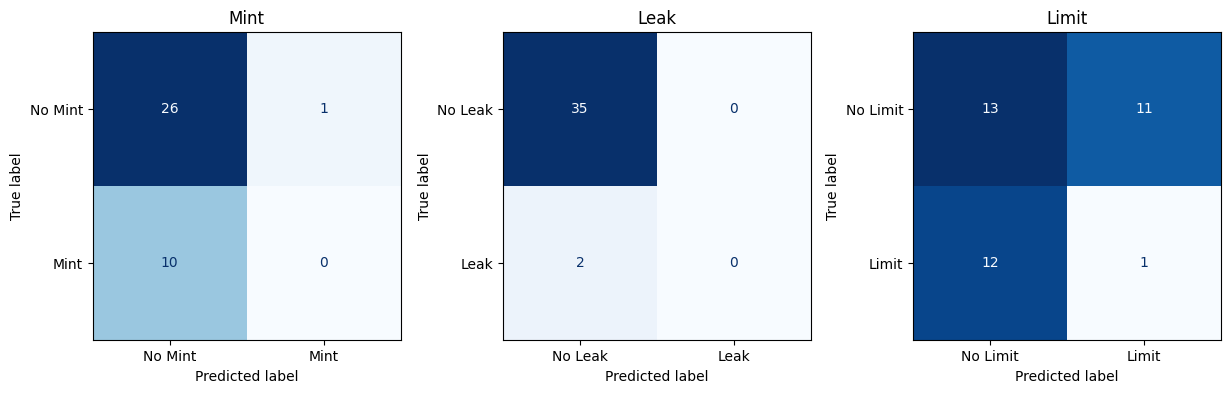

In [12]:
dataset = load_data(mode='txn')[0]
loader = DataLoader(dataset, batch_size=128, shuffle=True)
ground_df = pd.read_csv('groundtruth.csv', index_col=0)
label_cols = ground_df.columns.tolist()
y_true, y_pred, _ = val_model(model, loader)

plot_confusion_matrix(y_true, y_pred, label_cols)

              precision    recall  f1-score   support

        Mint       0.00      0.00      0.00        10
        Leak       0.00      0.00      0.00         2
       Limit       0.08      0.08      0.08        13

   micro avg       0.08      0.04      0.05        25
   macro avg       0.03      0.03      0.03        25
weighted avg       0.04      0.04      0.04        25
 samples avg       0.03      0.01      0.02        25



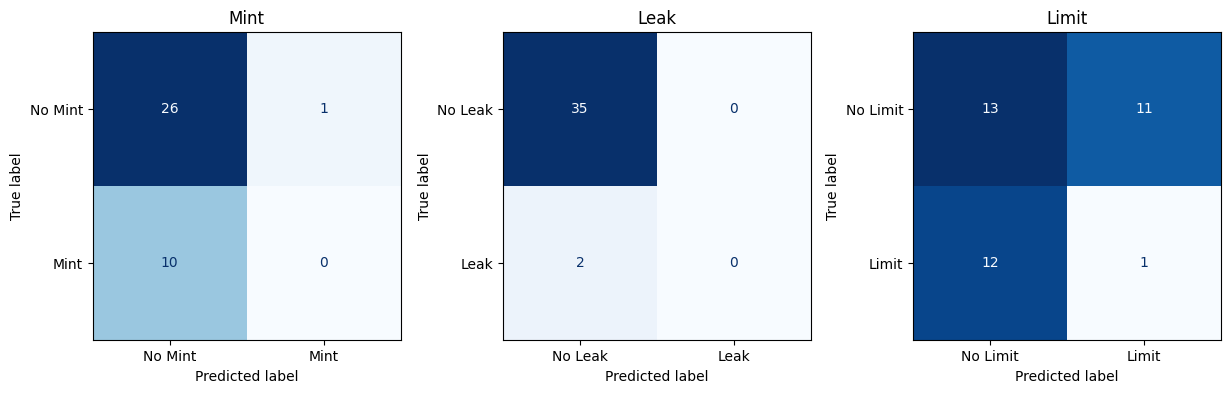

In [13]:
import torch
import json

# Load best parameters
with open("txn_best_params.json", "r") as f:
    best_params = json.load(f)

# Get input and output channels (assuming they are consistent with training)
dataset_info, in_channels, label_cols = load_data(mode='txn')
out_channels = len(label_cols)

# Initialize the model with the loaded parameters
loaded_model = GCN(in_channels=in_channels, hidden=best_params['hidden_dim'], out_channels=out_channels, dropout=best_params['dropout'])

# Load the state dictionary
loaded_model.load_state_dict(torch.load("txn_model.pth"))

thresholds = best_params['thresholds']
# Assuming 'loader' and 'thresholds' are already defined from previous cells
y_true, y_pred, _ = val_model(loaded_model, loader, thresholds)

plot_confusion_matrix(y_true, y_pred, label_cols)

## Control Flow

In [14]:
import torch
from torch_geometric.loader import DataLoader

model, thresholds = get_trained_gcn_model(mode='cfg', save_path='.')

[I 2025-08-01 11:22:30,827] A new study created in memory with name: no-name-3ad742bb-1e97-4580-beb0-f579d2457906


Epoch: 1/24, Loss: 2.8813
Epoch: 2/24, Loss: 2.7328
Epoch: 3/24, Loss: 1.9684
Epoch: 4/24, Loss: 2.7975
Epoch: 5/24, Loss: 2.2435
Epoch: 6/24, Loss: 2.4420
Epoch: 7/24, Loss: 1.8166
Epoch: 8/24, Loss: 1.4447
Epoch: 9/24, Loss: 1.9544
Epoch: 10/24, Loss: 1.4996
Epoch: 11/24, Loss: 1.6356
Epoch: 12/24, Loss: 1.6402
Epoch: 13/24, Loss: 1.6740
Epoch: 14/24, Loss: 1.7945
Epoch: 15/24, Loss: 1.0424
Epoch: 16/24, Loss: 1.7076
Epoch: 17/24, Loss: 1.7120
Epoch: 18/24, Loss: 1.5859
Epoch: 19/24, Loss: 1.2822
Epoch: 20/24, Loss: 1.4446
Epoch: 21/24, Loss: 1.1192
Epoch: 22/24, Loss: 1.3732
Epoch: 23/24, Loss: 1.3682
Epoch: 24/24, Loss: 1.6089
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.01, Best f1 = 0.5581395348837209


[I 2025-08-01 11:22:44,612] Trial 0 finished with value: 0.3278904832591127 and parameters: {'hidden_dim': 145, 'lr': 0.00022668578134491446, 'dropout': 0.2865814676519362, 'batch_size': 101, 'epochs': 24}. Best is trial 0 with value: 0.3278904832591127.


Epoch: 1/50, Loss: 13.1741
Epoch: 2/50, Loss: 11.2895
Epoch: 3/50, Loss: 9.2644
Epoch: 4/50, Loss: 6.3653
Epoch: 5/50, Loss: 5.2444
Epoch: 6/50, Loss: 3.5804
Epoch: 7/50, Loss: 2.8007
Epoch: 8/50, Loss: 2.8030
Epoch: 9/50, Loss: 2.3864
Epoch: 10/50, Loss: 2.6302
Epoch: 11/50, Loss: 3.1436
Epoch: 12/50, Loss: 3.8803
Epoch: 13/50, Loss: 3.8082
Epoch: 14/50, Loss: 4.1642
Epoch: 15/50, Loss: 3.5502
Epoch: 16/50, Loss: 3.3537
Epoch: 17/50, Loss: 3.3034
Epoch: 18/50, Loss: 3.7568
Epoch: 19/50, Loss: 2.8493
Epoch: 20/50, Loss: 2.1567
Epoch: 21/50, Loss: 1.9067
Epoch: 22/50, Loss: 2.0479
Epoch: 23/50, Loss: 1.6969
Epoch: 24/50, Loss: 1.9980
Epoch: 25/50, Loss: 0.8646
Epoch: 26/50, Loss: 1.9216
Epoch: 27/50, Loss: 2.4509
Epoch: 28/50, Loss: 2.2583
Epoch: 29/50, Loss: 2.2089
Epoch: 30/50, Loss: 1.8961
Epoch: 31/50, Loss: 1.0663
Epoch: 32/50, Loss: 1.2664
Epoch: 33/50, Loss: 1.4309
Epoch: 34/50, Loss: 1.8586
Epoch: 35/50, Loss: 1.5063
Epoch: 36/50, Loss: 1.6512
Epoch: 37/50, Loss: 1.6205
Epoch: 3

[I 2025-08-01 11:23:23,788] Trial 1 finished with value: 0.047619047619047616 and parameters: {'hidden_dim': 207, 'lr': 0.00036838157958667426, 'dropout': 0.5801943071511906, 'batch_size': 73, 'epochs': 50}. Best is trial 0 with value: 0.3278904832591127.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/24, Loss: 4.4761
Epoch: 2/24, Loss: 5.4746
Epoch: 3/24, Loss: 3.8213
Epoch: 4/24, Loss: 4.5648
Epoch: 5/24, Loss: 3.8414
Epoch: 6/24, Loss: 2.5273
Epoch: 7/24, Loss: 1.9078
Epoch: 8/24, Loss: 1.4057
Epoch: 9/24, Loss: 1.2394
Epoch: 10/24, Loss: 1.7142
Epoch: 11/24, Loss: 0.6881
Epoch: 12/24, Loss: 0.5498
Epoch: 13/24, Loss: 0.9479
Epoch: 14/24, Loss: 0.9343
Epoch: 15/24, Loss: 1.8132
Epoch: 16/24, Loss: 0.9601
Epoch: 17/24, Loss: 1.3389
Epoch: 18/24, Loss: 0.9283
Epoch: 19/24, Loss: 0.9007
Epoch: 20/24, Loss: 0.6926
Epoch: 21/24, Loss: 0.8458
Epoch: 22/24, Loss: 0.5344
Epoch: 23/24, Loss: 0.3887
Epoch: 24/24, Loss: 1.4314
Label 0: Best threshold = 0.01, Best f1 = 0.5263157894736842
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:23:33,848] Trial 2 finished with value: 0.28972431077694233 and parameters: {'hidden_dim': 141, 'lr': 9.397454039937665e-05, 'dropout': 0.24764748188413482, 'batch_size': 27, 'epochs': 24}. Best is trial 0 with value: 0.3278904832591127.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 4.8846
Epoch: 2/43, Loss: 3.6750
Epoch: 3/43, Loss: 3.7192
Epoch: 4/43, Loss: 3.1179
Epoch: 5/43, Loss: 3.1010
Epoch: 6/43, Loss: 2.7970
Epoch: 7/43, Loss: 2.7263
Epoch: 8/43, Loss: 2.5268
Epoch: 9/43, Loss: 2.0883
Epoch: 10/43, Loss: 2.2042
Epoch: 11/43, Loss: 2.0249
Epoch: 12/43, Loss: 2.6212
Epoch: 13/43, Loss: 2.0424
Epoch: 14/43, Loss: 1.7863
Epoch: 15/43, Loss: 1.3674
Epoch: 16/43, Loss: 1.5418
Epoch: 17/43, Loss: 2.1703
Epoch: 18/43, Loss: 1.3038
Epoch: 19/43, Loss: 1.8837
Epoch: 20/43, Loss: 1.7315
Epoch: 21/43, Loss: 1.6316
Epoch: 22/43, Loss: 1.4432
Epoch: 23/43, Loss: 1.2127
Epoch: 24/43, Loss: 1.8546
Epoch: 25/43, Loss: 1.6479
Epoch: 26/43, Loss: 1.8294
Epoch: 27/43, Loss: 2.2865
Epoch: 28/43, Loss: 1.8486
Epoch: 29/43, Loss: 1.9293
Epoch: 30/43, Loss: 1.7290
Epoch: 31/43, Loss: 0.8864
Epoch: 32/43, Loss: 1.3152
Epoch: 33/43, Loss: 2.0307
Epoch: 34/43, Loss: 2.0319
Epoch: 35/43, Loss: 1.4673
Epoch: 36/43, Loss

[I 2025-08-01 11:24:35,835] Trial 3 finished with value: 0.3059030063638359 and parameters: {'hidden_dim': 229, 'lr': 7.920766074614461e-05, 'dropout': 0.6149267891116781, 'batch_size': 60, 'epochs': 43}. Best is trial 0 with value: 0.3278904832591127.


Label 2: Best threshold = 0.01, Best f1 = 0.5306122448979592
Epoch: 1/36, Loss: 13.5594
Epoch: 2/36, Loss: 8.6420
Epoch: 3/36, Loss: 8.3081
Epoch: 4/36, Loss: 5.4519
Epoch: 5/36, Loss: 9.0719
Epoch: 6/36, Loss: 8.0090
Epoch: 7/36, Loss: 6.4300
Epoch: 8/36, Loss: 6.8497
Epoch: 9/36, Loss: 9.1301
Epoch: 10/36, Loss: 4.2112
Epoch: 11/36, Loss: 6.3977
Epoch: 12/36, Loss: 7.2261
Epoch: 13/36, Loss: 7.7063
Epoch: 14/36, Loss: 6.7580
Epoch: 15/36, Loss: 5.3812
Epoch: 16/36, Loss: 7.0537
Epoch: 17/36, Loss: 4.8355
Epoch: 18/36, Loss: 5.6955
Epoch: 19/36, Loss: 5.5256
Epoch: 20/36, Loss: 5.8425
Epoch: 21/36, Loss: 4.0767
Epoch: 22/36, Loss: 4.7226
Epoch: 23/36, Loss: 4.7431
Epoch: 24/36, Loss: 3.5366
Epoch: 25/36, Loss: 4.7009
Epoch: 26/36, Loss: 5.5435
Epoch: 27/36, Loss: 5.3837
Epoch: 28/36, Loss: 3.5875
Epoch: 29/36, Loss: 5.5117
Epoch: 30/36, Loss: 4.4595
Epoch: 31/36, Loss: 6.4320
Epoch: 32/36, Loss: 3.9257
Epoch: 33/36, Loss: 5.9130
Epoch: 34/36, Loss: 4.6217
Epoch: 35/36, Loss: 4.1492
Ep

[I 2025-08-01 11:24:39,946] Trial 4 finished with value: 0.17391304347826086 and parameters: {'hidden_dim': 35, 'lr': 7.885744579936096e-05, 'dropout': 0.6853423296084422, 'batch_size': 22, 'epochs': 36}. Best is trial 0 with value: 0.3278904832591127.


Label 2: Best threshold = 0.01, Best f1 = 0.5217391304347826
Epoch: 1/40, Loss: 1.8372
Epoch: 2/40, Loss: 3.1057
Epoch: 3/40, Loss: 1.3546
Epoch: 4/40, Loss: 2.0233
Epoch: 5/40, Loss: 1.4863
Epoch: 6/40, Loss: 1.2309
Epoch: 7/40, Loss: 1.4238
Epoch: 8/40, Loss: 1.2704
Epoch: 9/40, Loss: 1.3911
Epoch: 10/40, Loss: 1.2379
Epoch: 11/40, Loss: 1.7459
Epoch: 12/40, Loss: 1.6650
Epoch: 13/40, Loss: 1.3400
Epoch: 14/40, Loss: 1.6136
Epoch: 15/40, Loss: 1.2782
Epoch: 16/40, Loss: 2.0274
Epoch: 17/40, Loss: 1.2716
Epoch: 18/40, Loss: 1.3648
Epoch: 19/40, Loss: 1.0338
Epoch: 20/40, Loss: 1.1020
Epoch: 21/40, Loss: 1.0126
Epoch: 22/40, Loss: 1.2796
Epoch: 23/40, Loss: 1.7063
Epoch: 24/40, Loss: 1.2046
Epoch: 25/40, Loss: 1.1188
Epoch: 26/40, Loss: 1.5155
Epoch: 27/40, Loss: 1.5131
Epoch: 28/40, Loss: 1.0956
Epoch: 29/40, Loss: 1.5003
Epoch: 30/40, Loss: 1.2199
Epoch: 31/40, Loss: 1.4742
Epoch: 32/40, Loss: 1.5733
Epoch: 33/40, Loss: 1.4431
Epoch: 34/40, Loss: 0.8244
Epoch: 35/40, Loss: 0.7733
Epo

[I 2025-08-01 11:24:56,358] Trial 5 finished with value: 0.10822510822510822 and parameters: {'hidden_dim': 126, 'lr': 7.937569721613466e-05, 'dropout': 0.25260128208832155, 'batch_size': 75, 'epochs': 40}. Best is trial 0 with value: 0.3278904832591127.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/25, Loss: 4.7011
Epoch: 2/25, Loss: 11.8462
Epoch: 3/25, Loss: 11.1326
Epoch: 4/25, Loss: 9.2485
Epoch: 5/25, Loss: 5.8112
Epoch: 6/25, Loss: 2.3991
Epoch: 7/25, Loss: 3.5789
Epoch: 8/25, Loss: 4.9557
Epoch: 9/25, Loss: 3.7783
Epoch: 10/25, Loss: 2.3759
Epoch: 11/25, Loss: 1.6615
Epoch: 12/25, Loss: 2.2340
Epoch: 13/25, Loss: 2.8329
Epoch: 14/25, Loss: 2.3785
Epoch: 15/25, Loss: 2.3546
Epoch: 16/25, Loss: 1.9850
Epoch: 17/25, Loss: 1.4985
Epoch: 18/25, Loss: 0.9645
Epoch: 19/25, Loss: 1.2248
Epoch: 20/25, Loss: 1.4348
Epoch: 21/25, Loss: 1.3967
Epoch: 22/25, Loss: 1.5350
Epoch: 23/25, Loss: 1.3313
Epoch: 24/25, Loss: 1.0864
Epoch: 25/25, Loss: 0.7226
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:25:14,469] Trial 6 finished with value: 0.0 and parameters: {'hidden_dim': 162, 'lr': 0.0038305150278943817, 'dropout': 0.17864324959131297, 'batch_size': 163, 'epochs': 25}. Best is trial 0 with value: 0.3278904832591127.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/5, Loss: 10.4310
Epoch: 2/5, Loss: 9.7581
Epoch: 3/5, Loss: 10.5835
Epoch: 4/5, Loss: 8.7603
Epoch: 5/5, Loss: 8.5165
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:25:17,118] Trial 7 finished with value: 0.14184397163120568 and parameters: {'hidden_dim': 136, 'lr': 0.00010185134535645295, 'dropout': 0.6214104386414461, 'batch_size': 172, 'epochs': 5}. Best is trial 0 with value: 0.3278904832591127.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/27, Loss: 4.1583
Epoch: 2/27, Loss: 4.0723
Epoch: 3/27, Loss: 4.3609
Epoch: 4/27, Loss: 4.0226
Epoch: 5/27, Loss: 3.7366
Epoch: 6/27, Loss: 3.7831
Epoch: 7/27, Loss: 4.3422
Epoch: 8/27, Loss: 4.1815
Epoch: 9/27, Loss: 3.7713
Epoch: 10/27, Loss: 4.1976
Epoch: 11/27, Loss: 3.3346
Epoch: 12/27, Loss: 3.5831
Epoch: 13/27, Loss: 3.7745
Epoch: 14/27, Loss: 4.0371
Epoch: 15/27, Loss: 4.4331
Epoch: 16/27, Loss: 3.4906
Epoch: 17/27, Loss: 3.8294
Epoch: 18/27, Loss: 3.3550
Epoch: 19/27, Loss: 3.1454
Epoch: 20/27, Loss: 3.7562
Epoch: 21/27, Loss: 3.3626
Epoch: 22/27, Loss: 3.4712
Epoch: 23/27, Loss: 3.2958
Epoch: 24/27, Loss: 3.6856
Epoch: 25/27, Loss: 2.8264
Epoch: 26/27, Loss: 2.8806
Epoch: 27/27, Loss: 2.9467
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:25:25,484] Trial 8 finished with value: 0.0 and parameters: {'hidden_dim': 94, 'lr': 3.662775872690863e-05, 'dropout': 0.3352318495009988, 'batch_size': 77, 'epochs': 27}. Best is trial 0 with value: 0.3278904832591127.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/23, Loss: 15.1610
Epoch: 2/23, Loss: 14.8769
Epoch: 3/23, Loss: 12.0770
Epoch: 4/23, Loss: 13.1063
Epoch: 5/23, Loss: 13.2461
Epoch: 6/23, Loss: 12.2580
Epoch: 7/23, Loss: 12.3217
Epoch: 8/23, Loss: 11.4460
Epoch: 9/23, Loss: 12.2650
Epoch: 10/23, Loss: 10.3485
Epoch: 11/23, Loss: 10.7032
Epoch: 12/23, Loss: 9.6286
Epoch: 13/23, Loss: 10.8955
Epoch: 14/23, Loss: 9.8197
Epoch: 15/23, Loss: 9.9584
Epoch: 16/23, Loss: 8.9121
Epoch: 17/23, Loss: 8.9551
Epoch: 18/23, Loss: 9.1174
Epoch: 19/23, Loss: 7.3146
Epoch: 20/23, Loss: 7.9653
Epoch: 21/23, Loss: 7.1327
Epoch: 22/23, Loss: 7.4015
Epoch: 23/23, Loss: 6.6553
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.01, Best f1 = 0.1111111111111111
Label 2: Best threshold = 0.0, Best f1 = 0.52


[I 2025-08-01 11:25:33,874] Trial 9 finished with value: 0.2072498029944838 and parameters: {'hidden_dim': 121, 'lr': 5.953611666303879e-05, 'dropout': 0.5889560544188458, 'batch_size': 88, 'epochs': 23}. Best is trial 0 with value: 0.3278904832591127.


Epoch: 1/12, Loss: 6.1946
Epoch: 2/12, Loss: 5.8886
Epoch: 3/12, Loss: 6.2731
Epoch: 4/12, Loss: 6.5206
Epoch: 5/12, Loss: 5.9579
Epoch: 6/12, Loss: 5.7195
Epoch: 7/12, Loss: 6.3030
Epoch: 8/12, Loss: 6.0341
Epoch: 9/12, Loss: 5.9535
Epoch: 10/12, Loss: 6.2834
Epoch: 11/12, Loss: 5.9929
Epoch: 12/12, Loss: 5.9111
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:25:36,422] Trial 10 finished with value: 0.12686868686868688 and parameters: {'hidden_dim': 54, 'lr': 2.769060488171143e-06, 'dropout': 0.046272316023007964, 'batch_size': 254, 'epochs': 12}. Best is trial 0 with value: 0.3278904832591127.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/37, Loss: 0.0742
Epoch: 2/37, Loss: 0.0383
Epoch: 3/37, Loss: 8.7635
Epoch: 4/37, Loss: 0.0306
Epoch: 5/37, Loss: 0.1392
Epoch: 6/37, Loss: 6.3743
Epoch: 7/37, Loss: 2.2864
Epoch: 8/37, Loss: 1.1004
Epoch: 9/37, Loss: 2.2686
Epoch: 10/37, Loss: 7.6959
Epoch: 11/37, Loss: 0.5168
Epoch: 12/37, Loss: 0.5106
Epoch: 13/37, Loss: 0.0000
Epoch: 14/37, Loss: 7.9158
Epoch: 15/37, Loss: 1.8269
Epoch: 16/37, Loss: 1.8931
Epoch: 17/37, Loss: 0.0064
Epoch: 18/37, Loss: 2.0898
Epoch: 19/37, Loss: 0.4085
Epoch: 20/37, Loss: 0.0000
Epoch: 21/37, Loss: 0.0117
Epoch: 22/37, Loss: 4.6036
Epoch: 23/37, Loss: 0.0000
Epoch: 24/37, Loss: 0.1100
Epoch: 25/37, Loss: 6.3361
Epoch: 26/37, Loss: 0.1207
Epoch: 27/37, Loss: 1.2235
Epoch: 28/37, Loss: 2.0961
Epoch: 29/37, Loss: 0.6304
Epoch: 30/37, Loss: 0.8739
Epoch: 31/37, Loss: 0.0004
Epoch: 32/37, Loss: 0.9098
Epoch: 33/37, Loss: 0.4157
Epoch: 34/37, Loss: 4.0477
Epoch: 35/37, Loss: 0.0782
Epoch: 36/37, Loss

[I 2025-08-01 11:26:23,218] Trial 11 finished with value: 0.36382428940568473 and parameters: {'hidden_dim': 248, 'lr': 0.0008451946789333913, 'dropout': 0.4707387021066448, 'batch_size': 36, 'epochs': 37}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.01, Best f1 = 0.5581395348837209
Epoch: 1/34, Loss: 0.6293
Epoch: 2/34, Loss: 20.0588
Epoch: 3/34, Loss: 0.3320
Epoch: 4/34, Loss: 34.9257
Epoch: 5/34, Loss: 2.6717
Epoch: 6/34, Loss: 21.5290
Epoch: 7/34, Loss: 61.7632
Epoch: 8/34, Loss: 3.2360
Epoch: 9/34, Loss: 0.0043
Epoch: 10/34, Loss: 0.1371
Epoch: 11/34, Loss: 0.4781
Epoch: 12/34, Loss: 6.7976
Epoch: 13/34, Loss: 0.3167
Epoch: 14/34, Loss: 2.1389
Epoch: 15/34, Loss: 11.3078
Epoch: 16/34, Loss: 0.9931
Epoch: 17/34, Loss: 1.6703
Epoch: 18/34, Loss: 0.0893
Epoch: 19/34, Loss: 1.9593
Epoch: 20/34, Loss: 1.3463
Epoch: 21/34, Loss: 7.1083
Epoch: 22/34, Loss: 0.8347
Epoch: 23/34, Loss: 0.0000
Epoch: 24/34, Loss: 0.0701
Epoch: 25/34, Loss: 0.3244
Epoch: 26/34, Loss: 0.0000
Epoch: 27/34, Loss: 0.2912
Epoch: 28/34, Loss: 0.3366
Epoch: 29/34, Loss: 0.6678
Epoch: 30/34, Loss: 0.5825
Epoch: 31/34, Loss: 0.0000
Epoch: 32/34, Loss: 0.6363
Epoch: 33/34, Loss: 1.8379
Epoch: 34/34, Loss: 0.0305
Label 0: Best threshold =

[I 2025-08-01 11:27:14,896] Trial 12 finished with value: 0.31868131868131866 and parameters: {'hidden_dim': 251, 'lr': 0.0020835659509546457, 'dropout': 0.44888501595590874, 'batch_size': 36, 'epochs': 34}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/18, Loss: 2.9170
Epoch: 2/18, Loss: 3.0626
Epoch: 3/18, Loss: 1.6825
Epoch: 4/18, Loss: 2.3346
Epoch: 5/18, Loss: 2.2765
Epoch: 6/18, Loss: 1.8144
Epoch: 7/18, Loss: 1.5447
Epoch: 8/18, Loss: 1.5066
Epoch: 9/18, Loss: 1.1624
Epoch: 10/18, Loss: 1.2475
Epoch: 11/18, Loss: 1.3502
Epoch: 12/18, Loss: 1.4217
Epoch: 13/18, Loss: 1.3580
Epoch: 14/18, Loss: 1.3173
Epoch: 15/18, Loss: 1.4625
Epoch: 16/18, Loss: 1.2165
Epoch: 17/18, Loss: 1.6130
Epoch: 18/18, Loss: 0.7453
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.01, Best f1 = 0.12903225806451613


[I 2025-08-01 11:27:31,419] Trial 13 finished with value: 0.22187254130605824 and parameters: {'hidden_dim': 189, 'lr': 0.0007663183390239756, 'dropout': 0.45507876396759, 'batch_size': 41, 'epochs': 18}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.01, Best f1 = 0.5365853658536586
Epoch: 1/32, Loss: 4.0496
Epoch: 2/32, Loss: 4.2203
Epoch: 3/32, Loss: 4.0224
Epoch: 4/32, Loss: 3.9634
Epoch: 5/32, Loss: 3.7293
Epoch: 6/32, Loss: 4.0445
Epoch: 7/32, Loss: 3.8327
Epoch: 8/32, Loss: 4.0690
Epoch: 9/32, Loss: 3.8676
Epoch: 10/32, Loss: 3.8426
Epoch: 11/32, Loss: 3.7604
Epoch: 12/32, Loss: 3.4944
Epoch: 13/32, Loss: 3.5585
Epoch: 14/32, Loss: 3.6318
Epoch: 15/32, Loss: 3.4381
Epoch: 16/32, Loss: 3.8517
Epoch: 17/32, Loss: 3.8048
Epoch: 18/32, Loss: 4.2207
Epoch: 19/32, Loss: 3.4476
Epoch: 20/32, Loss: 3.4514
Epoch: 21/32, Loss: 3.5367
Epoch: 22/32, Loss: 3.5101
Epoch: 23/32, Loss: 3.6116
Epoch: 24/32, Loss: 3.7299
Epoch: 25/32, Loss: 3.5045
Epoch: 26/32, Loss: 3.0663
Epoch: 27/32, Loss: 3.3089
Epoch: 28/32, Loss: 3.0813
Epoch: 29/32, Loss: 3.2975
Epoch: 30/32, Loss: 3.3166
Epoch: 31/32, Loss: 3.1462
Epoch: 32/32, Loss: 3.1883
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold =

[I 2025-08-01 11:27:58,022] Trial 14 finished with value: 0.11764705882352942 and parameters: {'hidden_dim': 182, 'lr': 1.035035766886998e-05, 'dropout': 0.36873842674790225, 'batch_size': 132, 'epochs': 32}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/15, Loss: 5.7496
Epoch: 2/15, Loss: 10.8604
Epoch: 3/15, Loss: 0.0334
Epoch: 4/15, Loss: 5.4371
Epoch: 5/15, Loss: 2.2944
Epoch: 6/15, Loss: 1.1242
Epoch: 7/15, Loss: 0.8270
Epoch: 8/15, Loss: 0.7119
Epoch: 9/15, Loss: 0.9012
Epoch: 10/15, Loss: 0.9285
Epoch: 11/15, Loss: 1.8382
Epoch: 12/15, Loss: 0.7430
Epoch: 13/15, Loss: 0.6013
Epoch: 14/15, Loss: 0.7218
Epoch: 15/15, Loss: 0.6324
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:28:03,340] Trial 15 finished with value: 0.0 and parameters: {'hidden_dim': 88, 'lr': 0.008009038290958075, 'dropout': 0.7653228913134063, 'batch_size': 16, 'epochs': 15}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/47, Loss: 3.7006
Epoch: 2/47, Loss: 1.4947
Epoch: 3/47, Loss: 1.5706
Epoch: 4/47, Loss: 1.8765
Epoch: 5/47, Loss: 1.8299
Epoch: 6/47, Loss: 1.7384
Epoch: 7/47, Loss: 1.1885
Epoch: 8/47, Loss: 1.0501
Epoch: 9/47, Loss: 1.0033
Epoch: 10/47, Loss: 1.1910
Epoch: 11/47, Loss: 1.1101
Epoch: 12/47, Loss: 1.2135
Epoch: 13/47, Loss: 0.7933
Epoch: 14/47, Loss: 0.6559
Epoch: 15/47, Loss: 0.7697
Epoch: 16/47, Loss: 0.8709
Epoch: 17/47, Loss: 0.9173
Epoch: 18/47, Loss: 0.8264
Epoch: 19/47, Loss: 0.5936
Epoch: 20/47, Loss: 0.6085
Epoch: 21/47, Loss: 0.7070
Epoch: 22/47, Loss: 0.7772
Epoch: 23/47, Loss: 0.6699
Epoch: 24/47, Loss: 0.6548
Epoch: 25/47, Loss: 0.5775
Epoch: 26/47, Loss: 0.8684
Epoch: 27/47, Loss: 0.6716
Epoch: 28/47, Loss: 0.6480
Epoch: 29/47, Loss: 0.6829
Epoch: 30/47, Loss: 0.5326
Epoch: 31/47, Loss: 0.6440
Epoch: 32/47, Loss: 0.8417
Epoch: 33/47, Loss: 0.6442
Epoch: 34/47, Loss: 0.6276
Epoch: 35/47, Loss: 0.4983
Epoch: 36/47, Loss

[I 2025-08-01 11:28:58,452] Trial 16 finished with value: 0.2809523809523809 and parameters: {'hidden_dim': 254, 'lr': 0.0005044281256394455, 'dropout': 0.08862993477131792, 'batch_size': 48, 'epochs': 47}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/32, Loss: 8.6588
Epoch: 2/32, Loss: 3.2361
Epoch: 3/32, Loss: 1.5511
Epoch: 4/32, Loss: 4.2418
Epoch: 5/32, Loss: 3.8155
Epoch: 6/32, Loss: 3.8659
Epoch: 7/32, Loss: 3.1199
Epoch: 8/32, Loss: 2.7233
Epoch: 9/32, Loss: 2.7286
Epoch: 10/32, Loss: 1.8269
Epoch: 11/32, Loss: 2.5674
Epoch: 12/32, Loss: 3.3735
Epoch: 13/32, Loss: 2.3802
Epoch: 14/32, Loss: 1.9882
Epoch: 15/32, Loss: 1.6139
Epoch: 16/32, Loss: 1.8638
Epoch: 17/32, Loss: 1.7112
Epoch: 18/32, Loss: 1.7969
Epoch: 19/32, Loss: 1.6429
Epoch: 20/32, Loss: 1.5518
Epoch: 21/32, Loss: 1.1355
Epoch: 22/32, Loss: 1.5915
Epoch: 23/32, Loss: 2.0665
Epoch: 24/32, Loss: 1.9579
Epoch: 25/32, Loss: 1.4921
Epoch: 26/32, Loss: 1.0605
Epoch: 27/32, Loss: 1.2043
Epoch: 28/32, Loss: 1.5785
Epoch: 29/32, Loss: 0.8183
Epoch: 30/32, Loss: 1.6141
Epoch: 31/32, Loss: 1.5546
Epoch: 32/32, Loss: 1.2530
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617


[I 2025-08-01 11:29:26,091] Trial 17 finished with value: 0.0 and parameters: {'hidden_dim': 220, 'lr': 0.0008853269207080416, 'dropout': 0.4937989237147376, 'batch_size': 113, 'epochs': 32}. Best is trial 11 with value: 0.36382428940568473.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/41, Loss: 3.3467
Epoch: 2/41, Loss: 2.1686
Epoch: 3/41, Loss: 1.2120
Epoch: 4/41, Loss: 0.6334
Epoch: 5/41, Loss: 0.6090
Epoch: 6/41, Loss: 2.3072
Epoch: 7/41, Loss: 1.9518
Epoch: 8/41, Loss: 0.4959
Epoch: 9/41, Loss: 1.6606
Epoch: 10/41, Loss: 2.6108
Epoch: 11/41, Loss: 0.4870
Epoch: 12/41, Loss: 1.9404
Epoch: 13/41, Loss: 2.1526
Epoch: 14/41, Loss: 0.7177
Epoch: 15/41, Loss: 2.0057
Epoch: 16/41, Loss: 0.4181
Epoch: 17/41, Loss: 0.9278
Epoch: 18/41, Loss: 3.3951
Epoch: 19/41, Loss: 2.3086
Epoch: 20/41, Loss: 1.4166
Epoch: 21/41, Loss: 3.5871
Epoch: 22/41, Loss: 0.8457
Epoch: 23/41, Loss: 0.6292
Epoch: 24/41, Loss: 0.8766
Epoch: 25/41, Loss: 1.4367
Epoch: 26/41, Loss: 1.3818
Epoch: 27/41, Loss: 2.0936
Epoch: 28/41, Loss: 0.5228
Epoch: 29/41, Loss: 0.4925
Epoch: 30/41, Loss: 0.3960
Epoch: 31/41, Loss: 0.5867
Epoch: 32/41, Loss: 0.2309
Epoch: 33/41, Loss: 1.8616
Epoch: 34/4

[I 2025-08-01 11:29:48,130] Trial 18 finished with value: 0.08585858585858586 and parameters: {'hidden_dim': 168, 'lr': 0.00032645424913383515, 'dropout': 0.3238672576567809, 'batch_size': 30, 'epochs': 41}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/19, Loss: 12.9417
Epoch: 2/19, Loss: 12.8740
Epoch: 3/19, Loss: 13.9158
Epoch: 4/19, Loss: 13.0481
Epoch: 5/19, Loss: 12.6861
Epoch: 6/19, Loss: 12.5036
Epoch: 7/19, Loss: 12.3057
Epoch: 8/19, Loss: 12.5626
Epoch: 9/19, Loss: 13.0052
Epoch: 10/19, Loss: 12.0927
Epoch: 11/19, Loss: 12.3028
Epoch: 12/19, Loss: 12.0258
Epoch: 13/19, Loss: 12.2507
Epoch: 14/19, Loss: 12.1492
Epoch: 15/19, Loss: 11.5442
Epoch: 16/19, Loss: 11.0085
Epoch: 17/19, Loss: 11.4267
Epoch: 18/19, Loss: 11.4690
Epoch: 19/19, Loss: 11.6777
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:29:53,849] Trial 19 finished with value: 0.32873348873348873 and parameters: {'hidden_dim': 97, 'lr': 1.947526517892608e-05, 'dropout': 0.14760282898456606, 'batch_size': 51, 'epochs': 19}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/9, Loss: 11.7362
Epoch: 2/9, Loss: 11.6729
Epoch: 3/9, Loss: 11.7192
Epoch: 4/9, Loss: 11.6908
Epoch: 5/9, Loss: 11.6038
Epoch: 6/9, Loss: 12.0331
Epoch: 7/9, Loss: 11.4768
Epoch: 8/9, Loss: 11.4605
Epoch: 9/9, Loss: 11.6323
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617


[I 2025-08-01 11:29:57,393] Trial 20 finished with value: 0.17254901960784316 and parameters: {'hidden_dim': 99, 'lr': 1.2847673862130332e-05, 'dropout': 0.14271042568586534, 'batch_size': 56, 'epochs': 9}. Best is trial 11 with value: 0.36382428940568473.


Label 1: Best threshold = 0.01, Best f1 = 0.11764705882352941
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/19, Loss: 4.3007
Epoch: 2/19, Loss: 4.1793
Epoch: 3/19, Loss: 3.5834
Epoch: 4/19, Loss: 3.9797
Epoch: 5/19, Loss: 3.8074
Epoch: 6/19, Loss: 3.7166
Epoch: 7/19, Loss: 4.2702
Epoch: 8/19, Loss: 4.0914
Epoch: 9/19, Loss: 4.3181
Epoch: 10/19, Loss: 3.7679
Epoch: 11/19, Loss: 3.4986
Epoch: 12/19, Loss: 3.7187
Epoch: 13/19, Loss: 3.8826
Epoch: 14/19, Loss: 3.3429
Epoch: 15/19, Loss: 3.6712
Epoch: 16/19, Loss: 3.3997
Epoch: 17/19, Loss: 3.9988
Epoch: 18/19, Loss: 3.7846
Epoch: 19/19, Loss: 4.0488
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:30:02,133] Trial 21 finished with value: 0.1642156862745098 and parameters: {'hidden_dim': 71, 'lr': 1.7268733194785116e-05, 'dropout': 0.2012887775801144, 'batch_size': 46, 'epochs': 19}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/21, Loss: 5.5512
Epoch: 2/21, Loss: 5.5098
Epoch: 3/21, Loss: 5.0638
Epoch: 4/21, Loss: 5.0949
Epoch: 5/21, Loss: 5.5564
Epoch: 6/21, Loss: 5.2942
Epoch: 7/21, Loss: 4.9586
Epoch: 8/21, Loss: 5.9899
Epoch: 9/21, Loss: 4.9055
Epoch: 10/21, Loss: 5.6649
Epoch: 11/21, Loss: 5.7187
Epoch: 12/21, Loss: 5.9404
Epoch: 13/21, Loss: 6.0578
Epoch: 14/21, Loss: 5.0423
Epoch: 15/21, Loss: 5.7285
Epoch: 16/21, Loss: 6.0327
Epoch: 17/21, Loss: 5.3080
Epoch: 18/21, Loss: 5.5844
Epoch: 19/21, Loss: 5.1681
Epoch: 20/21, Loss: 6.0400
Epoch: 21/21, Loss: 5.4679
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:30:09,994] Trial 22 finished with value: 0.315177304964539 and parameters: {'hidden_dim': 102, 'lr': 3.060841999287731e-06, 'dropout': 0.27971522776308166, 'batch_size': 98, 'epochs': 21}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/29, Loss: 5.0271
Epoch: 2/29, Loss: 5.9413
Epoch: 3/29, Loss: 5.2299
Epoch: 4/29, Loss: 5.2181
Epoch: 5/29, Loss: 3.8758
Epoch: 6/29, Loss: 15.5235
Epoch: 7/29, Loss: 4.7949
Epoch: 8/29, Loss: 5.4059
Epoch: 9/29, Loss: 8.9066
Epoch: 10/29, Loss: 6.1300
Epoch: 11/29, Loss: 12.1078
Epoch: 12/29, Loss: 6.1282
Epoch: 13/29, Loss: 5.5700
Epoch: 14/29, Loss: 7.7868
Epoch: 15/29, Loss: 6.3430
Epoch: 16/29, Loss: 5.2228
Epoch: 17/29, Loss: 5.4270
Epoch: 18/29, Loss: 5.2202
Epoch: 19/29, Loss: 6.0520
Epoch: 20/29, Loss: 4.7618
Epoch: 21/29, Loss: 6.2528
Epoch: 22/29, Loss: 6.3733
Epoch: 23/29, Loss: 5.2549
Epoch: 24/29, Loss: 5.6916
Epoch: 25/29, Loss: 7.9966
Epoch: 26/29, Loss: 4.7441
Epoch: 27/29, Loss: 5.7888
Epoch: 28/29, Loss: 5.3228
Epoch: 29/29, Loss: 6.5575
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:30:28,666] Trial 23 finished with value: 0.3186324786324786 and parameters: {'hidden_dim': 162, 'lr': 1.055084752633147e-06, 'dropout': 0.0010249547555050142, 'batch_size': 31, 'epochs': 29}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/16, Loss: 6.5086
Epoch: 2/16, Loss: 7.8254
Epoch: 3/16, Loss: 3.1267
Epoch: 4/16, Loss: 3.0704
Epoch: 5/16, Loss: 2.5113
Epoch: 6/16, Loss: 1.9365
Epoch: 7/16, Loss: 2.8034
Epoch: 8/16, Loss: 4.5031
Epoch: 9/16, Loss: 2.2654
Epoch: 10/16, Loss: 2.4527
Epoch: 11/16, Loss: 1.9774
Epoch: 12/16, Loss: 3.7780
Epoch: 13/16, Loss: 2.8796
Epoch: 14/16, Loss: 3.0007
Epoch: 15/16, Loss: 2.2422
Epoch: 16/16, Loss: 2.0539
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:30:31,796] Trial 24 finished with value: 0.17359000337723743 and parameters: {'hidden_dim': 64, 'lr': 0.00016309692951257804, 'dropout': 0.425089122646813, 'batch_size': 23, 'epochs': 16}. Best is trial 11 with value: 0.36382428940568473.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/37, Loss: 7.6686
Epoch: 2/37, Loss: 2.8322
Epoch: 3/37, Loss: 4.1458
Epoch: 4/37, Loss: 4.3044
Epoch: 5/37, Loss: 2.6316
Epoch: 6/37, Loss: 2.3495
Epoch: 7/37, Loss: 3.1689
Epoch: 8/37, Loss: 3.0306
Epoch: 9/37, Loss: 2.4285
Epoch: 10/37, Loss: 1.5563
Epoch: 11/37, Loss: 1.8370
Epoch: 12/37, Loss: 1.8783
Epoch: 13/37, Loss: 1.5965
Epoch: 14/37, Loss: 1.4875
Epoch: 15/37, Loss: 1.2543
Epoch: 16/37, Loss: 0.9580
Epoch: 17/37, Loss: 1.0102
Epoch: 18/37, Loss: 1.3137
Epoch: 19/37, Loss: 1.2782
Epoch: 20/37, Loss: 0.9457
Epoch: 21/37, Loss: 0.9449
Epoch: 22/37, Loss: 0.6167
Epoch: 23/37, Loss: 0.9820
Epoch: 24/37, Loss: 0.8852
Epoch: 25/37, Loss: 0.7559
Epoch: 26/37, Loss: 0.7486
Epoch: 27/37, Loss: 0.9421
Epoch: 28/37, Loss: 0.7503
Epoch: 29/37, Loss: 0.6304
Epoch: 30/37, Loss: 0.6818
Epoch: 31/37, Loss: 0.7273
Epoch: 32/37, Loss: 0.6865
Epoch: 33/37, Loss: 0.8091
Epoch: 34/37, Loss: 0.6674
Epoch: 35/37, Loss: 0.6416
Epoch: 36/37, Loss

[I 2025-08-01 11:31:01,523] Trial 25 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 201, 'lr': 0.001527370742536806, 'dropout': 0.11775653748222903, 'batch_size': 54, 'epochs': 37}. Best is trial 25 with value: 0.4222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/36, Loss: 3.0648
Epoch: 2/36, Loss: 7.2324
Epoch: 3/36, Loss: 5.3092
Epoch: 4/36, Loss: 5.4301
Epoch: 5/36, Loss: 4.4570
Epoch: 6/36, Loss: 2.5155
Epoch: 7/36, Loss: 2.4174
Epoch: 8/36, Loss: 2.7828
Epoch: 9/36, Loss: 2.4726
Epoch: 10/36, Loss: 2.2650
Epoch: 11/36, Loss: 1.8169
Epoch: 12/36, Loss: 1.4107
Epoch: 13/36, Loss: 1.2421
Epoch: 14/36, Loss: 2.0857
Epoch: 15/36, Loss: 2.0569
Epoch: 16/36, Loss: 1.4811
Epoch: 17/36, Loss: 1.4431
Epoch: 18/36, Loss: 1.3102
Epoch: 19/36, Loss: 1.2551
Epoch: 20/36, Loss: 1.0494
Epoch: 21/36, Loss: 1.2694
Epoch: 22/36, Loss: 1.4038
Epoch: 23/36, Loss: 0.7630
Epoch: 24/36, Loss: 0.8314
Epoch: 25/36, Loss: 0.9878
Epoch: 26/36, Loss: 0.9687
Epoch: 27/36, Loss: 0.8398
Epoch: 28/36, Loss: 0.7072
Epoch: 29/36, Loss: 0.8089
Epoch: 30/36, Loss: 0.9230
Epoch: 31/36, Loss: 0.6648
Epoch: 32/36, Loss: 0.5729
Epoch: 33/36, Loss: 0.6507
Epoch: 34/36, Loss: 0.8082
Epoch: 35/36, Loss: 0.5264
Epoch: 36/36, Loss

[I 2025-08-01 11:31:41,645] Trial 26 finished with value: 0.48340548340548334 and parameters: {'hidden_dim': 230, 'lr': 0.0016729176738360069, 'dropout': 0.1402138851670629, 'batch_size': 37, 'epochs': 36}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/37, Loss: 3.9035
Epoch: 2/37, Loss: 6.1963
Epoch: 3/37, Loss: 3.0629
Epoch: 4/37, Loss: 2.2906
Epoch: 5/37, Loss: 3.1107
Epoch: 6/37, Loss: 3.0933
Epoch: 7/37, Loss: 2.5884
Epoch: 8/37, Loss: 2.2984
Epoch: 9/37, Loss: 1.7282
Epoch: 10/37, Loss: 1.9623
Epoch: 11/37, Loss: 1.9606
Epoch: 12/37, Loss: 2.0080
Epoch: 13/37, Loss: 1.5093
Epoch: 14/37, Loss: 1.0113
Epoch: 15/37, Loss: 1.0906
Epoch: 16/37, Loss: 1.4871
Epoch: 17/37, Loss: 1.5883
Epoch: 18/37, Loss: 1.3854
Epoch: 19/37, Loss: 0.9629
Epoch: 20/37, Loss: 0.7120
Epoch: 21/37, Loss: 1.0486
Epoch: 22/37, Loss: 1.0047
Epoch: 23/37, Loss: 0.8411
Epoch: 24/37, Loss: 0.7363
Epoch: 25/37, Loss: 0.7658
Epoch: 26/37, Loss: 0.7589
Epoch: 27/37, Loss: 0.6247
Epoch: 28/37, Loss: 0.5723
Epoch: 29/37, Loss: 0.5513
Epoch: 30/37, Loss: 0.6926
Epoch: 31/37, Loss: 0.6653
Epoch: 32/37, Loss: 0.6036
Epoch: 33/37, Loss: 0.5104
Epoch: 34/37, Loss: 0.7041
Epoch: 35/37, Loss: 0.5832
Epo

[I 2025-08-01 11:32:22,894] Trial 27 finished with value: 0.3887147335423197 and parameters: {'hidden_dim': 231, 'lr': 0.0019080698987252946, 'dropout': 0.08101604063974001, 'batch_size': 38, 'epochs': 37}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.01, Best f1 = 0.5454545454545454
Epoch: 1/46, Loss: 0.0000
Epoch: 2/46, Loss: 5.5019
Epoch: 3/46, Loss: 0.0001
Epoch: 4/46, Loss: 2.4609
Epoch: 5/46, Loss: 4.5245
Epoch: 6/46, Loss: 0.4553
Epoch: 7/46, Loss: 10.6281
Epoch: 8/46, Loss: 2.1115
Epoch: 9/46, Loss: 0.0000
Epoch: 10/46, Loss: 0.6562
Epoch: 11/46, Loss: 0.0018
Epoch: 12/46, Loss: 0.8458
Epoch: 13/46, Loss: 0.0019
Epoch: 14/46, Loss: 0.3333
Epoch: 15/46, Loss: 0.4577
Epoch: 16/46, Loss: 0.8121
Epoch: 17/46, Loss: 2.3214
Epoch: 18/46, Loss: 0.6055
Epoch: 19/46, Loss: 0.0625
Epoch: 20/46, Loss: 0.6809
Epoch: 21/46, Loss: 0.5718
Epoch: 22/46, Loss: 0.8550
Epoch: 23/46, Loss: 0.3387
Epoch: 24/46, Loss: 0.0001
Epoch: 25/46, Loss: 0.9036
Epoch: 26/46, Loss: 0.0321
Epoch: 27/46, Loss: 1.4582
Epoch: 28/46, Loss: 0.6645
Epoch: 29/46, Loss: 1.0471
Epoch: 30/46, Loss: 0.5597
Epoch: 31/46, Loss: 0.6256
Epoch: 32/46, Loss: 3.6376
Epoch: 33/46, Loss: 0.4800
Epoch: 34/46, Loss: 0.7351
Epoch: 35/46, Loss: 0.4053
Ep

[I 2025-08-01 11:33:02,636] Trial 28 finished with value: 0.38655462184873945 and parameters: {'hidden_dim': 229, 'lr': 0.004022782689457481, 'dropout': 0.07572967738901393, 'batch_size': 18, 'epochs': 46}. Best is trial 26 with value: 0.48340548340548334.


Epoch: 1/38, Loss: 11.9835
Epoch: 2/38, Loss: 2.2252
Epoch: 3/38, Loss: 4.3701
Epoch: 4/38, Loss: 6.1969
Epoch: 5/38, Loss: 6.0669
Epoch: 6/38, Loss: 5.0296
Epoch: 7/38, Loss: 3.7569
Epoch: 8/38, Loss: 2.5667
Epoch: 9/38, Loss: 1.1015
Epoch: 10/38, Loss: 2.4379
Epoch: 11/38, Loss: 2.9289
Epoch: 12/38, Loss: 2.6694
Epoch: 13/38, Loss: 1.8625
Epoch: 14/38, Loss: 1.1017
Epoch: 15/38, Loss: 0.8898
Epoch: 16/38, Loss: 1.0921
Epoch: 17/38, Loss: 1.3377
Epoch: 18/38, Loss: 1.5675
Epoch: 19/38, Loss: 1.3625
Epoch: 20/38, Loss: 0.9380
Epoch: 21/38, Loss: 0.7907
Epoch: 22/38, Loss: 0.8617
Epoch: 23/38, Loss: 1.0109
Epoch: 24/38, Loss: 0.9484
Epoch: 25/38, Loss: 1.0848
Epoch: 26/38, Loss: 0.9303
Epoch: 27/38, Loss: 0.6734
Epoch: 28/38, Loss: 0.6361
Epoch: 29/38, Loss: 0.7368
Epoch: 30/38, Loss: 0.7652
Epoch: 31/38, Loss: 0.7717
Epoch: 32/38, Loss: 0.7416
Epoch: 33/38, Loss: 0.6022
Epoch: 34/38, Loss: 0.5871
Epoch: 35/38, Loss: 0.7326
Epoch: 36/38, Loss: 0.7095
Epoch: 37/38, Loss: 0.4844
Epoch: 38

[I 2025-08-01 11:33:37,776] Trial 29 finished with value: 0.3595959595959595 and parameters: {'hidden_dim': 202, 'lr': 0.0016266658059431779, 'dropout': 0.12200658331480291, 'batch_size': 39, 'epochs': 38}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.01, Best f1 = 0.5454545454545454
Epoch: 1/31, Loss: 4.4644
Epoch: 2/31, Loss: 64.2829
Epoch: 3/31, Loss: 24.8495
Epoch: 4/31, Loss: 5.9389
Epoch: 5/31, Loss: 9.0539
Epoch: 6/31, Loss: 7.9526
Epoch: 7/31, Loss: 5.1824
Epoch: 8/31, Loss: 3.6690
Epoch: 9/31, Loss: 2.2916
Epoch: 10/31, Loss: 1.0974
Epoch: 11/31, Loss: 1.2798
Epoch: 12/31, Loss: 1.2283
Epoch: 13/31, Loss: 1.0539
Epoch: 14/31, Loss: 0.7999
Epoch: 15/31, Loss: 0.7253
Epoch: 16/31, Loss: 0.6906
Epoch: 17/31, Loss: 0.6609
Epoch: 18/31, Loss: 0.6487
Epoch: 19/31, Loss: 0.6633
Epoch: 20/31, Loss: 0.6581
Epoch: 21/31, Loss: 0.6341
Epoch: 22/31, Loss: 0.5972
Epoch: 23/31, Loss: 0.5621
Epoch: 24/31, Loss: 0.5727
Epoch: 25/31, Loss: 0.5686
Epoch: 26/31, Loss: 0.5581
Epoch: 27/31, Loss: 0.5403
Epoch: 28/31, Loss: 0.5317
Epoch: 29/31, Loss: 0.5265
Epoch: 30/31, Loss: 0.5265
Epoch: 31/31, Loss: 0.5195
Label 0: Best threshold = 0.01, Best f1 = 0.7
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:34:18,522] Trial 30 finished with value: 0.27777777777777773 and parameters: {'hidden_dim': 234, 'lr': 0.009886598024341348, 'dropout': 0.007142385278963548, 'batch_size': 65, 'epochs': 31}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 6.9284
Epoch: 2/45, Loss: 3.9093
Epoch: 3/45, Loss: 0.1005
Epoch: 4/45, Loss: 2.1488
Epoch: 5/45, Loss: 7.2215
Epoch: 6/45, Loss: 0.4767
Epoch: 7/45, Loss: 0.3624
Epoch: 8/45, Loss: 0.3960
Epoch: 9/45, Loss: 1.2835
Epoch: 10/45, Loss: 0.7306
Epoch: 11/45, Loss: 0.7172
Epoch: 12/45, Loss: 1.2618
Epoch: 13/45, Loss: 0.6977
Epoch: 14/45, Loss: 0.7062
Epoch: 15/45, Loss: 0.7849
Epoch: 16/45, Loss: 0.5565
Epoch: 17/45, Loss: 0.8639
Epoch: 18/45, Loss: 0.5432
Epoch: 19/45, Loss: 0.3843
Epoch: 20/45, Loss: 0.5370
Epoch: 21/45, Loss: 0.7905
Epoch: 22/45, Loss: 0.5916
Epoch: 23/45, Loss: 0.5652
Epoch: 24/45, Loss: 0.5193
Epoch: 25/45, Loss: 0.4158
Epoch: 26/45, Loss: 0.4085
Epoch: 27/45, Loss: 0.4264
Epoch: 28/45, Loss: 0.4141
Epoch: 29/45, Loss: 0.1437
Epoch: 30/45, Loss: 0.5951
Epoch: 31/45, Loss: 0.4032
Epoch: 32/45, Loss: 0.4083
Epoch: 33/45, Loss: 0.4260
Epoch: 34/45, Loss: 0.6770
Epoch: 35/45, Loss: 0.3731
Epoch: 36/45, Loss

[I 2025-08-01 11:34:51,212] Trial 31 finished with value: 0.45396825396825397 and parameters: {'hidden_dim': 213, 'lr': 0.004296908991374618, 'dropout': 0.056393001578074975, 'batch_size': 16, 'epochs': 45}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/44, Loss: 2.3608
Epoch: 2/44, Loss: 6.8042
Epoch: 3/44, Loss: 4.9077
Epoch: 4/44, Loss: 2.3882
Epoch: 5/44, Loss: 2.3482
Epoch: 6/44, Loss: 2.6440
Epoch: 7/44, Loss: 2.1370
Epoch: 8/44, Loss: 0.7425
Epoch: 9/44, Loss: 1.1636
Epoch: 10/44, Loss: 1.3487
Epoch: 11/44, Loss: 1.0451
Epoch: 12/44, Loss: 1.0175
Epoch: 13/44, Loss: 0.5358
Epoch: 14/44, Loss: 0.7413
Epoch: 15/44, Loss: 0.6028
Epoch: 16/44, Loss: 0.7328
Epoch: 17/44, Loss: 0.8121
Epoch: 18/44, Loss: 0.4400
Epoch: 19/44, Loss: 0.6362
Epoch: 20/44, Loss: 0.9582
Epoch: 21/44, Loss: 0.8786
Epoch: 22/44, Loss: 0.6226
Epoch: 23/44, Loss: 0.7332
Epoch: 24/44, Loss: 0.4558
Epoch: 25/44, Loss: 0.5503
Epoch: 26/44, Loss: 0.8311
Epoch: 27/44, Loss: 1.1332
Epoch: 28/44, Loss: 0.5602
Epoch: 29/44, Loss: 0.4521
Epoch: 30/44, Loss: 0.3639
Epoch: 31/44, Loss: 0.7719
Epoch: 32/44, Loss: 0.3725
Epoch: 33/44, Loss: 0.4079
Epoch: 34/44, Loss: 0.7490
Epoch: 35/44, Loss: 0.3773
Epoch: 36/44, Loss

[I 2025-08-01 11:35:25,198] Trial 32 finished with value: 0.18351648351648353 and parameters: {'hidden_dim': 211, 'lr': 0.0021141592481140636, 'dropout': 0.20573983711841104, 'batch_size': 23, 'epochs': 44}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/50, Loss: 6.1919
Epoch: 2/50, Loss: 9.0580
Epoch: 3/50, Loss: 6.9100
Epoch: 4/50, Loss: 4.5336
Epoch: 5/50, Loss: 0.6411
Epoch: 6/50, Loss: 2.7429
Epoch: 7/50, Loss: 2.1559
Epoch: 8/50, Loss: 2.4362
Epoch: 9/50, Loss: 0.7331
Epoch: 10/50, Loss: 1.2658
Epoch: 11/50, Loss: 1.0744
Epoch: 12/50, Loss: 0.6885
Epoch: 13/50, Loss: 0.5493
Epoch: 14/50, Loss: 0.8480
Epoch: 15/50, Loss: 0.5716
Epoch: 16/50, Loss: 0.4196
Epoch: 17/50, Loss: 0.4792
Epoch: 18/50, Loss: 0.9493
Epoch: 19/50, Loss: 0.4016
Epoch: 20/50, Loss: 0.8122
Epoch: 21/50, Loss: 0.3521
Epoch: 22/50, Loss: 0.6204
Epoch: 23/50, Loss: 0.5396
Epoch: 24/50, Loss: 0.5999
Epoch: 25/50, Loss: 0.5794
Epoch: 26/50, Loss: 0.4180
Epoch: 27/50, Loss: 0.4447
Epoch: 28/50, Loss: 0.7093
Epoch: 29/50, Loss: 0.5002
Epoch: 30/50, Loss: 0.5993
Epoch: 31/50, Loss: 0.4711
Epoch: 32/50, Loss: 0.3662
Epoch: 33/50, Loss: 0.3626
Epoch: 34/50, Loss: 0.8377
Epoch: 35/50, Loss: 0.7554
Epoch: 36/50, Loss

[I 2025-08-01 11:36:01,154] Trial 33 finished with value: 0.3844393592677345 and parameters: {'hidden_dim': 198, 'lr': 0.004319810659995463, 'dropout': 0.0646979644951175, 'batch_size': 27, 'epochs': 50}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.01, Best f1 = 0.5217391304347826
Epoch: 1/40, Loss: 7.9574
Epoch: 2/40, Loss: 5.6028
Epoch: 3/40, Loss: 5.0093
Epoch: 4/40, Loss: 6.5629
Epoch: 5/40, Loss: 3.9512
Epoch: 6/40, Loss: 4.2458
Epoch: 7/40, Loss: 3.7227
Epoch: 8/40, Loss: 2.3041
Epoch: 9/40, Loss: 0.4527
Epoch: 10/40, Loss: 0.9908
Epoch: 11/40, Loss: 0.9559
Epoch: 12/40, Loss: 0.9114
Epoch: 13/40, Loss: 0.5915
Epoch: 14/40, Loss: 1.0473
Epoch: 15/40, Loss: 0.7918
Epoch: 16/40, Loss: 0.7204
Epoch: 17/40, Loss: 1.2042
Epoch: 18/40, Loss: 0.7782
Epoch: 19/40, Loss: 0.6698
Epoch: 20/40, Loss: 1.0091
Epoch: 21/40, Loss: 0.6849
Epoch: 22/40, Loss: 0.8138
Epoch: 23/40, Loss: 0.4472
Epoch: 24/40, Loss: 0.4026
Epoch: 25/40, Loss: 0.7005
Epoch: 26/40, Loss: 0.4815
Epoch: 27/40, Loss: 0.4723
Epoch: 28/40, Loss: 0.4593
Epoch: 29/40, Loss: 1.0629
Epoch: 30/40, Loss: 0.5295
Epoch: 31/40, Loss: 0.9903
Epoch: 32/40, Loss: 1.0002
Epoch: 33/40, Loss: 0.5749
Epoch: 34/40, Loss: 0.6375
Epoch: 35/40, Loss: 0.7561
Epo

[I 2025-08-01 11:36:33,757] Trial 34 finished with value: 0.43274853801169594 and parameters: {'hidden_dim': 235, 'lr': 0.0018243574175158825, 'dropout': 0.1172838502139931, 'batch_size': 20, 'epochs': 40}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/40, Loss: 17.9463
Epoch: 2/40, Loss: 5.6104
Epoch: 3/40, Loss: 21.7381
Epoch: 4/40, Loss: 8.5553
Epoch: 5/40, Loss: 2.1973
Epoch: 6/40, Loss: 4.4952
Epoch: 7/40, Loss: 2.6362
Epoch: 8/40, Loss: 1.4368
Epoch: 9/40, Loss: 1.0294
Epoch: 10/40, Loss: 1.4825
Epoch: 11/40, Loss: 0.8491
Epoch: 12/40, Loss: 0.8482
Epoch: 13/40, Loss: 0.5489
Epoch: 14/40, Loss: 0.5254
Epoch: 15/40, Loss: 0.6090
Epoch: 16/40, Loss: 0.4962
Epoch: 17/40, Loss: 0.6486
Epoch: 18/40, Loss: 0.6441
Epoch: 19/40, Loss: 0.5263
Epoch: 20/40, Loss: 0.5920
Epoch: 21/40, Loss: 0.6693
Epoch: 22/40, Loss: 0.5600
Epoch: 23/40, Loss: 0.5462
Epoch: 24/40, Loss: 0.5401
Epoch: 25/40, Loss: 0.5449
Epoch: 26/40, Loss: 0.5582
Epoch: 27/40, Loss: 0.4662
Epoch: 28/40, Loss: 0.4524
Epoch: 29/40, Loss: 0.4431
Epoch: 30/40, Loss: 0.5322
Epoch: 31/40, Loss: 0.4289
Epoch: 32/40, Loss: 0.4705
Epoch: 33/40, Loss: 0.5568
Epoch: 34/40, Loss: 0.5745
Epoch: 35/40, Loss: 0.4819
Ep

[I 2025-08-01 11:37:02,221] Trial 35 finished with value: 0.43274853801169594 and parameters: {'hidden_dim': 213, 'lr': 0.0059293063722818925, 'dropout': 0.2266630851789067, 'batch_size': 20, 'epochs': 40}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/41, Loss: 43.7037
Epoch: 2/41, Loss: 15.5174
Epoch: 3/41, Loss: 3.5085
Epoch: 4/41, Loss: 7.0997
Epoch: 5/41, Loss: 1.1091
Epoch: 6/41, Loss: 0.1596
Epoch: 7/41, Loss: 0.0061
Epoch: 8/41, Loss: 0.6934
Epoch: 9/41, Loss: 0.7366
Epoch: 10/41, Loss: 0.2166
Epoch: 11/41, Loss: 0.6323
Epoch: 12/41, Loss: 0.0017
Epoch: 13/41, Loss: 0.6923
Epoch: 14/41, Loss: 0.2542
Epoch: 15/41, Loss: 0.5206
Epoch: 16/41, Loss: 0.6577
Epoch: 17/41, Loss: 0.4354
Epoch: 18/41, Loss: 0.7712
Epoch: 19/41, Loss: 0.6107
Epoch: 20/41, Loss: 1.0502
Epoch: 21/41, Loss: 0.5272
Epoch: 22/41, Loss: 0.6993
Epoch: 23/41, Loss: 0.5627
Epoch: 24/41, Loss: 0.5277
Epoch: 25/41, Loss: 0.6042
Epoch: 26/41, Loss: 0.7773
Epoch: 27/41, Loss: 0.3778
Epoch: 28/41, Loss: 0.0004
Epoch: 29/41, Loss: 1.8300
Epoch: 30/41, Loss: 0.5794
Epoch: 31/41, Loss: 0.5480
Epoch: 32/41, Loss: 0.7188
Epoch: 33/41, Loss: 0.4895
Epoch: 34/41, Loss: 0.3435
Epoch: 35/41, Loss: 0.4832
Ep

[I 2025-08-01 11:37:29,579] Trial 36 finished with value: 0.27314814814814814 and parameters: {'hidden_dim': 217, 'lr': 0.005649963715593049, 'dropout': 0.23371846216047285, 'batch_size': 18, 'epochs': 41}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/44, Loss: 23.1459
Epoch: 2/44, Loss: 39.3511
Epoch: 3/44, Loss: 10.4580
Epoch: 4/44, Loss: 9.9417
Epoch: 5/44, Loss: 3.3074
Epoch: 6/44, Loss: 2.1047
Epoch: 7/44, Loss: 2.2747
Epoch: 8/44, Loss: 1.9123
Epoch: 9/44, Loss: 1.3632
Epoch: 10/44, Loss: 0.7752
Epoch: 11/44, Loss: 0.6704
Epoch: 12/44, Loss: 0.5650
Epoch: 13/44, Loss: 0.5952
Epoch: 14/44, Loss: 0.5997
Epoch: 15/44, Loss: 0.5332
Epoch: 16/44, Loss: 0.5241
Epoch: 17/44, Loss: 0.5097
Epoch: 18/44, Loss: 0.6462
Epoch: 19/44, Loss: 0.4095
Epoch: 20/44, Loss: 0.5002
Epoch: 21/44, Loss: 0.5900
Epoch: 22/44, Loss: 0.6541
Epoch: 23/44, Loss: 0.4074
Epoch: 24/44, Loss: 0.5179
Epoch: 25/44, Loss: 0.4697
Epoch: 26/44, Loss: 0.5157
Epoch: 27/44, Loss: 0.3979
Epoch: 28/44, Loss: 0.4403
Epoch: 29/44, Loss: 0.5045
Epoch: 30/44, Loss: 0.4385
Epoch: 31/44, Loss: 0.4625
Epoch: 32/44, Loss: 0.5266
Epoch: 33/44, Loss: 0.4476
Epoch: 34/44, Loss: 0.4787
Epoch: 35/44, Loss: 0.4837
Epoch: 36/44, L

[I 2025-08-01 11:38:04,495] Trial 37 finished with value: 0.4456140350877193 and parameters: {'hidden_dim': 238, 'lr': 0.006255416652045776, 'dropout': 0.16415423540846077, 'batch_size': 19, 'epochs': 44}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/46, Loss: 23.6023
Epoch: 2/46, Loss: 8.1450
Epoch: 3/46, Loss: 3.9522
Epoch: 4/46, Loss: 2.6873
Epoch: 5/46, Loss: 2.3861
Epoch: 6/46, Loss: 0.4146
Epoch: 7/46, Loss: 0.6688
Epoch: 8/46, Loss: 1.3923
Epoch: 9/46, Loss: 0.5985
Epoch: 10/46, Loss: 0.8993
Epoch: 11/46, Loss: 0.4797
Epoch: 12/46, Loss: 0.7033
Epoch: 13/46, Loss: 0.4545
Epoch: 14/46, Loss: 0.5022
Epoch: 15/46, Loss: 0.6823
Epoch: 16/46, Loss: 0.6571
Epoch: 17/46, Loss: 0.5295
Epoch: 18/46, Loss: 0.4785
Epoch: 19/46, Loss: 0.8427
Epoch: 20/46, Loss: 1.8473
Epoch: 21/46, Loss: 0.6579
Epoch: 22/46, Loss: 0.5817
Epoch: 23/46, Loss: 0.4824
Epoch: 24/46, Loss: 1.2662
Epoch: 25/46, Loss: 0.8973
Epoch: 26/46, Loss: 0.7939
Epoch: 27/46, Loss: 0.7457
Epoch: 28/46, Loss: 0.7492
Epoch: 29/46, Loss: 0.8649
Epoch: 30/46, Loss: 0.9821
Epoch: 31/46, Loss: 0.4623
Epoch: 32/46, Loss: 0.6067
Epoch: 33/46, Loss: 0.4136
Epoch: 34/46, Loss: 0.8338
Epoch: 35/46, Loss: 0.6369
Epoch: 36/46, Los

[I 2025-08-01 11:38:41,286] Trial 38 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 247, 'lr': 0.0031070285955834306, 'dropout': 0.18099425797923355, 'batch_size': 16, 'epochs': 46}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 3.4326
Epoch: 2/43, Loss: 3.5560
Epoch: 3/43, Loss: 3.9965
Epoch: 4/43, Loss: 4.9809
Epoch: 5/43, Loss: 1.1521
Epoch: 6/43, Loss: 4.0079
Epoch: 7/43, Loss: 2.4513
Epoch: 8/43, Loss: 1.0959
Epoch: 9/43, Loss: 1.4012
Epoch: 10/43, Loss: 1.6715
Epoch: 11/43, Loss: 0.8167
Epoch: 12/43, Loss: 1.2730
Epoch: 13/43, Loss: 1.6728
Epoch: 14/43, Loss: 1.2245
Epoch: 15/43, Loss: 1.6369
Epoch: 16/43, Loss: 0.9882
Epoch: 17/43, Loss: 1.2782
Epoch: 18/43, Loss: 0.5178
Epoch: 19/43, Loss: 0.3532
Epoch: 20/43, Loss: 0.8732
Epoch: 21/43, Loss: 1.3968
Epoch: 22/43, Loss: 0.8552
Epoch: 23/43, Loss: 0.6208
Epoch: 24/43, Loss: 0.8233
Epoch: 25/43, Loss: 0.7158
Epoch: 26/43, Loss: 0.4430
Epoch: 27/43, Loss: 0.9006
Epoch: 28/43, Loss: 1.3919
Epoch: 29/43, Loss: 0.4542
Epoch: 30/43, Loss: 0.5183
Epoch: 31/43, Loss: 0.5417
Epoch: 32/43, Loss: 0.8597
Epoch: 33/43, Loss: 0.6354
Epoch: 34/43, Loss: 0.9049
Epoch: 35/43, Loss: 0.3922
Epoch: 36/43, Loss

[I 2025-08-01 11:39:16,804] Trial 39 finished with value: 0.2457912457912458 and parameters: {'hidden_dim': 238, 'lr': 0.001110877389246287, 'dropout': 0.2893231272202118, 'batch_size': 20, 'epochs': 43}. Best is trial 26 with value: 0.48340548340548334.


Epoch: 1/49, Loss: 7.3614
Epoch: 2/49, Loss: 4.3234
Epoch: 3/49, Loss: 1.0532
Epoch: 4/49, Loss: 2.0649
Epoch: 5/49, Loss: 0.6683
Epoch: 6/49, Loss: 0.5457
Epoch: 7/49, Loss: 3.7790
Epoch: 8/49, Loss: 1.6667
Epoch: 9/49, Loss: 2.2418
Epoch: 10/49, Loss: 1.9317
Epoch: 11/49, Loss: 0.5156
Epoch: 12/49, Loss: 0.5099
Epoch: 13/49, Loss: 1.6739
Epoch: 14/49, Loss: 1.4099
Epoch: 15/49, Loss: 1.4481
Epoch: 16/49, Loss: 0.3319
Epoch: 17/49, Loss: 0.5019
Epoch: 18/49, Loss: 1.4504
Epoch: 19/49, Loss: 0.4226
Epoch: 20/49, Loss: 0.9411
Epoch: 21/49, Loss: 0.3513
Epoch: 22/49, Loss: 0.6790
Epoch: 23/49, Loss: 0.5105
Epoch: 24/49, Loss: 0.4366
Epoch: 25/49, Loss: 0.7337
Epoch: 26/49, Loss: 0.4096
Epoch: 27/49, Loss: 0.4800
Epoch: 28/49, Loss: 0.6392
Epoch: 29/49, Loss: 0.3872
Epoch: 30/49, Loss: 0.7872
Epoch: 31/49, Loss: 0.3403
Epoch: 32/49, Loss: 0.4754
Epoch: 33/49, Loss: 0.4704
Epoch: 34/49, Loss: 0.5576
Epoch: 35/49, Loss: 0.5536
Epoch: 36/49, Loss: 0.6506
Epoch: 37/49, Loss: 0.4261
Epoch: 38/

[I 2025-08-01 11:39:41,690] Trial 40 finished with value: 0.4238095238095238 and parameters: {'hidden_dim': 176, 'lr': 0.0004749722340966127, 'dropout': 0.03360957713526204, 'batch_size': 25, 'epochs': 49}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/41, Loss: 19.5716
Epoch: 2/41, Loss: 4.6110
Epoch: 3/41, Loss: 10.5743
Epoch: 4/41, Loss: 1.8811
Epoch: 5/41, Loss: 5.2292
Epoch: 6/41, Loss: 4.3043
Epoch: 7/41, Loss: 1.6414
Epoch: 8/41, Loss: 1.5672
Epoch: 9/41, Loss: 0.9429
Epoch: 10/41, Loss: 1.0734
Epoch: 11/41, Loss: 0.7932
Epoch: 12/41, Loss: 0.6720
Epoch: 13/41, Loss: 0.6171
Epoch: 14/41, Loss: 0.5530
Epoch: 15/41, Loss: 0.7029
Epoch: 16/41, Loss: 0.5794
Epoch: 17/41, Loss: 0.5560
Epoch: 18/41, Loss: 0.6167
Epoch: 19/41, Loss: 0.5715
Epoch: 20/41, Loss: 0.5740
Epoch: 21/41, Loss: 0.5516
Epoch: 22/41, Loss: 0.6777
Epoch: 23/41, Loss: 0.4683
Epoch: 24/41, Loss: 0.5372
Epoch: 25/41, Loss: 0.4916
Epoch: 26/41, Loss: 0.5709
Epoch: 27/41, Loss: 0.4242
Epoch: 28/41, Loss: 0.4831
Epoch: 29/41, Loss: 0.5727
Epoch: 30/41, Loss: 0.4580
Epoch: 31/41, Loss: 0.4793
Epoch: 32/41, Loss: 0.4076
Epoch: 33/41, Loss: 0.4274
Epoch: 34/41, Loss: 0.5002
Epoch: 35/41, Loss: 0.5469
E

[I 2025-08-01 11:40:11,087] Trial 41 finished with value: 0.40660474716202266 and parameters: {'hidden_dim': 221, 'lr': 0.006503535051313859, 'dropout': 0.16147804968846796, 'batch_size': 20, 'epochs': 41}. Best is trial 26 with value: 0.48340548340548334.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/44, Loss: 8.7717
Epoch: 2/44, Loss: 5.7279
Epoch: 3/44, Loss: 1.5505
Epoch: 4/44, Loss: 4.7440
Epoch: 5/44, Loss: 6.3316
Epoch: 6/44, Loss: 2.3645
Epoch: 7/44, Loss: 2.5701
Epoch: 8/44, Loss: 2.3296
Epoch: 9/44, Loss: 1.1790
Epoch: 10/44, Loss: 1.0114
Epoch: 11/44, Loss: 1.2443
Epoch: 12/44, Loss: 0.5704
Epoch: 13/44, Loss: 0.7804
Epoch: 14/44, Loss: 0.8066
Epoch: 15/44, Loss: 0.7102
Epoch: 16/44, Loss: 1.0384
Epoch: 17/44, Loss: 0.7051
Epoch: 18/44, Loss: 0.6350
Epoch: 19/44, Loss: 0.5737
Epoch: 20/44, Loss: 0.6174
Epoch: 21/44, Loss: 0.6052
Epoch: 22/44, Loss: 0.4926
Epoch: 23/44, Loss: 0.5453
Epoch: 24/44, Loss: 0.5909
Epoch: 25/44, Loss: 0.4491
Epoch: 26/44, Loss: 0.5033
Epoch: 27/44, Loss: 0.4631
Epoch: 28/44, Loss: 0.4294
Epoch: 29/44, Loss: 0.4808
Epoch: 30/44, Loss: 0.6075
Epoch: 31/44, Loss: 0.5400
Epoch: 32/44, Loss: 0.4802
Epoch: 33/44, Loss: 0.5335
Epoch: 34/44, Loss: 0.5736
Epoch: 35/44, Loss: 0.4417
Epoc

[I 2025-08-01 11:40:45,732] Trial 42 finished with value: 0.5839080459770115 and parameters: {'hidden_dim': 242, 'lr': 0.0030002052029459536, 'dropout': 0.10785518784385609, 'batch_size': 20, 'epochs': 44}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5517241379310345
Epoch: 1/44, Loss: 23.3463
Epoch: 2/44, Loss: 10.9949
Epoch: 3/44, Loss: 5.3786
Epoch: 4/44, Loss: 4.2293
Epoch: 5/44, Loss: 2.3760
Epoch: 6/44, Loss: 2.3889
Epoch: 7/44, Loss: 1.2474
Epoch: 8/44, Loss: 0.8368
Epoch: 9/44, Loss: 1.0081
Epoch: 10/44, Loss: 0.9816
Epoch: 11/44, Loss: 1.5208
Epoch: 12/44, Loss: 1.0035
Epoch: 13/44, Loss: 0.8809
Epoch: 14/44, Loss: 0.7227
Epoch: 15/44, Loss: 1.0221
Epoch: 16/44, Loss: 0.5733
Epoch: 17/44, Loss: 1.3994
Epoch: 18/44, Loss: 0.7725
Epoch: 19/44, Loss: 1.0627
Epoch: 20/44, Loss: 0.6431
Epoch: 21/44, Loss: 0.5099
Epoch: 22/44, Loss: 1.0557
Epoch: 23/44, Loss: 0.4165
Epoch: 24/44, Loss: 1.4627
Epoch: 25/44, Loss: 0.8140
Epoch: 26/44, Loss: 0.6024
Epoch: 27/44, Loss: 0.5751
Epoch: 28/44, Loss: 0.6964
Epoch: 29/44, Loss: 0.7377
Epoch: 30/44, Loss: 0.6475
Epoch: 31/44, Loss: 0.4820
Epoch: 32/44, Loss: 0.6916
Epoch: 33/44, Loss: 0.5667
Epoch: 34/44, Loss: 0.4695
Epoch: 35/44, Loss: 0.5246
E

[I 2025-08-01 11:41:35,339] Trial 43 finished with value: 0.10317460317460318 and parameters: {'hidden_dim': 238, 'lr': 0.0035935297999306883, 'dropout': 0.10214153733166056, 'batch_size': 30, 'epochs': 44}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/46, Loss: 0.3560
Epoch: 2/46, Loss: 12.2010
Epoch: 3/46, Loss: 1.2198
Epoch: 4/46, Loss: 0.0000
Epoch: 5/46, Loss: 0.5939
Epoch: 6/46, Loss: 0.4793
Epoch: 7/46, Loss: 10.9656
Epoch: 8/46, Loss: 0.4527
Epoch: 9/46, Loss: 7.1020
Epoch: 10/46, Loss: 3.0320
Epoch: 11/46, Loss: 11.2858
Epoch: 12/46, Loss: 2.4931
Epoch: 13/46, Loss: 0.0014
Epoch: 14/46, Loss: 3.2172
Epoch: 15/46, Loss: 0.5694
Epoch: 16/46, Loss: 4.5075
Epoch: 17/46, Loss: 9.8569
Epoch: 18/46, Loss: 0.7839
Epoch: 19/46, Loss: 5.8608
Epoch: 20/46, Loss: 0.6004
Epoch: 21/46, Loss: 0.1590
Epoch: 22/46, Loss: 0.0010
Epoch: 23/46, Loss: 0.7493
Epoch: 24/46, Loss: 1.6987
Epoch: 25/46, Loss: 1.7573
Epoch: 26/46, Loss: 0.2483
Epoch: 27/46, Loss: 0.8636
Epoch: 28/46, Loss: 0.6801
Epoch: 29/46, Loss: 2.1561
Epoch: 30/46, Loss: 0.0000
Epoch: 31/46, Loss: 1.5142
Epoch: 32/46, Loss: 0.6101
Epoch: 33/46, Loss: 0.1752
Epoch: 34/46, Loss: 0.2833
Epoch: 35/46, Loss: 0.5678
Epoch: 36/46, L

[I 2025-08-01 11:42:15,793] Trial 44 finished with value: 0.44909020518776616 and parameters: {'hidden_dim': 243, 'lr': 0.0027308877736794824, 'dropout': 0.0376506946018096, 'batch_size': 18, 'epochs': 46}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5853658536585366
Epoch: 1/47, Loss: 7.5850
Epoch: 2/47, Loss: 5.7638
Epoch: 3/47, Loss: 9.4507
Epoch: 4/47, Loss: 1.8126
Epoch: 5/47, Loss: 3.1319
Epoch: 6/47, Loss: 1.8740
Epoch: 7/47, Loss: 0.6953
Epoch: 8/47, Loss: 3.6404
Epoch: 9/47, Loss: 0.8194
Epoch: 10/47, Loss: 1.2960
Epoch: 11/47, Loss: 0.5749
Epoch: 12/47, Loss: 0.6470
Epoch: 13/47, Loss: 0.5798
Epoch: 14/47, Loss: 0.1904
Epoch: 15/47, Loss: 0.4056
Epoch: 16/47, Loss: 0.4046
Epoch: 17/47, Loss: 0.5317
Epoch: 18/47, Loss: 0.7435
Epoch: 19/47, Loss: 1.1095
Epoch: 20/47, Loss: 0.6930
Epoch: 21/47, Loss: 0.5065
Epoch: 22/47, Loss: 0.7142
Epoch: 23/47, Loss: 0.6321
Epoch: 24/47, Loss: 0.3269
Epoch: 25/47, Loss: 0.4505
Epoch: 26/47, Loss: 0.4781
Epoch: 27/47, Loss: 0.8744
Epoch: 28/47, Loss: 0.5612
Epoch: 29/47, Loss: 0.4547
Epoch: 30/47, Loss: 0.6140
Epoch: 31/47, Loss: 0.3912
Epoch: 32/47, Loss: 0.6812
Epoch: 33/47, Loss: 0.3215
Epoch: 34/47, Loss: 0.4453
Epoch: 35/47, Loss: 0.8749
Epo

[I 2025-08-01 11:43:03,356] Trial 45 finished with value: 0.43079922027290446 and parameters: {'hidden_dim': 243, 'lr': 0.0026496886899829695, 'dropout': 0.043952166279686775, 'batch_size': 16, 'epochs': 47}. Best is trial 42 with value: 0.5839080459770115.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.01, Best f1 = 0.5555555555555556
Epoch: 1/35, Loss: 2.0072
Epoch: 2/35, Loss: 3.1509
Epoch: 3/35, Loss: 4.5324
Epoch: 4/35, Loss: 1.9806
Epoch: 5/35, Loss: 0.6760
Epoch: 6/35, Loss: 0.3607
Epoch: 7/35, Loss: 0.4620
Epoch: 8/35, Loss: 0.6446
Epoch: 9/35, Loss: 0.6677
Epoch: 10/35, Loss: 1.0908
Epoch: 11/35, Loss: 0.9339
Epoch: 12/35, Loss: 0.6275
Epoch: 13/35, Loss: 0.6098
Epoch: 14/35, Loss: 0.9360
Epoch: 15/35, Loss: 0.4463
Epoch: 16/35, Loss: 0.2745
Epoch: 17/35, Loss: 0.8150
Epoch: 18/35, Loss: 0.5137
Epoch: 19/35, Loss: 0.7156
Epoch: 20/35, Loss: 0.4338
Epoch: 21/35, Loss: 0.3631
Epoch: 22/35, Loss: 0.4137
Epoch: 23/35, Loss: 0.4735
Epoch: 24/35, Loss: 0.6974
Epoch: 25/35, Loss: 0.4265
Epoch: 26/35, Loss: 0.7398
Epoch: 27/35, Loss: 0.4314
Epoch: 28/35, Loss: 0.8386
Epoch: 29/35, Loss: 0.5151
Epoch: 30/35, Loss: 0.8195
Epoch: 31/35, Loss: 0.5565
Epoch: 32/35, Loss: 0.5492
Epoch: 33/35, Loss: 0.6

[I 2025-08-01 11:43:41,392] Trial 46 finished with value: 0.443859649122807 and parameters: {'hidden_dim': 256, 'lr': 0.001204759757729487, 'dropout': 0.025851786376818953, 'batch_size': 25, 'epochs': 35}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/43, Loss: 0.0000
Epoch: 2/43, Loss: 0.0000
Epoch: 3/43, Loss: 0.9126
Epoch: 4/43, Loss: 9.8259
Epoch: 5/43, Loss: 1.4754
Epoch: 6/43, Loss: 0.2425
Epoch: 7/43, Loss: 1.2487
Epoch: 8/43, Loss: 0.6285
Epoch: 9/43, Loss: 0.2057
Epoch: 10/43, Loss: 0.5894
Epoch: 11/43, Loss: 0.5937
Epoch: 12/43, Loss: 2.2956
Epoch: 13/43, Loss: 0.9216
Epoch: 14/43, Loss: 0.5410
Epoch: 15/43, Loss: 0.4020
Epoch: 16/43, Loss: 0.3056
Epoch: 17/43, Loss: 0.5427
Epoch: 18/43, Loss: 3.0942
Epoch: 19/43, Loss: 0.5847
Epoch: 20/43, Loss: 0.4804
Epoch: 21/43, Loss: 0.4834
Epoch: 22/43, Loss: 0.5517
Epoch: 23/43, Loss: 3.9669
Epoch: 24/43, Loss: 0.1056
Epoch: 25/43, Loss: 0.5394
Epoch: 26/43, Loss: 0.5294
Epoch: 27/43, Loss: 0.5554
Epoch: 28/43, Loss: 0.4851
Epoch: 29/43, Loss: 0.5070
Epoch: 30/43, Loss: 0.5659
Epoch: 31/43, Loss: 0.1129
Epoch: 32/43, Loss: 0.5324
Epoch: 33/43, Loss: 0.0417
Epoch: 34/43, Loss: 0.5250
Epoch: 35/43, Loss: 0.5465
Epoc

[I 2025-08-01 11:44:18,256] Trial 47 finished with value: 0.3532163742690058 and parameters: {'hidden_dim': 224, 'lr': 0.009814250879449688, 'dropout': 0.1843500142463051, 'batch_size': 18, 'epochs': 43}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5263157894736842
Epoch: 1/49, Loss: 3.0995
Epoch: 2/49, Loss: 11.0580
Epoch: 3/49, Loss: 7.6574
Epoch: 4/49, Loss: 3.3412
Epoch: 5/49, Loss: 4.1923
Epoch: 6/49, Loss: 1.8647
Epoch: 7/49, Loss: 2.3718
Epoch: 8/49, Loss: 3.7741
Epoch: 9/49, Loss: 1.6459
Epoch: 10/49, Loss: 2.0722
Epoch: 11/49, Loss: 0.3969
Epoch: 12/49, Loss: 0.7622
Epoch: 13/49, Loss: 1.3323
Epoch: 14/49, Loss: 1.3283
Epoch: 15/49, Loss: 0.4111
Epoch: 16/49, Loss: 0.4715
Epoch: 17/49, Loss: 0.5905
Epoch: 18/49, Loss: 0.6143
Epoch: 19/49, Loss: 0.3979
Epoch: 20/49, Loss: 0.4653
Epoch: 21/49, Loss: 0.4776
Epoch: 22/49, Loss: 0.4453
Epoch: 23/49, Loss: 0.3077
Epoch: 24/49, Loss: 0.8478
Epoch: 25/49, Loss: 0.5896
Epoch: 26/49, Loss: 0.3278
Epoch: 27/49, Loss: 0.3039
Epoch: 28/49, Loss: 0.4298
Epoch: 29/49, Loss: 0.4980
Epoch: 30/49, Loss: 0.5357
Epoch: 31/49, Loss: 0.4552
Epoch: 32/49, Loss: 0.9365
Epoch: 33/49, Loss: 0.6552
Epoch: 34/49, Loss: 0.5664
Epoch: 35/49, Loss: 0.5940
Ep

[I 2025-08-01 11:44:57,341] Trial 48 finished with value: 0.296354852876592 and parameters: {'hidden_dim': 187, 'lr': 0.004691618835449302, 'dropout': 0.5346182919519664, 'batch_size': 33, 'epochs': 49}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5333333333333333
Epoch: 1/48, Loss: 3.3464
Epoch: 2/48, Loss: 3.6977
Epoch: 3/48, Loss: 4.1654
Epoch: 4/48, Loss: 3.9341
Epoch: 5/48, Loss: 2.4878
Epoch: 6/48, Loss: 3.5752
Epoch: 7/48, Loss: 1.6815
Epoch: 8/48, Loss: 2.8705
Epoch: 9/48, Loss: 2.6541
Epoch: 10/48, Loss: 0.6955
Epoch: 11/48, Loss: 1.6687
Epoch: 12/48, Loss: 1.2465
Epoch: 13/48, Loss: 1.0344
Epoch: 14/48, Loss: 1.0026
Epoch: 15/48, Loss: 0.7251
Epoch: 16/48, Loss: 1.1366
Epoch: 17/48, Loss: 1.4262
Epoch: 18/48, Loss: 2.0734
Epoch: 19/48, Loss: 1.8001
Epoch: 20/48, Loss: 0.7215
Epoch: 21/48, Loss: 1.1777
Epoch: 22/48, Loss: 0.6096
Epoch: 23/48, Loss: 0.7997
Epoch: 24/48, Loss: 2.3309
Epoch: 25/48, Loss: 0.9538
Epoch: 26/48, Loss: 0.9278
Epoch: 27/48, Loss: 1.9696
Epoch: 28/48, Loss: 0.8437
Epoch: 29/48, Loss: 0.9031
Epoch: 30/48, Loss: 0.7157
Epoch: 31/48, Loss: 1.0221
Epoch: 32/48, Loss: 0.8653
Epoch: 33/48, Loss: 0.5112
Epoch: 34/48, Loss: 1.0461
Epoch: 35/48, Loss: 0.6108
Epo

[I 2025-08-01 11:45:19,160] Trial 49 finished with value: 0.11393939393939394 and parameters: {'hidden_dim': 148, 'lr': 0.0006114008518149847, 'dropout': 0.26441181682896864, 'batch_size': 26, 'epochs': 48}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 1.3878
Epoch: 2/45, Loss: 1.1286
Epoch: 3/45, Loss: 1.5443
Epoch: 4/45, Loss: 0.7818
Epoch: 5/45, Loss: 0.7075
Epoch: 6/45, Loss: 1.0164
Epoch: 7/45, Loss: 0.6535
Epoch: 8/45, Loss: 0.7574
Epoch: 9/45, Loss: 1.3392
Epoch: 10/45, Loss: 0.5862
Epoch: 11/45, Loss: 0.7765
Epoch: 12/45, Loss: 0.9489
Epoch: 13/45, Loss: 0.8492
Epoch: 14/45, Loss: 0.5761
Epoch: 15/45, Loss: 0.5849
Epoch: 16/45, Loss: 0.5411
Epoch: 17/45, Loss: 0.3850
Epoch: 18/45, Loss: 0.6579
Epoch: 19/45, Loss: 0.4948
Epoch: 20/45, Loss: 0.6695
Epoch: 21/45, Loss: 0.5637
Epoch: 22/45, Loss: 0.6228
Epoch: 23/45, Loss: 0.5877
Epoch: 24/45, Loss: 0.4310
Epoch: 25/45, Loss: 0.7227
Epoch: 26/45, Loss: 0.6567
Epoch: 27/45, Loss: 0.8260
Epoch: 28/45, Loss: 0.4392
Epoch: 29/45, Loss: 0.5375
Epoch: 30/45, Loss: 0.7472
Epoch: 31/45, Loss: 0.6952
Epoch: 32/45, Loss: 0.6149
Epoch: 33/45, Loss: 0.7873
Epoch: 34/45, Loss: 0.4887
Epoch: 35/45, Loss: 0.5146
Epoch: 36/45, Loss

[I 2025-08-01 11:46:04,356] Trial 50 finished with value: 0.3951515151515152 and parameters: {'hidden_dim': 245, 'lr': 0.0002281332957018507, 'dropout': 0.05569021295216539, 'batch_size': 22, 'epochs': 45}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5454545454545454
Epoch: 1/39, Loss: 3.8980
Epoch: 2/39, Loss: 1.4371
Epoch: 3/39, Loss: 2.0318
Epoch: 4/39, Loss: 1.0204
Epoch: 5/39, Loss: 0.6924
Epoch: 6/39, Loss: 1.5956
Epoch: 7/39, Loss: 1.4753
Epoch: 8/39, Loss: 1.3203
Epoch: 9/39, Loss: 1.5702
Epoch: 10/39, Loss: 0.9953
Epoch: 11/39, Loss: 1.5079
Epoch: 12/39, Loss: 0.7524
Epoch: 13/39, Loss: 1.2487
Epoch: 14/39, Loss: 0.9908
Epoch: 15/39, Loss: 0.4726
Epoch: 16/39, Loss: 0.4626
Epoch: 17/39, Loss: 0.9634
Epoch: 18/39, Loss: 0.8138
Epoch: 19/39, Loss: 0.9051
Epoch: 20/39, Loss: 0.6848
Epoch: 21/39, Loss: 0.7262
Epoch: 22/39, Loss: 0.2867
Epoch: 23/39, Loss: 0.8463
Epoch: 24/39, Loss: 0.4686
Epoch: 25/39, Loss: 0.5910
Epoch: 26/39, Loss: 0.7624
Epoch: 27/39, Loss: 0.9141
Epoch: 28/39, Loss: 0.5916
Epoch: 29/39, Loss: 0.5024
Epoch: 30/39, Loss: 0.3450
Epoch: 31/39, Loss: 0.8449
Epoch: 32/39, Loss: 0.4909
Epoch: 33/39, Loss: 0.4303
Epoch: 34/39, Loss: 0.6666
Epoch: 35/39, Loss: 0.5134
Epo

[I 2025-08-01 11:46:48,722] Trial 51 finished with value: 0.42589118198874293 and parameters: {'hidden_dim': 253, 'lr': 0.001099340640681056, 'dropout': 0.018371515162969816, 'batch_size': 25, 'epochs': 39}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5853658536585366
Epoch: 1/26, Loss: 0.0089
Epoch: 2/26, Loss: 4.0991
Epoch: 3/26, Loss: 3.3402
Epoch: 4/26, Loss: 3.4497
Epoch: 5/26, Loss: 43.3062
Epoch: 6/26, Loss: 16.8738
Epoch: 7/26, Loss: 1.7639
Epoch: 8/26, Loss: 9.6954
Epoch: 9/26, Loss: 3.0243
Epoch: 10/26, Loss: 0.0834
Epoch: 11/26, Loss: 0.4381
Epoch: 12/26, Loss: 4.2790
Epoch: 13/26, Loss: 1.5342
Epoch: 14/26, Loss: 0.0091
Epoch: 15/26, Loss: 1.1334
Epoch: 16/26, Loss: 0.5503
Epoch: 17/26, Loss: 0.0572
Epoch: 18/26, Loss: 0.3133
Epoch: 19/26, Loss: 0.5908
Epoch: 20/26, Loss: 1.0635
Epoch: 21/26, Loss: 0.0614
Epoch: 22/26, Loss: 0.3181
Epoch: 23/26, Loss: 0.4223
Epoch: 24/26, Loss: 1.0430
Epoch: 25/26, Loss: 0.6054
Epoch: 26/26, Loss: 0.0015
Label 0: Best threshold = 0.01, Best f1 = 0.5128205128205128
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:47:20,396] Trial 52 finished with value: 0.29914529914529914 and parameters: {'hidden_dim': 252, 'lr': 0.0027850098685848357, 'dropout': 0.13835496966183874, 'batch_size': 18, 'epochs': 26}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/35, Loss: 2.3076
Epoch: 2/35, Loss: 0.7345
Epoch: 3/35, Loss: 4.2722
Epoch: 4/35, Loss: 2.8952
Epoch: 5/35, Loss: 2.6207
Epoch: 6/35, Loss: 2.3032
Epoch: 7/35, Loss: 1.2902
Epoch: 8/35, Loss: 1.4668
Epoch: 9/35, Loss: 1.0758
Epoch: 10/35, Loss: 1.1955
Epoch: 11/35, Loss: 1.3785
Epoch: 12/35, Loss: 0.7650
Epoch: 13/35, Loss: 1.0513
Epoch: 14/35, Loss: 1.1514
Epoch: 15/35, Loss: 0.5992
Epoch: 16/35, Loss: 1.2957
Epoch: 17/35, Loss: 0.6812
Epoch: 18/35, Loss: 0.8019
Epoch: 19/35, Loss: 0.5220
Epoch: 20/35, Loss: 1.3611
Epoch: 21/35, Loss: 0.5575
Epoch: 22/35, Loss: 0.6017
Epoch: 23/35, Loss: 0.4479
Epoch: 24/35, Loss: 0.5148
Epoch: 25/35, Loss: 0.3564
Epoch: 26/35, Loss: 0.4637
Epoch: 27/35, Loss: 0.3590
Epoch: 28/35, Loss: 0.5095
Epoch: 29/35, Loss: 0.5144
Epoch: 30/35, Loss: 0.4207
Epoch: 31/35, Loss: 1.4290
Epoch: 32/35, Loss: 0.4808
Epoch: 33/35, Loss: 0.3047
Epoch: 34/35, Loss: 0.4874
Epoch: 35/35, Loss: 0.3846
Label 0: Best thre

[I 2025-08-01 11:48:06,581] Trial 53 finished with value: 0.3689839572192513 and parameters: {'hidden_dim': 256, 'lr': 0.0011159198123929094, 'dropout': 0.09302447197216052, 'batch_size': 28, 'epochs': 35}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/34, Loss: 14.8047
Epoch: 2/34, Loss: 1.4981
Epoch: 3/34, Loss: 3.6318
Epoch: 4/34, Loss: 4.1040
Epoch: 5/34, Loss: 0.8399
Epoch: 6/34, Loss: 1.8223
Epoch: 7/34, Loss: 2.4485
Epoch: 8/34, Loss: 1.9262
Epoch: 9/34, Loss: 1.1127
Epoch: 10/34, Loss: 1.1003
Epoch: 11/34, Loss: 0.7997
Epoch: 12/34, Loss: 0.8552
Epoch: 13/34, Loss: 0.7823
Epoch: 14/34, Loss: 0.8929
Epoch: 15/34, Loss: 0.9149
Epoch: 16/34, Loss: 0.5356
Epoch: 17/34, Loss: 0.5558
Epoch: 18/34, Loss: 0.7518
Epoch: 19/34, Loss: 0.9274
Epoch: 20/34, Loss: 0.5904
Epoch: 21/34, Loss: 0.5689
Epoch: 22/34, Loss: 0.8059
Epoch: 23/34, Loss: 0.7190
Epoch: 24/34, Loss: 0.4802
Epoch: 25/34, Loss: 0.5572
Epoch: 26/34, Loss: 0.3826
Epoch: 27/34, Loss: 0.7826
Epoch: 28/34, Loss: 0.5769
Epoch: 29/34, Loss: 0.5315
Epoch: 30/34, Loss: 0.4270
Epoch: 31/34, Loss: 0.9038
Epoch: 32/34, Loss: 0.6240
Epoch: 33/34, Loss: 0.6008
Epoch: 34/34, Loss: 0.4458
Label 0: Best threshold = 0.0, Best f1 = 0.4

[I 2025-08-01 11:48:43,456] Trial 54 finished with value: 0.2506775067750677 and parameters: {'hidden_dim': 227, 'lr': 0.002740716583754895, 'dropout': 0.02464758215773958, 'batch_size': 22, 'epochs': 34}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5853658536585366
Epoch: 1/43, Loss: 28.8849
Epoch: 2/43, Loss: 3.6289
Epoch: 3/43, Loss: 2.6118
Epoch: 4/43, Loss: 2.6827
Epoch: 5/43, Loss: 2.1312
Epoch: 6/43, Loss: 1.7749
Epoch: 7/43, Loss: 0.5697
Epoch: 8/43, Loss: 0.5920
Epoch: 9/43, Loss: 0.5315
Epoch: 10/43, Loss: 0.3975
Epoch: 11/43, Loss: 0.7497
Epoch: 12/43, Loss: 0.4910
Epoch: 13/43, Loss: 0.5426
Epoch: 14/43, Loss: 0.3980
Epoch: 15/43, Loss: 0.5776
Epoch: 16/43, Loss: 0.3726
Epoch: 17/43, Loss: 0.2441
Epoch: 18/43, Loss: 0.4639
Epoch: 19/43, Loss: 0.6109
Epoch: 20/43, Loss: 0.6139
Epoch: 21/43, Loss: 0.5556
Epoch: 22/43, Loss: 0.4512
Epoch: 23/43, Loss: 0.6184
Epoch: 24/43, Loss: 0.4475
Epoch: 25/43, Loss: 0.3695
Epoch: 26/43, Loss: 0.3837
Epoch: 27/43, Loss: 0.3835
Epoch: 28/43, Loss: 0.3171
Epoch: 29/43, Loss: 0.7443
Epoch: 30/43, Loss: 0.2930
Epoch: 31/43, Loss: 0.6486
Epoch: 32/43, Loss: 0.4545
Epoch: 33/43, Loss: 0.3762
Epoch: 34/43, Loss: 0.4131
Epoch: 35/43, Loss: 0.3220
Ep

[I 2025-08-01 11:49:19,886] Trial 55 finished with value: 0.5079365079365079 and parameters: {'hidden_dim': 207, 'lr': 0.007216773402743126, 'dropout': 0.05878998297411682, 'batch_size': 16, 'epochs': 43}. Best is trial 42 with value: 0.5839080459770115.


Label 1: Best threshold = 0.01, Best f1 = 0.2857142857142857
Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/42, Loss: 0.0133
Epoch: 2/42, Loss: 2.6924
Epoch: 3/42, Loss: 1.3328
Epoch: 4/42, Loss: 5.3259
Epoch: 5/42, Loss: 0.3143
Epoch: 6/42, Loss: 0.4065
Epoch: 7/42, Loss: 0.5184
Epoch: 8/42, Loss: 0.5496
Epoch: 9/42, Loss: 0.6045
Epoch: 10/42, Loss: 0.5930
Epoch: 11/42, Loss: 0.3918
Epoch: 12/42, Loss: 0.3852
Epoch: 13/42, Loss: 0.5035
Epoch: 14/42, Loss: 0.5754
Epoch: 15/42, Loss: 0.4415
Epoch: 16/42, Loss: 0.6046
Epoch: 17/42, Loss: 0.4262
Epoch: 18/42, Loss: 0.3163
Epoch: 19/42, Loss: 0.4749
Epoch: 20/42, Loss: 0.5121
Epoch: 21/42, Loss: 0.5116
Epoch: 22/42, Loss: 0.4315
Epoch: 23/42, Loss: 0.4003
Epoch: 24/42, Loss: 0.5825
Epoch: 25/42, Loss: 0.4275
Epoch: 26/42, Loss: 0.4251
Epoch: 27/42, Loss: 0.3527
Epoch: 28/42, Loss: 0.5365
Epoch: 29/42, Loss: 0.3689
Epoch: 30/42, Loss: 0.7581
Epoch: 31/42, Loss: 0.5379
Epoch: 32/42, Loss: 0.5172
Epoch: 33/42, Loss: 0.5

[I 2025-08-01 11:49:51,039] Trial 56 finished with value: 0.14423076923076925 and parameters: {'hidden_dim': 193, 'lr': 0.007104368371410511, 'dropout': 0.15811071626119322, 'batch_size': 16, 'epochs': 42}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 14.3491
Epoch: 2/45, Loss: 0.0000
Epoch: 3/45, Loss: 0.0000
Epoch: 4/45, Loss: 23.6317
Epoch: 5/45, Loss: 2.1664
Epoch: 6/45, Loss: 0.0543
Epoch: 7/45, Loss: 0.3491
Epoch: 8/45, Loss: 0.0250
Epoch: 9/45, Loss: 0.9891
Epoch: 10/45, Loss: 0.0543
Epoch: 11/45, Loss: 0.6165
Epoch: 12/45, Loss: 0.5149
Epoch: 13/45, Loss: 0.0744
Epoch: 14/45, Loss: 0.0059
Epoch: 15/45, Loss: 0.4538
Epoch: 16/45, Loss: 0.1992
Epoch: 17/45, Loss: 0.7921
Epoch: 18/45, Loss: 0.0978
Epoch: 19/45, Loss: 0.5851
Epoch: 20/45, Loss: 0.6880
Epoch: 21/45, Loss: 0.0760
Epoch: 22/45, Loss: 0.1209
Epoch: 23/45, Loss: 0.6328
Epoch: 24/45, Loss: 0.7073
Epoch: 25/45, Loss: 0.5861
Epoch: 26/45, Loss: 0.6670
Epoch: 27/45, Loss: 0.5972
Epoch: 28/45, Loss: 0.0001
Epoch: 29/45, Loss: 0.5217
Epoch: 30/45, Loss: 0.6168
Epoch: 31/45, Loss: 0.6099
Epoch: 32/45, Loss: 0.2740
Epoch: 33/45, Loss: 0.6060
Epoch: 34/45, Loss: 0.6002
Epoch: 35/45, Loss: 0.6184
Epoch: 36/45, Lo

[I 2025-08-01 11:50:29,517] Trial 57 finished with value: 0.09477124183006536 and parameters: {'hidden_dim': 209, 'lr': 0.004997424463517915, 'dropout': 0.06229645808036566, 'batch_size': 18, 'epochs': 45}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/47, Loss: 15.1512
Epoch: 2/47, Loss: 11.3151
Epoch: 3/47, Loss: 12.3336
Epoch: 4/47, Loss: 11.5880
Epoch: 5/47, Loss: 8.9034
Epoch: 6/47, Loss: 1.9997
Epoch: 7/47, Loss: 0.9990
Epoch: 8/47, Loss: 0.9582
Epoch: 9/47, Loss: 1.4628
Epoch: 10/47, Loss: 0.8095
Epoch: 11/47, Loss: 0.5965
Epoch: 12/47, Loss: 0.5418
Epoch: 13/47, Loss: 0.5914
Epoch: 14/47, Loss: 0.4705
Epoch: 15/47, Loss: 0.7176
Epoch: 16/47, Loss: 0.3925
Epoch: 17/47, Loss: 0.5178
Epoch: 18/47, Loss: 0.5367
Epoch: 19/47, Loss: 0.5056
Epoch: 20/47, Loss: 0.4243
Epoch: 21/47, Loss: 0.5321
Epoch: 22/47, Loss: 0.5204
Epoch: 23/47, Loss: 0.5228
Epoch: 24/47, Loss: 0.4299
Epoch: 25/47, Loss: 0.5609
Epoch: 26/47, Loss: 0.4897
Epoch: 27/47, Loss: 0.5838
Epoch: 28/47, Loss: 0.4505
Epoch: 29/47, Loss: 0.5355
Epoch: 30/47, Loss: 0.4707
Epoch: 31/47, Loss: 0.4092
Epoch: 32/47, Loss: 0.4976
Epoch: 33/47, Loss: 0.4292
Epoch: 34/47, Loss: 0.5525
Epoch: 35/47, Loss: 0.5720
Epoch: 36/47, 

[I 2025-08-01 11:51:20,899] Trial 58 finished with value: 0.40660474716202266 and parameters: {'hidden_dim': 241, 'lr': 0.007923562161117469, 'dropout': 0.11906309882906589, 'batch_size': 21, 'epochs': 47}. Best is trial 42 with value: 0.5839080459770115.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/50, Loss: 24.9818
Epoch: 2/50, Loss: 1.0913
Epoch: 3/50, Loss: 0.8274
Epoch: 4/50, Loss: 7.5567
Epoch: 5/50, Loss: 0.2469
Epoch: 6/50, Loss: 3.6126
Epoch: 7/50, Loss: 2.9650
Epoch: 8/50, Loss: 2.0741
Epoch: 9/50, Loss: 0.7823
Epoch: 10/50, Loss: 0.1325
Epoch: 11/50, Loss: 0.4754
Epoch: 12/50, Loss: 0.5530
Epoch: 13/50, Loss: 4.2516
Epoch: 14/50, Loss: 0.0664
Epoch: 15/50, Loss: 0.6110
Epoch: 16/50, Loss: 0.4303
Epoch: 17/50, Loss: 0.5118
Epoch: 18/50, Loss: 0.5884
Epoch: 19/50, Loss: 0.9876
Epoch: 20/50, Loss: 0.4411
Epoch: 21/50, Loss: 2.0180
Epoch: 22/50, Loss: 0.9427
Epoch: 23/50, Loss: 0.3093
Epoch: 24/50, Loss: 0.4030
Epoch: 25/50, Loss: 0.4663
Epoch: 26/50, Loss: 0.4102
Epoch: 27/50, Loss: 0.6071
Epoch: 28/50, Loss: 0.3731
Epoch: 29/50, Loss: 0.8458
Epoch: 30/50, Loss: 0.4919
Epoch: 31/50, Loss: 1.0148
Epoch: 32/50, Loss: 0.5689
Epoch: 33/50, Loss: 0.4

[I 2025-08-01 11:52:05,229] Trial 59 finished with value: 0.08333333333333333 and parameters: {'hidden_dim': 219, 'lr': 0.0033823826863534833, 'dropout': 0.6786175307163662, 'batch_size': 17, 'epochs': 50}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/42, Loss: 6.2968
Epoch: 2/42, Loss: 2.9482
Epoch: 3/42, Loss: 3.7875
Epoch: 4/42, Loss: 2.9655
Epoch: 5/42, Loss: 4.1814
Epoch: 6/42, Loss: 4.0116
Epoch: 7/42, Loss: 3.9194
Epoch: 8/42, Loss: 3.7479
Epoch: 9/42, Loss: 3.1894
Epoch: 10/42, Loss: 2.9320
Epoch: 11/42, Loss: 2.5729
Epoch: 12/42, Loss: 2.4278
Epoch: 13/42, Loss: 2.0531
Epoch: 14/42, Loss: 1.7284
Epoch: 15/42, Loss: 1.4244
Epoch: 16/42, Loss: 1.1487
Epoch: 17/42, Loss: 0.9510
Epoch: 18/42, Loss: 0.6454
Epoch: 19/42, Loss: 1.0547
Epoch: 20/42, Loss: 1.3054
Epoch: 21/42, Loss: 1.1917
Epoch: 22/42, Loss: 0.6988
Epoch: 23/42, Loss: 0.7867
Epoch: 24/42, Loss: 0.7968
Epoch: 25/42, Loss: 0.9890
Epoch: 26/42, Loss: 1.0507
Epoch: 27/42, Loss: 1.0064
Epoch: 28/42, Loss: 0.8777
Epoch: 29/42, Loss: 0.9014
Epoch: 30/42, Loss: 0.8861
Epoch: 31/42, Loss: 0.7314
Epoch: 32/42, Loss: 0.5585
Epoch: 33/42, Loss: 0.6735
Epoch: 34/42, Loss: 0.7108
Epoch: 35/42, Loss: 0.7494
Epoch: 36/42, Loss

[I 2025-08-01 11:52:46,899] Trial 60 finished with value: 0.40100250626566414 and parameters: {'hidden_dim': 206, 'lr': 0.0022928041136490197, 'dropout': 0.08580366633332978, 'batch_size': 44, 'epochs': 42}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/30, Loss: 5.8881
Epoch: 2/30, Loss: 2.2729
Epoch: 3/30, Loss: 3.3679
Epoch: 4/30, Loss: 2.7994
Epoch: 5/30, Loss: 1.3118
Epoch: 6/30, Loss: 1.3945
Epoch: 7/30, Loss: 1.1145
Epoch: 8/30, Loss: 1.2283
Epoch: 9/30, Loss: 0.7810
Epoch: 10/30, Loss: 1.6637
Epoch: 11/30, Loss: 0.7357
Epoch: 12/30, Loss: 1.2514
Epoch: 13/30, Loss: 0.8532
Epoch: 14/30, Loss: 0.8698
Epoch: 15/30, Loss: 1.0733
Epoch: 16/30, Loss: 1.0311
Epoch: 17/30, Loss: 0.4194
Epoch: 18/30, Loss: 0.7939
Epoch: 19/30, Loss: 0.3676
Epoch: 20/30, Loss: 0.4568
Epoch: 21/30, Loss: 0.5235
Epoch: 22/30, Loss: 0.5699
Epoch: 23/30, Loss: 0.6074
Epoch: 24/30, Loss: 0.7417
Epoch: 25/30, Loss: 0.3942
Epoch: 26/30, Loss: 0.5126
Epoch: 27/30, Loss: 0.6862
Epoch: 28/30, Loss: 0.6597
Epoch: 29/30, Loss: 0.6227
Epoch: 30/30, Loss: 0.5587
Label 0: Best threshold = 0.01, Best f1 = 0.7142857142857143
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 11:53:15,150] Trial 61 finished with value: 0.4380952380952381 and parameters: {'hidden_dim': 225, 'lr': 0.0013818213825492565, 'dropout': 0.00042628577708484633, 'batch_size': 24, 'epochs': 30}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/34, Loss: 5.4720
Epoch: 2/34, Loss: 20.1033
Epoch: 3/34, Loss: 10.3657
Epoch: 4/34, Loss: 11.6901
Epoch: 5/34, Loss: 0.3653
Epoch: 6/34, Loss: 4.1643
Epoch: 7/34, Loss: 1.5569
Epoch: 8/34, Loss: 0.7490
Epoch: 9/34, Loss: 1.2078
Epoch: 10/34, Loss: 0.2336
Epoch: 11/34, Loss: 0.3975
Epoch: 12/34, Loss: 1.2496
Epoch: 13/34, Loss: 0.8669
Epoch: 14/34, Loss: 1.3092
Epoch: 15/34, Loss: 0.4946
Epoch: 16/34, Loss: 1.2015
Epoch: 17/34, Loss: 1.0717
Epoch: 18/34, Loss: 0.6678
Epoch: 19/34, Loss: 0.2702
Epoch: 20/34, Loss: 0.4696
Epoch: 21/34, Loss: 0.4063
Epoch: 22/34, Loss: 1.6220
Epoch: 23/34, Loss: 0.1929
Epoch: 24/34, Loss: 0.3673
Epoch: 25/34, Loss: 0.3799
Epoch: 26/34, Loss: 0.4651
Epoch: 27/34, Loss: 1.3032
Epoch: 28/34, Loss: 0.6898
Epoch: 29/34, Loss: 0.8599
Epoch: 30/34, Loss: 0.4016
Epoch: 31/34, Loss: 0.6404
Epoch: 32/34, Loss: 0.5790
Epoch: 33/34, Loss: 0.4590
Epoch: 34/34, Loss: 0.6411
Label 0: Best threshold = 0.0, Best f1 = 0

[I 2025-08-01 11:53:56,073] Trial 62 finished with value: 0.23604465709728864 and parameters: {'hidden_dim': 246, 'lr': 0.004851385291371741, 'dropout': 0.04194095381887043, 'batch_size': 34, 'epochs': 34}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5263157894736842
Epoch: 1/39, Loss: 12.9155
Epoch: 2/39, Loss: 29.6782
Epoch: 3/39, Loss: 9.8439
Epoch: 4/39, Loss: 10.5701
Epoch: 5/39, Loss: 6.3830
Epoch: 6/39, Loss: 3.0331
Epoch: 7/39, Loss: 2.7394
Epoch: 8/39, Loss: 3.0377
Epoch: 9/39, Loss: 1.0888
Epoch: 10/39, Loss: 1.4285
Epoch: 11/39, Loss: 0.6733
Epoch: 12/39, Loss: 0.8238
Epoch: 13/39, Loss: 0.6278
Epoch: 14/39, Loss: 0.6951
Epoch: 15/39, Loss: 0.6313
Epoch: 16/39, Loss: 0.5437
Epoch: 17/39, Loss: 0.5072
Epoch: 18/39, Loss: 0.5597
Epoch: 19/39, Loss: 0.5632
Epoch: 20/39, Loss: 0.5323
Epoch: 21/39, Loss: 0.5180
Epoch: 22/39, Loss: 0.5543
Epoch: 23/39, Loss: 0.5073
Epoch: 24/39, Loss: 0.4425
Epoch: 25/39, Loss: 0.5300
Epoch: 26/39, Loss: 0.4160
Epoch: 27/39, Loss: 0.4742
Epoch: 28/39, Loss: 0.4664
Epoch: 29/39, Loss: 0.4491
Epoch: 30/39, Loss: 0.4708
Epoch: 31/39, Loss: 0.4119
Epoch: 32/39, Loss: 0.4985
Epoch: 33/39, Loss: 0.4402
Epoch: 34/39, Loss: 0.4441
Epoch: 35/39, Loss: 0.5037


[I 2025-08-01 11:54:29,377] Trial 63 finished with value: 0.4561403508771929 and parameters: {'hidden_dim': 232, 'lr': 0.00691638840535324, 'dropout': 0.06359562532380766, 'batch_size': 19, 'epochs': 39}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/38, Loss: 29.7198
Epoch: 2/38, Loss: 13.4304
Epoch: 3/38, Loss: 3.2959
Epoch: 4/38, Loss: 2.6884
Epoch: 5/38, Loss: 1.2588
Epoch: 6/38, Loss: 0.9212
Epoch: 7/38, Loss: 0.8171
Epoch: 8/38, Loss: 0.7426
Epoch: 9/38, Loss: 0.6915
Epoch: 10/38, Loss: 0.5201
Epoch: 11/38, Loss: 0.5160
Epoch: 12/38, Loss: 0.5742
Epoch: 13/38, Loss: 0.5707
Epoch: 14/38, Loss: 0.4872
Epoch: 15/38, Loss: 0.6581
Epoch: 16/38, Loss: 0.5266
Epoch: 17/38, Loss: 0.5759
Epoch: 18/38, Loss: 0.5978
Epoch: 19/38, Loss: 0.5402
Epoch: 20/38, Loss: 0.5186
Epoch: 21/38, Loss: 0.4990
Epoch: 22/38, Loss: 0.4638
Epoch: 23/38, Loss: 0.4778
Epoch: 24/38, Loss: 0.5513
Epoch: 25/38, Loss: 0.4021
Epoch: 26/38, Loss: 0.5088
Epoch: 27/38, Loss: 0.4540
Epoch: 28/38, Loss: 0.5665
Epoch: 29/38, Loss: 0.4167
Epoch: 30/38, Loss: 0.4221
Epoch: 31/38, Loss: 0.4261
Epoch: 32/38, Loss: 0.3562
Epoch: 33/38, Loss: 0.4245
Epoch: 34/38, Loss: 0.4846
Epoch: 35/38, Loss: 0.4496
Ep

[I 2025-08-01 11:55:05,152] Trial 64 finished with value: 0.4456140350877193 and parameters: {'hidden_dim': 231, 'lr': 0.007937832513952163, 'dropout': 0.09975909696017947, 'batch_size': 19, 'epochs': 38}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/44, Loss: 3.6217
Epoch: 2/44, Loss: 1.3873
Epoch: 3/44, Loss: 3.5023
Epoch: 4/44, Loss: 2.3022
Epoch: 5/44, Loss: 1.2765
Epoch: 6/44, Loss: 0.7257
Epoch: 7/44, Loss: 1.0366
Epoch: 8/44, Loss: 0.9042
Epoch: 9/44, Loss: 0.7567
Epoch: 10/44, Loss: 0.8214
Epoch: 11/44, Loss: 1.1201
Epoch: 12/44, Loss: 0.9229
Epoch: 13/44, Loss: 0.7885
Epoch: 14/44, Loss: 1.3581
Epoch: 15/44, Loss: 0.8035
Epoch: 16/44, Loss: 2.4462
Epoch: 17/44, Loss: 1.9806
Epoch: 18/44, Loss: 2.4441
Epoch: 19/44, Loss: 1.2246
Epoch: 20/44, Loss: 0.8628
Epoch: 21/44, Loss: 0.9568
Epoch: 22/44, Loss: 1.1946
Epoch: 23/44, Loss: 1.9359
Epoch: 24/44, Loss: 0.5840
Epoch: 25/44, Loss: 0.9091
Epoch: 26/44, Loss: 0.7072
Epoch: 27/44, Loss: 0.5459
Epoch: 28/44, Loss: 0.5133
Epoch: 29/44, Loss: 1.4148
Epoch: 30/44, Loss: 0.6329
Epoch: 31/44, Loss: 0.6504
Epoch: 32/44, Loss: 0.5413
Epoch: 33/44, Loss: 0.4823
Epoch: 34/44, Loss: 0.6077
Epoch: 35/44, Loss: 0.8062
Epoch: 36/44, Loss

[I 2025-08-01 11:55:38,196] Trial 65 finished with value: 0.3001277139208174 and parameters: {'hidden_dim': 213, 'lr': 4.5004494154093876e-05, 'dropout': 0.13651563980554138, 'batch_size': 16, 'epochs': 44}. Best is trial 42 with value: 0.5839080459770115.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.01, Best f1 = 0.5555555555555556
Epoch: 1/39, Loss: 6.6335
Epoch: 2/39, Loss: 12.5109
Epoch: 3/39, Loss: 15.3002
Epoch: 4/39, Loss: 12.9940
Epoch: 5/39, Loss: 8.8285
Epoch: 6/39, Loss: 7.1448
Epoch: 7/39, Loss: 5.3250
Epoch: 8/39, Loss: 6.5916
Epoch: 9/39, Loss: 5.6238
Epoch: 10/39, Loss: 3.9111
Epoch: 11/39, Loss: 3.1117
Epoch: 12/39, Loss: 3.3611
Epoch: 13/39, Loss: 3.2610
Epoch: 14/39, Loss: 2.2773
Epoch: 15/39, Loss: 1.5857
Epoch: 16/39, Loss: 1.3871
Epoch: 17/39, Loss: 1.3784
Epoch: 18/39, Loss: 1.2392
Epoch: 19/39, Loss: 1.1413
Epoch: 20/39, Loss: 0.9297
Epoch: 21/39, Loss: 0.9697
Epoch: 22/39, Loss: 0.8732
Epoch: 23/39, Loss: 0.9191
Epoch: 24/39, Loss: 0.8850
Epoch: 25/39, Loss: 0.8112
Epoch: 26/39, Loss: 0.8096
Epoch: 27/39, Loss: 0.7482
Epoch: 28/39, Loss: 0.6968
Epoch: 29/39, Loss: 0.6785
Epoch: 30/39, Loss: 0.5954
Epoch: 31/39, Loss: 0.6528
Epoch: 32/39, Loss: 0.6862
Epoch: 33/39, Loss: 

[I 2025-08-01 11:56:29,632] Trial 66 finished with value: 0.2272727272727273 and parameters: {'hidden_dim': 238, 'lr': 0.004226329440911307, 'dropout': 0.20330872578064907, 'batch_size': 255, 'epochs': 39}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/46, Loss: 19.2084
Epoch: 2/46, Loss: 23.2278
Epoch: 3/46, Loss: 6.3740
Epoch: 4/46, Loss: 4.7551
Epoch: 5/46, Loss: 1.4528
Epoch: 6/46, Loss: 0.8478
Epoch: 7/46, Loss: 0.7813
Epoch: 8/46, Loss: 0.6215
Epoch: 9/46, Loss: 0.8134
Epoch: 10/46, Loss: 0.6950
Epoch: 11/46, Loss: 0.7303
Epoch: 12/46, Loss: 0.6396
Epoch: 13/46, Loss: 0.5061
Epoch: 14/46, Loss: 0.7764
Epoch: 15/46, Loss: 0.5722
Epoch: 16/46, Loss: 0.6239
Epoch: 17/46, Loss: 0.4809
Epoch: 18/46, Loss: 0.4939
Epoch: 19/46, Loss: 0.5000
Epoch: 20/46, Loss: 0.4514
Epoch: 21/46, Loss: 0.4722
Epoch: 22/46, Loss: 0.4973
Epoch: 23/46, Loss: 0.4987
Epoch: 24/46, Loss: 0.4418
Epoch: 25/46, Loss: 0.5604
Epoch: 26/46, Loss: 0.4529
Epoch: 27/46, Loss: 0.4545
Epoch: 28/46, Loss: 0.5019
Epoch: 29/46, Loss: 0.4107
Epoch: 30/46, Loss: 0.5643
Epoch: 31/46, Loss: 0.5781
Epoch: 32/46, Loss: 0.5106
Epoch: 33/46, Loss: 0.5012
Epoch: 34/46, Loss: 0.4501
Epoch: 35/46, Loss: 0.4551
Epoch: 36/46, Lo

[I 2025-08-01 11:56:58,508] Trial 67 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 195, 'lr': 0.006579613242101671, 'dropout': 0.06709368346232542, 'batch_size': 22, 'epochs': 46}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/42, Loss: 45.8263
Epoch: 2/42, Loss: 0.0250
Epoch: 3/42, Loss: 0.7350
Epoch: 4/42, Loss: 0.6942
Epoch: 5/42, Loss: 1.5156
Epoch: 6/42, Loss: 0.6544
Epoch: 7/42, Loss: 0.5946
Epoch: 8/42, Loss: 0.5658
Epoch: 9/42, Loss: 1.0955
Epoch: 10/42, Loss: 0.6506
Epoch: 11/42, Loss: 0.6255
Epoch: 12/42, Loss: 0.5948
Epoch: 13/42, Loss: 0.6130
Epoch: 14/42, Loss: 0.5460
Epoch: 15/42, Loss: 1.2427
Epoch: 16/42, Loss: 0.4932
Epoch: 17/42, Loss: 0.5002
Epoch: 18/42, Loss: 1.0239
Epoch: 19/42, Loss: 0.6061
Epoch: 20/42, Loss: 0.5624
Epoch: 21/42, Loss: 0.4096
Epoch: 22/42, Loss: 0.6208
Epoch: 23/42, Loss: 0.5086
Epoch: 24/42, Loss: 0.3209
Epoch: 25/42, Loss: 0.5641
Epoch: 26/42, Loss: 0.3871
Epoch: 27/42, Loss: 0.3528
Epoch: 28/42, Loss: 0.4149
Epoch: 29/42, Loss: 1.5859
Epoch: 30/42, Loss: 0.6150
Epoch: 31/42, Loss: 0.6190
Epoch: 32/42, Loss: 0.4499
Epoch: 33/42, Loss: 0.5970
Epoch: 34/42, Loss: 0.6303
Epoch: 35/42, Loss: 0.4355
Epoch: 36/42, Los

[I 2025-08-01 11:57:29,388] Trial 68 finished with value: 0.1494949494949495 and parameters: {'hidden_dim': 218, 'lr': 0.009421329812318371, 'dropout': 0.335959242484435, 'batch_size': 17, 'epochs': 42}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/48, Loss: 9.6263
Epoch: 2/48, Loss: 4.5346
Epoch: 3/48, Loss: 2.1780
Epoch: 4/48, Loss: 3.3597
Epoch: 5/48, Loss: 3.6509
Epoch: 6/48, Loss: 3.8321
Epoch: 7/48, Loss: 3.7877
Epoch: 8/48, Loss: 2.9782
Epoch: 9/48, Loss: 2.4828
Epoch: 10/48, Loss: 2.1869
Epoch: 11/48, Loss: 1.3279
Epoch: 12/48, Loss: 1.3205
Epoch: 13/48, Loss: 1.4574
Epoch: 14/48, Loss: 1.8631
Epoch: 15/48, Loss: 1.3017
Epoch: 16/48, Loss: 1.2219
Epoch: 17/48, Loss: 1.1467
Epoch: 18/48, Loss: 1.0528
Epoch: 19/48, Loss: 1.2774
Epoch: 20/48, Loss: 1.3430
Epoch: 21/48, Loss: 1.4204
Epoch: 22/48, Loss: 1.3864
Epoch: 23/48, Loss: 1.4680
Epoch: 24/48, Loss: 1.1193
Epoch: 25/48, Loss: 1.0644
Epoch: 26/48, Loss: 1.1191
Epoch: 27/48, Loss: 0.9508
Epoch: 28/48, Loss: 0.8751
Epoch: 29/48, Loss: 0.9472
Epoch: 30/48, Loss: 0.7831
Epoch: 31/48, Loss: 0.7666
Epoch: 32/48, Loss: 0.9819
Epoch: 33/48, Loss: 0.8283
Epoch: 34/48, Loss: 0.6419
Epoch: 35/48, Loss: 0.8834
Epoch: 36/48, Loss

[I 2025-08-01 11:58:29,859] Trial 69 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 228, 'lr': 0.0007984960553103063, 'dropout': 0.1684379433569791, 'batch_size': 64, 'epochs': 48}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 5.3270
Epoch: 2/45, Loss: 3.6708
Epoch: 3/45, Loss: 3.7128
Epoch: 4/45, Loss: 2.2818
Epoch: 5/45, Loss: 2.1369
Epoch: 6/45, Loss: 2.0488
Epoch: 7/45, Loss: 1.8985
Epoch: 8/45, Loss: 1.7644
Epoch: 9/45, Loss: 1.4529
Epoch: 10/45, Loss: 1.4944
Epoch: 11/45, Loss: 1.3491
Epoch: 12/45, Loss: 1.1962
Epoch: 13/45, Loss: 0.8479
Epoch: 14/45, Loss: 1.3938
Epoch: 15/45, Loss: 1.2725
Epoch: 16/45, Loss: 1.0135
Epoch: 17/45, Loss: 1.1909
Epoch: 18/45, Loss: 1.2617
Epoch: 19/45, Loss: 1.0896
Epoch: 20/45, Loss: 0.8446
Epoch: 21/45, Loss: 0.8732
Epoch: 22/45, Loss: 0.8997
Epoch: 23/45, Loss: 1.0575
Epoch: 24/45, Loss: 0.6871
Epoch: 25/45, Loss: 0.8808
Epoch: 26/45, Loss: 0.7621
Epoch: 27/45, Loss: 0.7486
Epoch: 28/45, Loss: 0.7383
Epoch: 29/45, Loss: 0.5353
Epoch: 30/45, Loss: 0.6402
Epoch: 31/45, Loss: 0.7601
Epoch: 32/45, Loss: 0.6790
Epoch: 33/45, Loss: 0.5544
Epoch: 34/45, Loss: 0.5858
Epoch: 35/45, Loss: 0.8165
Epoch: 36/45, Loss

[I 2025-08-01 11:58:43,914] Trial 70 finished with value: 0.48888888888888893 and parameters: {'hidden_dim': 112, 'lr': 0.0034758660391011166, 'dropout': 0.10465550695879776, 'batch_size': 191, 'epochs': 45}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/45, Loss: 8.1889
Epoch: 2/45, Loss: 5.5065
Epoch: 3/45, Loss: 2.7487
Epoch: 4/45, Loss: 4.7024
Epoch: 5/45, Loss: 5.0858
Epoch: 6/45, Loss: 4.6242
Epoch: 7/45, Loss: 3.0183
Epoch: 8/45, Loss: 3.2121
Epoch: 9/45, Loss: 3.5647
Epoch: 10/45, Loss: 3.3256
Epoch: 11/45, Loss: 2.4686
Epoch: 12/45, Loss: 1.7879
Epoch: 13/45, Loss: 1.6071
Epoch: 14/45, Loss: 1.9759
Epoch: 15/45, Loss: 1.5129
Epoch: 16/45, Loss: 1.1579
Epoch: 17/45, Loss: 1.0634
Epoch: 18/45, Loss: 1.4972
Epoch: 19/45, Loss: 1.4324
Epoch: 20/45, Loss: 1.3466
Epoch: 21/45, Loss: 1.0201
Epoch: 22/45, Loss: 0.8132
Epoch: 23/45, Loss: 0.9796
Epoch: 24/45, Loss: 1.0090
Epoch: 25/45, Loss: 0.8547
Epoch: 26/45, Loss: 1.0009
Epoch: 27/45, Loss: 1.0689
Epoch: 28/45, Loss: 1.0885
Epoch: 29/45, Loss: 0.7953
Epoch: 30/45, Loss: 0.8599
Epoch: 31/45, Loss: 0.7909
Epoch: 32/45, Loss: 0.6658
Epoch: 33/45, Loss: 0.6745
Epoch: 34/45, Loss: 0.7152
Epoch: 35/45, Loss: 0.5646
Epoch: 36/45, Loss

[I 2025-08-01 11:59:01,973] Trial 71 finished with value: 0.31851851851851853 and parameters: {'hidden_dim': 127, 'lr': 0.0032238644951193387, 'dropout': 0.11015094666174136, 'batch_size': 200, 'epochs': 45}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 7.0711
Epoch: 2/43, Loss: 4.3846
Epoch: 3/43, Loss: 3.5575
Epoch: 4/43, Loss: 3.3393
Epoch: 5/43, Loss: 2.8376
Epoch: 6/43, Loss: 2.8104
Epoch: 7/43, Loss: 2.5793
Epoch: 8/43, Loss: 2.2123
Epoch: 9/43, Loss: 1.9822
Epoch: 10/43, Loss: 2.4978
Epoch: 11/43, Loss: 2.1741
Epoch: 12/43, Loss: 1.9635
Epoch: 13/43, Loss: 1.5195
Epoch: 14/43, Loss: 1.0902
Epoch: 15/43, Loss: 1.3892
Epoch: 16/43, Loss: 1.6387
Epoch: 17/43, Loss: 1.2124
Epoch: 18/43, Loss: 0.9091
Epoch: 19/43, Loss: 1.0805
Epoch: 20/43, Loss: 1.2777
Epoch: 21/43, Loss: 1.0736
Epoch: 22/43, Loss: 1.0545
Epoch: 23/43, Loss: 1.1825
Epoch: 24/43, Loss: 0.9887
Epoch: 25/43, Loss: 1.0279
Epoch: 26/43, Loss: 0.9024
Epoch: 27/43, Loss: 0.9783
Epoch: 28/43, Loss: 0.7506
Epoch: 29/43, Loss: 0.6041
Epoch: 30/43, Loss: 0.7460
Epoch: 31/43, Loss: 0.8348
Epoch: 32/43, Loss: 0.7430
Epoch: 33/43, Loss: 0.6602
Epoch: 34/43, Loss: 0.8016
Epoch: 35/43, Loss: 0.6940
Epoch: 36/43, Loss

[I 2025-08-01 11:59:13,332] Trial 72 finished with value: 0.3721212121212121 and parameters: {'hidden_dim': 83, 'lr': 0.0023759081820762277, 'dropout': 0.07700993516872193, 'batch_size': 98, 'epochs': 43}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/48, Loss: 7.0821
Epoch: 2/48, Loss: 16.4426
Epoch: 3/48, Loss: 16.5620
Epoch: 4/48, Loss: 13.5895
Epoch: 5/48, Loss: 8.3155
Epoch: 6/48, Loss: 3.4107
Epoch: 7/48, Loss: 6.0596
Epoch: 8/48, Loss: 6.2467
Epoch: 9/48, Loss: 4.7305
Epoch: 10/48, Loss: 3.1374
Epoch: 11/48, Loss: 1.6963
Epoch: 12/48, Loss: 1.9810
Epoch: 13/48, Loss: 2.1163
Epoch: 14/48, Loss: 2.0317
Epoch: 15/48, Loss: 2.0702
Epoch: 16/48, Loss: 2.0222
Epoch: 17/48, Loss: 1.9512
Epoch: 18/48, Loss: 1.6661
Epoch: 19/48, Loss: 1.3417
Epoch: 20/48, Loss: 1.1240
Epoch: 21/48, Loss: 0.8920
Epoch: 22/48, Loss: 0.8397
Epoch: 23/48, Loss: 0.8388
Epoch: 24/48, Loss: 0.8253
Epoch: 25/48, Loss: 0.7924
Epoch: 26/48, Loss: 0.7984
Epoch: 27/48, Loss: 0.7140
Epoch: 28/48, Loss: 0.7821
Epoch: 29/48, Loss: 0.6710
Epoch: 30/48, Loss: 0.6517
Epoch: 31/48, Loss: 0.6120
Epoch: 32/48, Loss: 0.5801
Epoch: 33/48, Loss: 0.6322
Epoch: 34/48, Loss: 0.5882
Epoch: 35/48, Loss: 0.6455
Epoch: 36/48, L

[I 2025-08-01 11:59:41,068] Trial 73 finished with value: 0.3961352657004831 and parameters: {'hidden_dim': 151, 'lr': 0.005715681071967929, 'dropout': 0.13255877834601648, 'batch_size': 72, 'epochs': 48}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5217391304347826
Epoch: 1/41, Loss: 10.0141
Epoch: 2/41, Loss: 3.6924
Epoch: 3/41, Loss: 3.0413
Epoch: 4/41, Loss: 5.7361
Epoch: 5/41, Loss: 5.5872
Epoch: 6/41, Loss: 4.5664
Epoch: 7/41, Loss: 2.6753
Epoch: 8/41, Loss: 2.2785
Epoch: 9/41, Loss: 2.0851
Epoch: 10/41, Loss: 2.2983
Epoch: 11/41, Loss: 2.5865
Epoch: 12/41, Loss: 2.7773
Epoch: 13/41, Loss: 2.1933
Epoch: 14/41, Loss: 1.3489
Epoch: 15/41, Loss: 1.3150
Epoch: 16/41, Loss: 1.4833
Epoch: 17/41, Loss: 1.4127
Epoch: 18/41, Loss: 1.3962
Epoch: 19/41, Loss: 1.3478
Epoch: 20/41, Loss: 1.5783
Epoch: 21/41, Loss: 1.2000
Epoch: 22/41, Loss: 0.9544
Epoch: 23/41, Loss: 0.7062
Epoch: 24/41, Loss: 0.9098
Epoch: 25/41, Loss: 1.1036
Epoch: 26/41, Loss: 1.0543
Epoch: 27/41, Loss: 0.7669
Epoch: 28/41, Loss: 0.5960
Epoch: 29/41, Loss: 0.7229
Epoch: 30/41, Loss: 0.7800
Epoch: 31/41, Loss: 0.8663
Epoch: 32/41, Loss: 0.6872
Epoch: 33/41, Loss: 0.6560
Epoch: 34/41, Loss: 0.5436
Epoch: 35/41, Loss: 0.5832
Ep

[I 2025-08-01 11:59:56,780] Trial 74 finished with value: 0.21241830065359477 and parameters: {'hidden_dim': 111, 'lr': 0.0018766064117930388, 'dropout': 0.05069494769763318, 'batch_size': 130, 'epochs': 41}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 6.7003
Epoch: 2/45, Loss: 5.6055
Epoch: 3/45, Loss: 6.8625
Epoch: 4/45, Loss: 6.7559
Epoch: 5/45, Loss: 4.6822
Epoch: 6/45, Loss: 5.5970
Epoch: 7/45, Loss: 5.5443
Epoch: 8/45, Loss: 4.8069
Epoch: 9/45, Loss: 4.6488
Epoch: 10/45, Loss: 4.1489
Epoch: 11/45, Loss: 2.4516
Epoch: 12/45, Loss: 2.5716
Epoch: 13/45, Loss: 2.8004
Epoch: 14/45, Loss: 2.7227
Epoch: 15/45, Loss: 2.4296
Epoch: 16/45, Loss: 1.9402
Epoch: 17/45, Loss: 1.2611
Epoch: 18/45, Loss: 1.0798
Epoch: 19/45, Loss: 1.3687
Epoch: 20/45, Loss: 1.7659
Epoch: 21/45, Loss: 1.5465
Epoch: 22/45, Loss: 1.1349
Epoch: 23/45, Loss: 0.8312
Epoch: 24/45, Loss: 0.7973
Epoch: 25/45, Loss: 0.9776
Epoch: 26/45, Loss: 0.8855
Epoch: 27/45, Loss: 0.9849
Epoch: 28/45, Loss: 0.9305
Epoch: 29/45, Loss: 0.7515
Epoch: 30/45, Loss: 0.6617
Epoch: 31/45, Loss: 0.7949
Epoch: 32/45, Loss: 0.9570
Epoch: 33/45, Loss: 0.7643
Epoch: 34/45, Loss: 0.7970
Epoch: 35/45, Loss: 0.7271
Epoch: 36/45, Loss

[I 2025-08-01 12:00:14,383] Trial 75 finished with value: 0.3961352657004831 and parameters: {'hidden_dim': 113, 'lr': 0.0038135124802398464, 'dropout': 0.08974436767036456, 'batch_size': 227, 'epochs': 45}. Best is trial 42 with value: 0.5839080459770115.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.01, Best f1 = 0.5217391304347826
Epoch: 1/38, Loss: 10.4392
Epoch: 2/38, Loss: 5.0691
Epoch: 3/38, Loss: 2.8071
Epoch: 4/38, Loss: 4.0994
Epoch: 5/38, Loss: 2.9772
Epoch: 6/38, Loss: 1.6873
Epoch: 7/38, Loss: 1.1870
Epoch: 8/38, Loss: 1.4950
Epoch: 9/38, Loss: 0.9580
Epoch: 10/38, Loss: 1.1167
Epoch: 11/38, Loss: 1.0542
Epoch: 12/38, Loss: 1.1006
Epoch: 13/38, Loss: 0.7855
Epoch: 14/38, Loss: 1.4235
Epoch: 15/38, Loss: 0.8263
Epoch: 16/38, Loss: 0.6401
Epoch: 17/38, Loss: 0.9621
Epoch: 18/38, Loss: 0.7467
Epoch: 19/38, Loss: 0.5706
Epoch: 20/38, Loss: 0.5616
Epoch: 21/38, Loss: 0.6040
Epoch: 22/38, Loss: 0.8658
Epoch: 23/38, Loss: 0.4974
Epoch: 24/38, Loss: 0.7251
Epoch: 25/38, Loss: 0.5217
Epoch: 26/38, Loss: 0.6734
Epoch: 27/38, Loss: 0.4676
Epoch: 28/38, Loss: 0.6724
Epoch: 29/38, Loss: 0.5253
Epoch: 30/38, Loss: 0.5550
Epoch: 31/38, Loss: 0.5313
Epoch: 32/38, Loss: 0.5268
Epoch: 33/38, Loss: 0.

[I 2025-08-01 12:00:31,365] Trial 76 finished with value: 0.29764309764309765 and parameters: {'hidden_dim': 132, 'lr': 0.005583255053266503, 'dropout': 0.222824373101707, 'batch_size': 19, 'epochs': 38}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/40, Loss: 6.3561
Epoch: 2/40, Loss: 3.4516
Epoch: 3/40, Loss: 4.7432
Epoch: 4/40, Loss: 3.7308
Epoch: 5/40, Loss: 3.2369
Epoch: 6/40, Loss: 1.3476
Epoch: 7/40, Loss: 1.5628
Epoch: 8/40, Loss: 2.2895
Epoch: 9/40, Loss: 2.3647
Epoch: 10/40, Loss: 1.7918
Epoch: 11/40, Loss: 1.3233
Epoch: 12/40, Loss: 1.0826
Epoch: 13/40, Loss: 1.6079
Epoch: 14/40, Loss: 1.5856
Epoch: 15/40, Loss: 1.6050
Epoch: 16/40, Loss: 1.2670
Epoch: 17/40, Loss: 0.8449
Epoch: 18/40, Loss: 0.9466
Epoch: 19/40, Loss: 1.2147
Epoch: 20/40, Loss: 1.2918
Epoch: 21/40, Loss: 1.1495
Epoch: 22/40, Loss: 0.7291
Epoch: 23/40, Loss: 0.6748
Epoch: 24/40, Loss: 0.9226
Epoch: 25/40, Loss: 0.9598
Epoch: 26/40, Loss: 0.8714
Epoch: 27/40, Loss: 0.7375
Epoch: 28/40, Loss: 0.5635
Epoch: 29/40, Loss: 0.8156
Epoch: 30/40, Loss: 0.7647
Epoch: 31/40, Loss: 0.5863
Epoch: 32/40, Loss: 0.6814
Epoch: 33/40, Loss: 0.7659
Epoch: 34/40, Loss: 0.6315
Epoch: 35/40, Loss: 0.6188
Epoch: 36/40, Loss

[I 2025-08-01 12:01:24,036] Trial 77 finished with value: 0.19853709508881923 and parameters: {'hidden_dim': 234, 'lr': 0.001567816620495, 'dropout': 0.036336530811198045, 'batch_size': 86, 'epochs': 40}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 7.1322
Epoch: 2/43, Loss: 16.5453
Epoch: 3/43, Loss: 1.8391
Epoch: 4/43, Loss: 1.2350
Epoch: 5/43, Loss: 1.6402
Epoch: 6/43, Loss: 0.9965
Epoch: 7/43, Loss: 1.4042
Epoch: 8/43, Loss: 1.8037
Epoch: 9/43, Loss: 2.1404
Epoch: 10/43, Loss: 1.1394
Epoch: 11/43, Loss: 1.5198
Epoch: 12/43, Loss: 1.4023
Epoch: 13/43, Loss: 1.0890
Epoch: 14/43, Loss: 0.5152
Epoch: 15/43, Loss: 0.5255
Epoch: 16/43, Loss: 0.5780
Epoch: 17/43, Loss: 0.8236
Epoch: 18/43, Loss: 0.5655
Epoch: 19/43, Loss: 0.8443
Epoch: 20/43, Loss: 0.7637
Epoch: 21/43, Loss: 0.4397
Epoch: 22/43, Loss: 0.5582
Epoch: 23/43, Loss: 0.6013
Epoch: 24/43, Loss: 0.6588
Epoch: 25/43, Loss: 0.7604
Epoch: 26/43, Loss: 0.4662
Epoch: 27/43, Loss: 1.0416
Epoch: 28/43, Loss: 0.9156
Epoch: 29/43, Loss: 0.5059
Epoch: 30/43, Loss: 0.6648
Epoch: 31/43, Loss: 0.6013
Epoch: 32/43, Loss: 0.9527
Epoch: 33/43, Loss: 0.6449
Epoch: 34/43, Loss: 0.5816
Epoch: 35/43, Loss: 0.5888
Epoch: 36/43, Los

[I 2025-08-01 12:01:57,966] Trial 78 finished with value: 0.40660474716202266 and parameters: {'hidden_dim': 205, 'lr': 0.00333193087779867, 'dropout': 0.1761797240109754, 'batch_size': 28, 'epochs': 43}. Best is trial 42 with value: 0.5839080459770115.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/47, Loss: 2.1942
Epoch: 2/47, Loss: 39.3131
Epoch: 3/47, Loss: 19.9853
Epoch: 4/47, Loss: 17.3439
Epoch: 5/47, Loss: 15.0005
Epoch: 6/47, Loss: 10.7649
Epoch: 7/47, Loss: 6.3024
Epoch: 8/47, Loss: 4.0320
Epoch: 9/47, Loss: 4.9291
Epoch: 10/47, Loss: 5.0187
Epoch: 11/47, Loss: 3.8023
Epoch: 12/47, Loss: 2.1140
Epoch: 13/47, Loss: 1.0280
Epoch: 14/47, Loss: 0.8648
Epoch: 15/47, Loss: 0.8180
Epoch: 16/47, Loss: 0.8465
Epoch: 17/47, Loss: 0.8217
Epoch: 18/47, Loss: 0.7793
Epoch: 19/47, Loss: 0.7807
Epoch: 20/47, Loss: 0.7404
Epoch: 21/47, Loss: 0.7021
Epoch: 22/47, Loss: 0.7000
Epoch: 23/47, Loss: 0.7096
Epoch: 24/47, Loss: 0.6180
Epoch: 25/47, Loss: 0.6008
Epoch: 26/47, Loss: 0.6194
Epoch: 27/47, Loss: 0.5400
Epoch: 28/47, Loss: 0.5607
Epoch: 29/47, Loss: 0.5532
Epoch: 30/47, Loss: 0.5742
Epoch: 31/47, Loss: 0.5695
Epoch: 32/47, Loss: 0.5406
Epoch: 33/47, Loss:

[I 2025-08-01 12:02:37,907] Trial 79 finished with value: 0.3533834586466165 and parameters: {'hidden_dim': 179, 'lr': 0.00751583389474916, 'dropout': 0.14940966203225856, 'batch_size': 152, 'epochs': 47}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/36, Loss: 5.3188
Epoch: 2/36, Loss: 3.1620
Epoch: 3/36, Loss: 4.9965
Epoch: 4/36, Loss: 6.1588
Epoch: 5/36, Loss: 2.5681
Epoch: 6/36, Loss: 3.0314
Epoch: 7/36, Loss: 0.5937
Epoch: 8/36, Loss: 3.5856
Epoch: 9/36, Loss: 2.4153
Epoch: 10/36, Loss: 1.6080
Epoch: 11/36, Loss: 0.7370
Epoch: 12/36, Loss: 2.2481
Epoch: 13/36, Loss: 0.3397
Epoch: 14/36, Loss: 0.7503
Epoch: 15/36, Loss: 0.5828
Epoch: 16/36, Loss: 1.7767
Epoch: 17/36, Loss: 0.2696
Epoch: 18/36, Loss: 0.7239
Epoch: 19/36, Loss: 0.6972
Epoch: 20/36, Loss: 0.7213
Epoch: 21/36, Loss: 1.0520
Epoch: 22/36, Loss: 1.3440
Epoch: 23/36, Loss: 0.5318
Epoch: 24/36, Loss: 0.4725
Epoch: 25/36, Loss: 0.7099
Epoch: 26/36, Loss: 0.7772
Epoch: 27/36, Loss: 0.4206
Epoch: 28/36, Loss: 1.8045
Epoch: 29/36, Loss: 0.5045
Epoch: 30/36, Loss: 0.3648
Epoch: 31/36, Loss: 1.0522
Epoch: 32/36, Loss: 1.3577
Epoch: 33/36, Loss: 0.6148
Epoch: 34/36, Loss: 1.5017
Epoch: 35/36, Loss: 1.0611
Epoc

[I 2025-08-01 12:02:53,309] Trial 80 finished with value: 0.22462462462462462 and parameters: {'hidden_dim': 141, 'lr': 0.0023354767695079218, 'dropout': 0.06535746541944101, 'batch_size': 17, 'epochs': 36}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/38, Loss: 44.1433
Epoch: 2/38, Loss: 12.1713
Epoch: 3/38, Loss: 1.3837
Epoch: 4/38, Loss: 1.5488
Epoch: 5/38, Loss: 0.6301
Epoch: 6/38, Loss: 0.5538
Epoch: 7/38, Loss: 0.8116
Epoch: 8/38, Loss: 0.5504
Epoch: 9/38, Loss: 0.6122
Epoch: 10/38, Loss: 0.6317
Epoch: 11/38, Loss: 0.5828
Epoch: 12/38, Loss: 0.5877
Epoch: 13/38, Loss: 0.4842
Epoch: 14/38, Loss: 0.6292
Epoch: 15/38, Loss: 0.5201
Epoch: 16/38, Loss: 0.4969
Epoch: 17/38, Loss: 0.5106
Epoch: 18/38, Loss: 0.5114
Epoch: 19/38, Loss: 0.3747
Epoch: 20/38, Loss: 0.4520
Epoch: 21/38, Loss: 0.4633
Epoch: 22/38, Loss: 0.4657
Epoch: 23/38, Loss: 0.4120
Epoch: 24/38, Loss: 0.5211
Epoch: 25/38, Loss: 0.4077
Epoch: 26/38, Loss: 0.4981
Epoch: 27/38, Loss: 0.4053
Epoch: 28/38, Loss: 0.3908
Epoch: 29/38, Loss: 0.5188
Epoch: 30/38, Loss: 0.4773
Epoch: 31/38, Loss: 0.4496
Epoch: 32/38, Loss: 0.3352
Epoch: 33/38, Loss: 0.5068
Epoch: 34/38, Loss: 0.7866
Epoch: 35/38, Loss: 0.4097
Epoch: 36/38, Lo

[I 2025-08-01 12:03:24,545] Trial 81 finished with value: 0.43274853801169594 and parameters: {'hidden_dim': 230, 'lr': 0.008029168019806151, 'dropout': 0.10223507677835156, 'batch_size': 20, 'epochs': 38}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/5, Loss: 10.5287
Epoch: 2/5, Loss: 5.0594
Epoch: 3/5, Loss: 6.0675
Epoch: 4/5, Loss: 3.2366
Epoch: 5/5, Loss: 4.5353
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 12:03:26,161] Trial 82 finished with value: 0.17886178861788618 and parameters: {'hidden_dim': 40, 'lr': 0.004477641716934408, 'dropout': 0.7994841774374595, 'batch_size': 19, 'epochs': 5}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5365853658536586
Epoch: 1/39, Loss: 28.1737
Epoch: 2/39, Loss: 10.0497
Epoch: 3/39, Loss: 13.6551
Epoch: 4/39, Loss: 8.7552
Epoch: 5/39, Loss: 3.3736
Epoch: 6/39, Loss: 2.0778
Epoch: 7/39, Loss: 2.1672
Epoch: 8/39, Loss: 0.8073
Epoch: 9/39, Loss: 0.5683
Epoch: 10/39, Loss: 0.6744
Epoch: 11/39, Loss: 0.7252
Epoch: 12/39, Loss: 0.5875
Epoch: 13/39, Loss: 0.5988
Epoch: 14/39, Loss: 0.6195
Epoch: 15/39, Loss: 0.5623
Epoch: 16/39, Loss: 0.4570
Epoch: 17/39, Loss: 0.4965
Epoch: 18/39, Loss: 0.4911
Epoch: 19/39, Loss: 0.5450
Epoch: 20/39, Loss: 0.4293
Epoch: 21/39, Loss: 0.4555
Epoch: 22/39, Loss: 0.4890
Epoch: 23/39, Loss: 0.5306
Epoch: 24/39, Loss: 0.5013
Epoch: 25/39, Loss: 0.4520
Epoch: 26/39, Loss: 0.5081
Epoch: 27/39, Loss: 0.5151
Epoch: 28/39, Loss: 0.6032
Epoch: 29/39, Loss: 0.4511
Epoch: 30/39, Loss: 0.4425
Epoch: 31/39, Loss: 0.3993
Epoch: 32/39, Loss: 0.4358
Epoch: 33/39, Loss: 0.5298
Epoch: 34/39, Loss: 0.4535
Epoch: 35/39, Loss: 0.3824


[I 2025-08-01 12:04:03,627] Trial 83 finished with value: 0.4561403508771929 and parameters: {'hidden_dim': 242, 'lr': 0.009234003958992841, 'dropout': 0.10305204484775131, 'batch_size': 19, 'epochs': 39}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/44, Loss: 104.7111
Epoch: 2/44, Loss: 3.2891
Epoch: 3/44, Loss: 7.6431
Epoch: 4/44, Loss: 5.5431
Epoch: 5/44, Loss: 0.8385
Epoch: 6/44, Loss: 0.9945
Epoch: 7/44, Loss: 0.8125
Epoch: 8/44, Loss: 0.8240
Epoch: 9/44, Loss: 0.5727
Epoch: 10/44, Loss: 0.5687
Epoch: 11/44, Loss: 0.6446
Epoch: 12/44, Loss: 0.6809
Epoch: 13/44, Loss: 0.5548
Epoch: 14/44, Loss: 0.5863
Epoch: 15/44, Loss: 0.5507
Epoch: 16/44, Loss: 0.6279
Epoch: 17/44, Loss: 0.5877
Epoch: 18/44, Loss: 0.5385
Epoch: 19/44, Loss: 0.5979
Epoch: 20/44, Loss: 0.5363
Epoch: 21/44, Loss: 0.5193
Epoch: 22/44, Loss: 0.5490
Epoch: 23/44, Loss: 0.5190
Epoch: 24/44, Loss: 0.4458
Epoch: 25/44, Loss: 0.5257
Epoch: 26/44, Loss: 0.5031
Epoch: 27/44, Loss: 0.5319
Epoch: 28/44, Loss: 0.4572
Epoch: 29/44, Loss: 0.5191
Epoch: 30/44, Loss: 0.4864
Epoch: 31/44, Loss: 0.6826
Epoch: 32/44, Loss: 0.4397
Epoch: 33/44, Loss: 0.4113
Epoch: 34/44, Loss: 0.5087
Epoch: 35/44, Loss: 0.4970
Ep

[I 2025-08-01 12:04:43,133] Trial 84 finished with value: 0.40660474716202266 and parameters: {'hidden_dim': 242, 'lr': 0.009539477547350784, 'dropout': 0.12798067477721328, 'batch_size': 21, 'epochs': 44}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/46, Loss: 1.2757
Epoch: 2/46, Loss: 0.7788
Epoch: 3/46, Loss: 0.4167
Epoch: 4/46, Loss: 0.7778
Epoch: 5/46, Loss: 0.5156
Epoch: 6/46, Loss: 1.0654
Epoch: 7/46, Loss: 0.9339
Epoch: 8/46, Loss: 0.9185
Epoch: 9/46, Loss: 0.7127
Epoch: 10/46, Loss: 0.5322
Epoch: 11/46, Loss: 0.6099
Epoch: 12/46, Loss: 0.5496
Epoch: 13/46, Loss: 0.4919
Epoch: 14/46, Loss: 0.4351
Epoch: 15/46, Loss: 0.5046
Epoch: 16/46, Loss: 0.7294
Epoch: 17/46, Loss: 0.4749
Epoch: 18/46, Loss: 0.3746
Epoch: 19/46, Loss: 0.5136
Epoch: 20/46, Loss: 0.7197
Epoch: 21/46, Loss: 0.4425
Epoch: 22/46, Loss: 0.4477
Epoch: 23/46, Loss: 0.5256
Epoch: 24/46, Loss: 0.5401
Epoch: 25/46, Loss: 0.4754
Epoch: 26/46, Loss: 0.4736
Epoch: 27/46, Loss: 0.4833
Epoch: 28/46, Loss: 0.5718
Epoch: 29/46, Loss: 0.4410
Epoch: 30/46, Loss: 0.5934
Epoch: 31/46, Loss: 0.4788
Epoch: 32/46, Loss: 0.5032
Epoch: 33/46, Loss: 0.5844
Epoch: 34/46, Loss: 0.5199
Epoch: 35/46, Loss: 0.7037
Epoc

[I 2025-08-01 12:05:20,125] Trial 85 finished with value: 0.396078431372549 and parameters: {'hidden_dim': 223, 'lr': 0.00011810130386583176, 'dropout': 0.019652605070099895, 'batch_size': 23, 'epochs': 46}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/42, Loss: 9.9639
Epoch: 2/42, Loss: 6.2240
Epoch: 3/42, Loss: 3.3176
Epoch: 4/42, Loss: 2.5779
Epoch: 5/42, Loss: 0.3787
Epoch: 6/42, Loss: 1.2880
Epoch: 7/42, Loss: 1.2485
Epoch: 8/42, Loss: 2.6853
Epoch: 9/42, Loss: 0.7456
Epoch: 10/42, Loss: 0.6456
Epoch: 11/42, Loss: 0.1849
Epoch: 12/42, Loss: 0.7353
Epoch: 13/42, Loss: 0.8114
Epoch: 14/42, Loss: 0.4827
Epoch: 15/42, Loss: 0.8668
Epoch: 16/42, Loss: 0.2972
Epoch: 17/42, Loss: 0.4716
Epoch: 18/42, Loss: 1.0016
Epoch: 19/42, Loss: 0.2536
Epoch: 20/42, Loss: 0.3228
Epoch: 21/42, Loss: 0.4409
Epoch: 22/42, Loss: 0.4769
Epoch: 23/42, Loss: 0.5391
Epoch: 24/42, Loss: 0.5123
Epoch: 25/42, Loss: 1.1924
Epoch: 26/42, Loss: 0.4206
Epoch: 27/42, Loss: 0.4804
Epoch: 28/42, Loss: 0.5671
Epoch: 29/42, Loss: 0.5942
Epoch: 30/42, Loss: 0.6662
Epoch: 31/42, Loss: 0.3133
Epoch: 32/42, Loss: 0.1367
Epoch: 33/42, Loss: 0.5430
Epoch: 34/42, Loss: 0.3761
Epoch: 35/42, Loss: 0.2072
Epoch: 36/42, Loss

[I 2025-08-01 12:05:56,074] Trial 86 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 237, 'lr': 0.005089903775304214, 'dropout': 0.0768528320133609, 'batch_size': 17, 'epochs': 42}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/39, Loss: 23.5494
Epoch: 2/39, Loss: 6.8795
Epoch: 3/39, Loss: 8.1602
Epoch: 4/39, Loss: 6.2074
Epoch: 5/39, Loss: 3.2584
Epoch: 6/39, Loss: 5.8097
Epoch: 7/39, Loss: 1.5777
Epoch: 8/39, Loss: 2.3819
Epoch: 9/39, Loss: 1.5323
Epoch: 10/39, Loss: 2.1064
Epoch: 11/39, Loss: 0.9315
Epoch: 12/39, Loss: 1.2714
Epoch: 13/39, Loss: 1.0879
Epoch: 14/39, Loss: 0.5790
Epoch: 15/39, Loss: 1.0072
Epoch: 16/39, Loss: 0.5288
Epoch: 17/39, Loss: 0.4685
Epoch: 18/39, Loss: 0.7827
Epoch: 19/39, Loss: 0.8089
Epoch: 20/39, Loss: 0.6477
Epoch: 21/39, Loss: 0.7260
Epoch: 22/39, Loss: 0.6061
Epoch: 23/39, Loss: 0.5952
Epoch: 24/39, Loss: 0.5041
Epoch: 25/39, Loss: 0.5157
Epoch: 26/39, Loss: 0.4571
Epoch: 27/39, Loss: 0.6683
Epoch: 28/39, Loss: 0.4869
Epoch: 29/39, Loss: 0.4810
Epoch: 30/39, Loss: 0.5705
Epoch: 31/39, Loss: 0.4697
Epoch: 32/39, Loss: 0.4860
Epoch: 33/39, Loss: 0.4172
Epoch: 34/39, Loss: 0.4153
Epoch: 35/39, Loss: 0.4784
Epoch: 36/39, Los

[I 2025-08-01 12:06:37,348] Trial 87 finished with value: 0.4561403508771929 and parameters: {'hidden_dim': 249, 'lr': 0.004146343905159328, 'dropout': 0.18655171710670837, 'batch_size': 21, 'epochs': 39}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/36, Loss: 1.6238
Epoch: 2/36, Loss: 25.8034
Epoch: 3/36, Loss: 15.2643
Epoch: 4/36, Loss: 6.5660
Epoch: 5/36, Loss: 5.7600
Epoch: 6/36, Loss: 7.2626
Epoch: 7/36, Loss: 7.9416
Epoch: 8/36, Loss: 8.0428
Epoch: 9/36, Loss: 6.7819
Epoch: 10/36, Loss: 5.6978
Epoch: 11/36, Loss: 4.5838
Epoch: 12/36, Loss: 2.9140
Epoch: 13/36, Loss: 2.0743
Epoch: 14/36, Loss: 1.3027
Epoch: 15/36, Loss: 1.1593
Epoch: 16/36, Loss: 1.2805
Epoch: 17/36, Loss: 1.5461
Epoch: 18/36, Loss: 1.6439
Epoch: 19/36, Loss: 1.5900
Epoch: 20/36, Loss: 1.4468
Epoch: 21/36, Loss: 1.3491
Epoch: 22/36, Loss: 1.1925
Epoch: 23/36, Loss: 1.0117
Epoch: 24/36, Loss: 0.7990
Epoch: 25/36, Loss: 0.7645
Epoch: 26/36, Loss: 0.7955
Epoch: 27/36, Loss: 0.7336
Epoch: 28/36, Loss: 0.8443
Epoch: 29/36, Loss: 0.7534
Epoch: 30/36, Loss: 0.7202
Epoch: 31/36, Loss: 0.7229
Epoch: 32/36, Loss: 0.6485
Epoch: 33/36, Loss: 0.6479
Epoch: 34/36, Loss: 0.6736
Epoch: 35/36, Loss: 0.5852
Ep

[I 2025-08-01 12:07:27,679] Trial 88 finished with value: 0.3115942028985507 and parameters: {'hidden_dim': 250, 'lr': 0.003619705068188789, 'dropout': 0.10858251421643983, 'batch_size': 57, 'epochs': 36}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/39, Loss: 19.4662
Epoch: 2/39, Loss: 16.7860
Epoch: 3/39, Loss: 1.4979
Epoch: 4/39, Loss: 6.1511
Epoch: 5/39, Loss: 1.5662
Epoch: 6/39, Loss: 3.3537
Epoch: 7/39, Loss: 5.1789
Epoch: 8/39, Loss: 1.9862
Epoch: 9/39, Loss: 1.1462
Epoch: 10/39, Loss: 0.6020
Epoch: 11/39, Loss: 1.3097
Epoch: 12/39, Loss: 1.0460
Epoch: 13/39, Loss: 0.5963
Epoch: 14/39, Loss: 0.5761
Epoch: 15/39, Loss: 0.7591
Epoch: 16/39, Loss: 0.9738
Epoch: 17/39, Loss: 0.6485
Epoch: 18/39, Loss: 0.3502
Epoch: 19/39, Loss: 0.4593
Epoch: 20/39, Loss: 0.6662
Epoch: 21/39, Loss: 0.6822
Epoch: 22/39, Loss: 0.5907
Epoch: 23/39, Loss: 0.4708
Epoch: 24/39, Loss: 0.4853
Epoch: 25/39, Loss: 0.5136
Epoch: 26/39, Loss: 0.4671
Epoch: 27/39, Loss: 0.5194
Epoch: 28/39, Loss: 0.5316
Epoch: 29/39, Loss: 0.5904
Epoch: 30/39, Loss: 0.5865
Epoch: 31/39, Loss: 0.3458
Epoch: 32/39, Loss: 0.5441
Epoch: 33/39, Loss: 0.4029
Epoch: 34/39, Loss: 0.5725
Epoch: 35/39, Loss: 0.3691
Epoch: 36/39, Lo

[I 2025-08-01 12:08:08,450] Trial 89 finished with value: 0.418859649122807 and parameters: {'hidden_dim': 246, 'lr': 0.004230723951004544, 'dropout': 0.3833459312368701, 'batch_size': 24, 'epochs': 39}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/33, Loss: 10.7708
Epoch: 2/33, Loss: 3.3054
Epoch: 3/33, Loss: 2.6924
Epoch: 4/33, Loss: 0.4616
Epoch: 5/33, Loss: 4.3192
Epoch: 6/33, Loss: 0.8358
Epoch: 7/33, Loss: 1.1064
Epoch: 8/33, Loss: 0.3371
Epoch: 9/33, Loss: 0.5474
Epoch: 10/33, Loss: 1.1155
Epoch: 11/33, Loss: 0.4283
Epoch: 12/33, Loss: 1.5373
Epoch: 13/33, Loss: 0.4568
Epoch: 14/33, Loss: 0.9233
Epoch: 15/33, Loss: 1.3933
Epoch: 16/33, Loss: 0.7425
Epoch: 17/33, Loss: 0.6673
Epoch: 18/33, Loss: 0.7381
Epoch: 19/33, Loss: 0.2202
Epoch: 20/33, Loss: 0.6929
Epoch: 21/33, Loss: 0.5304
Epoch: 22/33, Loss: 0.5116
Epoch: 23/33, Loss: 0.5306
Epoch: 24/33, Loss: 0.3520
Epoch: 25/33, Loss: 0.4743
Epoch: 26/33, Loss: 0.3430
Epoch: 27/33, Loss: 0.5475
Epoch: 28/33, Loss: 0.3670
Epoch: 29/33, Loss: 1.4734
Epoch: 30/33, Loss: 1.2262
Epoch: 31/33, Loss: 1.3403
Epoch: 32/33, Loss: 1.0690
Epoch: 33/33, Loss: 0.7371
Label 0: Best threshold = 0.0, Best f1 = 0.42553191489361

[I 2025-08-01 12:08:35,475] Trial 90 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 248, 'lr': 0.0017945096299683562, 'dropout': 0.18904500685778208, 'batch_size': 16, 'epochs': 33}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 16.4094
Epoch: 2/40, Loss: 7.7007
Epoch: 3/40, Loss: 12.7398
Epoch: 4/40, Loss: 4.0979
Epoch: 5/40, Loss: 5.7927
Epoch: 6/40, Loss: 4.8593
Epoch: 7/40, Loss: 2.9767
Epoch: 8/40, Loss: 1.3687
Epoch: 9/40, Loss: 1.3089
Epoch: 10/40, Loss: 1.4561
Epoch: 11/40, Loss: 1.0872
Epoch: 12/40, Loss: 0.7841
Epoch: 13/40, Loss: 0.5523
Epoch: 14/40, Loss: 0.6450
Epoch: 15/40, Loss: 0.5679
Epoch: 16/40, Loss: 0.6552
Epoch: 17/40, Loss: 0.5857
Epoch: 18/40, Loss: 0.4978
Epoch: 19/40, Loss: 0.5215
Epoch: 20/40, Loss: 0.5316
Epoch: 21/40, Loss: 0.5383
Epoch: 22/40, Loss: 0.5085
Epoch: 23/40, Loss: 0.5598
Epoch: 24/40, Loss: 0.5657
Epoch: 25/40, Loss: 0.5213
Epoch: 26/40, Loss: 0.4332
Epoch: 27/40, Loss: 0.4837
Epoch: 28/40, Loss: 0.4808
Epoch: 29/40, Loss: 0.4619
Epoch: 30/40, Loss: 0.4673
Epoch: 31/40, Loss: 0.5156
Epoch: 32/40, Loss: 0.4724
Epoch: 33/40, Loss: 0.4211
Epoch: 34/40, Loss: 0.3742
Epoch: 35/40, Loss: 0.5418
Epoch: 36/40, Lo

[I 2025-08-01 12:09:04,860] Trial 91 finished with value: 0.4561403508771929 and parameters: {'hidden_dim': 233, 'lr': 0.005988454987227874, 'dropout': 0.15090806119423728, 'batch_size': 19, 'epochs': 40}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/40, Loss: 0.0000
Epoch: 2/40, Loss: 1.4644
Epoch: 3/40, Loss: 0.5298
Epoch: 4/40, Loss: 1.0561
Epoch: 5/40, Loss: 3.6914
Epoch: 6/40, Loss: 1.2403
Epoch: 7/40, Loss: 3.3473
Epoch: 8/40, Loss: 0.2690
Epoch: 9/40, Loss: 0.7449
Epoch: 10/40, Loss: 0.5046
Epoch: 11/40, Loss: 0.5882
Epoch: 12/40, Loss: 1.8513
Epoch: 13/40, Loss: 1.5282
Epoch: 14/40, Loss: 0.6906
Epoch: 15/40, Loss: 0.6341
Epoch: 16/40, Loss: 0.2290
Epoch: 17/40, Loss: 1.3161
Epoch: 18/40, Loss: 0.5978
Epoch: 19/40, Loss: 2.7494
Epoch: 20/40, Loss: 0.7095
Epoch: 21/40, Loss: 1.4340
Epoch: 22/40, Loss: 0.6979
Epoch: 23/40, Loss: 0.6498
Epoch: 24/40, Loss: 2.5518
Epoch: 25/40, Loss: 0.5814
Epoch: 26/40, Loss: 0.4279
Epoch: 27/40, Loss: 0.5489
Epoch: 28/40, Loss: 0.8853
Epoch: 29/40, Loss: 0.8868
Epoch: 30/40, Loss: 0.6469
Epoch: 31/40, Loss: 0.3386
Epoch: 32/40, Loss: 0.1772
Epoch: 33/40, Loss: 1.1284
Epoch: 34/40, Loss: 0.6831
Epoch: 35/40, Loss: 0.4294
Epoc

[I 2025-08-01 12:09:39,002] Trial 92 finished with value: 0.4561403508771929 and parameters: {'hidden_dim': 232, 'lr': 0.0026802161463402845, 'dropout': 0.044061130001213526, 'batch_size': 17, 'epochs': 40}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/40, Loss: 28.1442
Epoch: 2/40, Loss: 7.4794
Epoch: 3/40, Loss: 9.2597
Epoch: 4/40, Loss: 9.3117
Epoch: 5/40, Loss: 2.3034
Epoch: 6/40, Loss: 2.8249
Epoch: 7/40, Loss: 2.2164
Epoch: 8/40, Loss: 1.6074
Epoch: 9/40, Loss: 1.0180
Epoch: 10/40, Loss: 0.8156
Epoch: 11/40, Loss: 0.7015
Epoch: 12/40, Loss: 1.0669
Epoch: 13/40, Loss: 0.7068
Epoch: 14/40, Loss: 0.5438
Epoch: 15/40, Loss: 0.6380
Epoch: 16/40, Loss: 0.7366
Epoch: 17/40, Loss: 0.5615
Epoch: 18/40, Loss: 0.5590
Epoch: 19/40, Loss: 0.6185
Epoch: 20/40, Loss: 0.5198
Epoch: 21/40, Loss: 0.5940
Epoch: 22/40, Loss: 0.5054
Epoch: 23/40, Loss: 0.5054
Epoch: 24/40, Loss: 0.5459
Epoch: 25/40, Loss: 0.5686
Epoch: 26/40, Loss: 0.5349
Epoch: 27/40, Loss: 0.4305
Epoch: 28/40, Loss: 0.4641
Epoch: 29/40, Loss: 0.4647
Epoch: 30/40, Loss: 0.3857
Epoch: 31/40, Loss: 0.5540
Epoch: 32/40, Loss: 0.4776
Epoch: 33/40, Loss: 0.5089
Epoch: 34/40, Loss: 0.4917
Epoch: 35/40, Loss: 0.5482
Epo

[I 2025-08-01 12:10:05,501] Trial 93 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 216, 'lr': 0.005723106685614181, 'dropout': 0.14958079358306287, 'batch_size': 21, 'epochs': 40}. Best is trial 42 with value: 0.5839080459770115.


Epoch: 1/37, Loss: 17.1079
Epoch: 2/37, Loss: 0.5382
Epoch: 3/37, Loss: 1.6739
Epoch: 4/37, Loss: 1.0643
Epoch: 5/37, Loss: 0.2057
Epoch: 6/37, Loss: 0.1285
Epoch: 7/37, Loss: 2.1392
Epoch: 8/37, Loss: 0.9337
Epoch: 9/37, Loss: 2.3351
Epoch: 10/37, Loss: 0.9198
Epoch: 11/37, Loss: 1.0448
Epoch: 12/37, Loss: 0.5852
Epoch: 13/37, Loss: 1.1667
Epoch: 14/37, Loss: 0.4341
Epoch: 15/37, Loss: 0.4224
Epoch: 16/37, Loss: 0.4023
Epoch: 17/37, Loss: 0.5793
Epoch: 18/37, Loss: 0.1994
Epoch: 19/37, Loss: 0.4564
Epoch: 20/37, Loss: 1.0854
Epoch: 21/37, Loss: 1.2362
Epoch: 22/37, Loss: 0.5290
Epoch: 23/37, Loss: 0.4989
Epoch: 24/37, Loss: 0.6340
Epoch: 25/37, Loss: 0.3844
Epoch: 26/37, Loss: 0.4059
Epoch: 27/37, Loss: 0.9030
Epoch: 28/37, Loss: 0.5685
Epoch: 29/37, Loss: 1.1729
Epoch: 30/37, Loss: 0.6121
Epoch: 31/37, Loss: 0.5588
Epoch: 32/37, Loss: 0.5079
Epoch: 33/37, Loss: 0.5919
Epoch: 34/37, Loss: 0.4183
Epoch: 35/37, Loss: 0.3991
Epoch: 36/37, Loss: 0.3822
Epoch: 37/37, Loss: 0.5459
Label 0: 

[I 2025-08-01 12:10:35,229] Trial 94 finished with value: 0.2962962962962963 and parameters: {'hidden_dim': 226, 'lr': 0.007004001645124831, 'dropout': 0.06090662034228623, 'batch_size': 17, 'epochs': 37}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5555555555555556
Epoch: 1/39, Loss: 11.0722
Epoch: 2/39, Loss: 13.1288
Epoch: 3/39, Loss: 6.3444
Epoch: 4/39, Loss: 1.5108
Epoch: 5/39, Loss: 0.8554
Epoch: 6/39, Loss: 3.1975
Epoch: 7/39, Loss: 2.2298
Epoch: 8/39, Loss: 0.6579
Epoch: 9/39, Loss: 1.2702
Epoch: 10/39, Loss: 1.0808
Epoch: 11/39, Loss: 1.5671
Epoch: 12/39, Loss: 0.8881
Epoch: 13/39, Loss: 0.7919
Epoch: 14/39, Loss: 0.6469
Epoch: 15/39, Loss: 0.7184
Epoch: 16/39, Loss: 0.6371
Epoch: 17/39, Loss: 0.7427
Epoch: 18/39, Loss: 1.0488
Epoch: 19/39, Loss: 0.5194
Epoch: 20/39, Loss: 0.7819
Epoch: 21/39, Loss: 0.5352
Epoch: 22/39, Loss: 0.6563
Epoch: 23/39, Loss: 0.5425
Epoch: 24/39, Loss: 0.5551
Epoch: 25/39, Loss: 0.5991
Epoch: 26/39, Loss: 0.4265
Epoch: 27/39, Loss: 0.5625
Epoch: 28/39, Loss: 0.8407
Epoch: 29/39, Loss: 0.8520
Epoch: 30/39, Loss: 0.6015
Epoch: 31/39, Loss: 0.7260
Epoch: 32/39, Loss: 0.5710
Epoch: 33/39, Loss: 0.6964
Epoch: 34/39, Loss: 0.4129
Epoch: 35/39, Loss: 0.6002
E

[I 2025-08-01 12:11:06,179] Trial 95 finished with value: 0.4274322169059011 and parameters: {'hidden_dim': 232, 'lr': 0.003321719364240391, 'dropout': 0.0900423205480077, 'batch_size': 19, 'epochs': 39}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5454545454545454
Epoch: 1/41, Loss: 11.9138
Epoch: 2/41, Loss: 12.8816
Epoch: 3/41, Loss: 4.8212
Epoch: 4/41, Loss: 3.7111
Epoch: 5/41, Loss: 3.4036
Epoch: 6/41, Loss: 1.0340
Epoch: 7/41, Loss: 2.7508
Epoch: 8/41, Loss: 1.7768
Epoch: 9/41, Loss: 1.6324
Epoch: 10/41, Loss: 1.0625
Epoch: 11/41, Loss: 0.8591
Epoch: 12/41, Loss: 0.8212
Epoch: 13/41, Loss: 1.1316
Epoch: 14/41, Loss: 1.1855
Epoch: 15/41, Loss: 0.6761
Epoch: 16/41, Loss: 1.1637
Epoch: 17/41, Loss: 0.6221
Epoch: 18/41, Loss: 0.6042
Epoch: 19/41, Loss: 0.6225
Epoch: 20/41, Loss: 0.4438
Epoch: 21/41, Loss: 0.5975
Epoch: 22/41, Loss: 0.4353
Epoch: 23/41, Loss: 0.6800
Epoch: 24/41, Loss: 0.7802
Epoch: 25/41, Loss: 0.8046
Epoch: 26/41, Loss: 0.6109
Epoch: 27/41, Loss: 0.7946
Epoch: 28/41, Loss: 0.7026
Epoch: 29/41, Loss: 0.6200
Epoch: 30/41, Loss: 0.5029
Epoch: 31/41, Loss: 0.4583
Epoch: 32/41, Loss: 0.6253
Epoch: 33/41, Loss: 0.5435
Epoch: 34/41, Loss: 0.5648
Epoch: 35/41, Loss: 0.7959
E

[I 2025-08-01 12:11:37,896] Trial 96 finished with value: 0.43047619047619046 and parameters: {'hidden_dim': 211, 'lr': 0.0027962066561921456, 'dropout': 0.12268368331107926, 'batch_size': 21, 'epochs': 41}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/23, Loss: 11.1412
Epoch: 2/23, Loss: 13.8054
Epoch: 3/23, Loss: 19.2947
Epoch: 4/23, Loss: 6.1124
Epoch: 5/23, Loss: 2.2262
Epoch: 6/23, Loss: 4.2981
Epoch: 7/23, Loss: 1.9943
Epoch: 8/23, Loss: 3.4766
Epoch: 9/23, Loss: 2.2654
Epoch: 10/23, Loss: 2.0006
Epoch: 11/23, Loss: 0.3358
Epoch: 12/23, Loss: 1.1198
Epoch: 13/23, Loss: 1.2797
Epoch: 14/23, Loss: 0.4991
Epoch: 15/23, Loss: 0.4104
Epoch: 16/23, Loss: 0.4530
Epoch: 17/23, Loss: 0.5442
Epoch: 18/23, Loss: 0.6785
Epoch: 19/23, Loss: 0.5871
Epoch: 20/23, Loss: 0.6929
Epoch: 21/23, Loss: 0.5655
Epoch: 22/23, Loss: 0.3586
Epoch: 23/23, Loss: 0.6834
Label 0: Best threshold = 0.01, Best f1 = 0.7058823529411765
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 12:11:51,912] Trial 97 finished with value: 0.39529411764705885 and parameters: {'hidden_dim': 157, 'lr': 0.008356829756625578, 'dropout': 0.01425252496576139, 'batch_size': 27, 'epochs': 23}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 4.7440
Epoch: 2/40, Loss: 8.8310
Epoch: 3/40, Loss: 3.1194
Epoch: 4/40, Loss: 2.7826
Epoch: 5/40, Loss: 3.3850
Epoch: 6/40, Loss: 3.6466
Epoch: 7/40, Loss: 0.0479
Epoch: 8/40, Loss: 0.5766
Epoch: 9/40, Loss: 2.3077
Epoch: 10/40, Loss: 10.6709
Epoch: 11/40, Loss: 0.5082
Epoch: 12/40, Loss: 6.0649
Epoch: 13/40, Loss: 0.6719
Epoch: 14/40, Loss: 0.7455
Epoch: 15/40, Loss: 0.6087
Epoch: 16/40, Loss: 0.9180
Epoch: 17/40, Loss: 0.9866
Epoch: 18/40, Loss: 0.0359
Epoch: 19/40, Loss: 0.5444
Epoch: 20/40, Loss: 0.3343
Epoch: 21/40, Loss: 0.3780
Epoch: 22/40, Loss: 0.6485
Epoch: 23/40, Loss: 2.0102
Epoch: 24/40, Loss: 0.2670
Epoch: 25/40, Loss: 0.2856
Epoch: 26/40, Loss: 0.0209
Epoch: 27/40, Loss: 2.5613
Epoch: 28/40, Loss: 0.7809
Epoch: 29/40, Loss: 0.7897
Epoch: 30/40, Loss: 0.3926
Epoch: 31/40, Loss: 1.2739
Epoch: 32/40, Loss: 0.4663
Epoch: 33/40, Loss: 0.7257
Epoch: 34/40, Loss: 0.4229
Epoch: 35/40, Loss: 0.1052
Epoch: 36/40, Los

[I 2025-08-01 12:12:31,119] Trial 98 finished with value: 0.39512195121951216 and parameters: {'hidden_dim': 240, 'lr': 0.002102281844043609, 'dropout': 0.25148080518746585, 'batch_size': 18, 'epochs': 40}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.5853658536585366
Epoch: 1/35, Loss: 14.3264
Epoch: 2/35, Loss: 3.4968
Epoch: 3/35, Loss: 11.8187
Epoch: 4/35, Loss: 7.0396
Epoch: 5/35, Loss: 3.2839
Epoch: 6/35, Loss: 3.9232
Epoch: 7/35, Loss: 1.5561
Epoch: 8/35, Loss: 0.6135
Epoch: 9/35, Loss: 1.0355
Epoch: 10/35, Loss: 1.1811
Epoch: 11/35, Loss: 0.7247
Epoch: 12/35, Loss: 0.7757
Epoch: 13/35, Loss: 0.5241
Epoch: 14/35, Loss: 0.6728
Epoch: 15/35, Loss: 0.7993
Epoch: 16/35, Loss: 0.7630
Epoch: 17/35, Loss: 0.3723
Epoch: 18/35, Loss: 0.3696
Epoch: 19/35, Loss: 0.4845
Epoch: 20/35, Loss: 0.4118
Epoch: 21/35, Loss: 0.4433
Epoch: 22/35, Loss: 0.5961
Epoch: 23/35, Loss: 0.5778
Epoch: 24/35, Loss: 0.6414
Epoch: 25/35, Loss: 0.4720
Epoch: 26/35, Loss: 0.4476
Epoch: 27/35, Loss: 0.5574
Epoch: 28/35, Loss: 0.4951
Epoch: 29/35, Loss: 0.4879
Epoch: 30/35, Loss: 0.4054
Epoch: 31/35, Loss: 0.4067
Epoch: 32/35, Loss: 0.3816
Epoch: 33/35, Loss: 0.4224
Epoch: 34/35, Loss: 0.5173
Epoch: 35/35, Loss: 0.4313
L

[I 2025-08-01 12:12:57,412] Trial 99 finished with value: 0.4456140350877193 and parameters: {'hidden_dim': 200, 'lr': 0.006409481391395455, 'dropout': 0.05153451411924548, 'batch_size': 23, 'epochs': 35}. Best is trial 42 with value: 0.5839080459770115.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Best Params: {'hidden_dim': 242, 'lr': 0.0030002052029459536, 'dropout': 0.10785518784385609, 'batch_size': 20, 'epochs': 44}
Best Score: 0.5839080459770115
Epoch: 1/44, Loss: 17.0705
Epoch: 2/44, Loss: 6.8918
Epoch: 3/44, Loss: 7.3189
Epoch: 4/44, Loss: 2.7558
Epoch: 5/44, Loss: 2.9089
Epoch: 6/44, Loss: 3.3287
Epoch: 7/44, Loss: 1.7276
Epoch: 8/44, Loss: 1.4907
Epoch: 9/44, Loss: 0.7969
Epoch: 10/44, Loss: 1.0846
Epoch: 11/44, Loss: 1.1178
Epoch: 12/44, Loss: 0.6711
Epoch: 13/44, Loss: 1.0592
Epoch: 14/44, Loss: 0.8871
Epoch: 15/44, Loss: 0.6066
Epoch: 16/44, Loss: 0.9164
Epoch: 17/44, Loss: 0.4872
Epoch: 18/44, Loss: 0.6065
Epoch: 19/44, Loss: 0.7587
Epoch: 20/44, Loss: 0.6494
Epoch: 21/44, Loss: 0.5494
Epoch: 22/44, Loss: 0.3961
Epoch: 23/44, Loss: 0.5618
Epoch: 24/44, Loss: 0.8363
Epoch: 25/44, Loss: 0.6493
Epoch: 26/44, Loss: 0.5157
Epoch: 27/44, Loss: 0.4737
Epoch: 28/44, Loss: 0.5018
Epoch: 29/44, Loss: 0.5007
Epoch: 30/44, Loss: 0.

              precision    recall  f1-score   support

        Mint       0.70      0.70      0.70        10
        Leak       0.00      0.00      0.00         2
       Limit       1.00      0.46      0.63        13

   micro avg       0.81      0.52      0.63        25
   macro avg       0.57      0.39      0.44        25
weighted avg       0.80      0.52      0.61        25
 samples avg       0.20      0.20      0.20        25



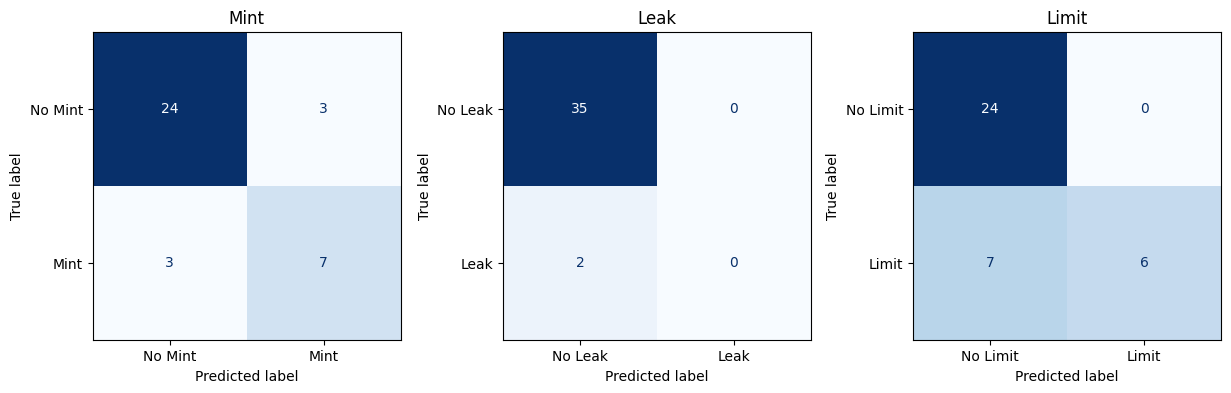

In [15]:
dataset = load_data(mode='cfg')[0]
loader = DataLoader(dataset, batch_size=128, shuffle=True)
y_true, y_pred, _ = val_model(model, loader, thresholds)

plot_confusion_matrix(y_true, y_pred, label_cols)

              precision    recall  f1-score   support

        Mint       0.70      0.70      0.70        10
        Leak       0.00      0.00      0.00         2
       Limit       1.00      0.46      0.63        13

   micro avg       0.81      0.52      0.63        25
   macro avg       0.57      0.39      0.44        25
weighted avg       0.80      0.52      0.61        25
 samples avg       0.20      0.20      0.20        25



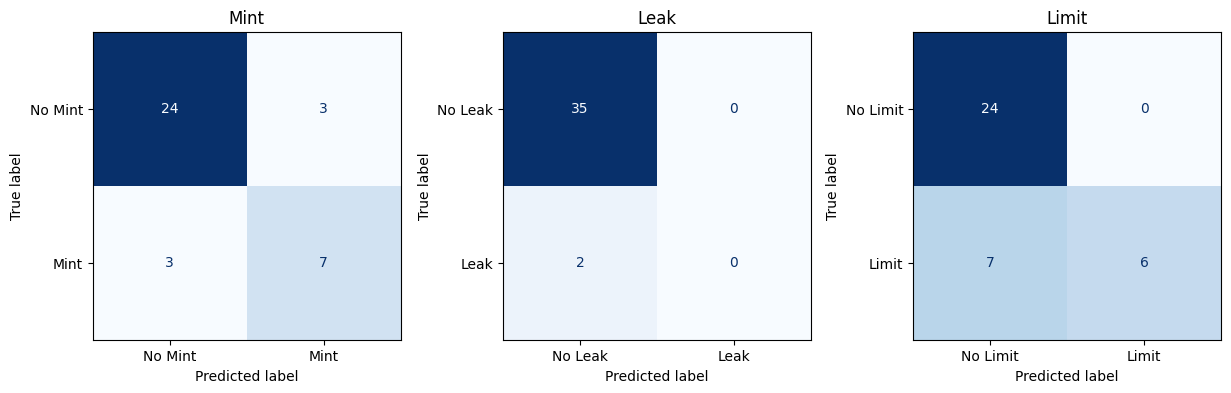

In [16]:
import torch
import json

# Load best parameters
with open("cfg_best_params.json", "r") as f:
    best_params = json.load(f)

# Get input and output channels (assuming they are consistent with training)
dataset_info, in_channels, label_cols = load_data(mode='txn')
out_channels = len(label_cols)

# Initialize the model with the loaded parameters
loaded_model = GCN(in_channels=in_channels, hidden=best_params['hidden_dim'], out_channels=out_channels, dropout=best_params['dropout'])

# Load the state dictionary
loaded_model.load_state_dict(torch.load("cfg_model.pth"))

thresholds = best_params['thresholds']
# Assuming 'loader' and 'thresholds' are already defined from previous cells
y_true, y_pred, _ = val_model(loaded_model, loader, thresholds)

plot_confusion_matrix(y_true, y_pred, label_cols)